### 필요 라이브러리 import

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas_datareader as web
import pandas_datareader.naver as web_naver
import yfinance as yf

import scipy.stats as stats
from talib import BBANDS

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier, plot_importance
from bayes_opt import BayesianOptimization

import multiprocessing

c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# 결과 고정을 위해 랜덤시드 고정
np.random.seed(42)

# 데이터 다운받기

In [4]:
DATA_PATH = './사용할 데이터프레임/'

In [84]:
# TIGER ETF와 KODEX ETF 자료 다운로드
df_tiger=web_naver.NaverDailyReader(symbols='137610', start='20110111',end='20220225',adjust_price=True).read()
df_kodex=web_naver.NaverDailyReader(symbols='271060', start='20170613',end='20220225',adjust_price=True).read()

# TIGER ETF와 KODEX ETF에 익영업일의 종가 등락 라벨링 해주기
# 종가가 오르거나 그대로면 1, 떨어지면 0
df_tiger['Close_1']=df_tiger['Close'].shift(-1)
df_tiger['Change']=np.log(df_tiger['Close'].astype(float)/df_tiger['Close_1'].astype(float))
df_tiger['label']=np.where(np.sign(df_tiger['Change'])<=0,1,-1)

df_kodex['Close_1']=df_kodex['Close'].shift(-1)
df_kodex['Change']=np.log(df_kodex['Close'].astype(float)/df_kodex['Close_1'].astype(float))
df_kodex['label']=np.where(np.sign(df_kodex['Change'])<=0,1,-1)

# 익영업일의 정보가 없는 마지막 row drop
df_kodex.dropna(inplace=True)
df_tiger.dropna(inplace=True)

In [85]:
df_kodex.head()

Open   High    Low  Close Volume Close_1    Change  label
Date                                                                  
2017-06-13   9965  10060   9965  10060  10010   10135 -0.007428      1
2017-06-14  10110  10150  10110  10135   1106   10065  0.006931     -1
2017-06-15  10060  10065  10025  10065    432   10200 -0.013324      1
2017-06-16  10190  10210  10175  10200   6212   10250 -0.004890      1
2017-06-19  10185  10275  10185  10250   4031   10230  0.001953     -1

In [86]:
df_tiger.head()

Open   High    Low  Close  Volume Close_1    Change  label
Date                                                                   
2011-01-11  10400  10500  10030  10065  221076   10005  0.005979     -1
2011-01-12  10200  10200  10000  10005  120538   10200 -0.019303      1
2011-01-13  10070  10220  10070  10200   75912   10200  0.000000      1
2011-01-14  10185  10240  10175  10200  102051   10450 -0.024214      1
2011-01-17  10485  11000  10205  10450  182345   10275  0.016888     -1

In [87]:
df_kodex.to_csv(DATA_PATH+'df_kodex.csv')
df_tiger.to_csv(DATA_PATH+'df_tiger.csv')

- 이와 같은 방식으로 pandas-datareader로 다운로드하거나, investing.com에서 받은 csv 자료들을 병합했다.

- 사용 자료 및 티커 정보는 다음과 같다.

1. 기초 자료 : </br>
S&P GSCI Agriculture Enhanced Select 지수 (티커 : 137610)</br>
KODEX 3대농산물선물(H) ETF (티커 : 271060)</br>
TIGER농산물선물Enhanced(H) ETF (티커 : 137610)</br>
S&P500, S&P500 선물 (티커 : ^GSPC, ES=F)</br>
미 실질 gdp growth announcement (출처 : investing.com)</br>

2. 외국 농산물 선물 자료 : </br>
밀 (ZW=F,KE=F)</br>
옥수수 (ZC=F)</br>
대두 (ZS=F)</br>
설탕 (SB=F)</br>
유가 선물 (CL=F)</br>
미국채 10년물 선물 (ZN=F)</br>
에탄올 선물 (1ZEc1)</br>

3. 국내의 외국 선물 지수추종 ETF 자료 : </br>
타이거 원유선물 enhanced(H) (130680)</br>
타이거 금속선물(H) (139310)</br>
KOSEF 미국달러선물 (138230)</br>
코덱스 철강 (117680)</br>
코덱스 달러선물 (261240)</br>

4. 외국 농산물 선물 ETF 자료 : </br>
Invesco DB Agriculture Fund (DBA)</br>
Teucrium Corn Fund (CORN)</br>
Teucrium Soybean (SOYB)</br>
Teucrium Wheat (WEAT)</br>
VanEck Agribusiness ETF (MOO)</br>

In [39]:
# Datetime으로 형식 지정하는 함수 정의
def index_to_date(df):
    df['Date']=pd.to_datetime(df['Date'])
    return df

In [115]:
# 코덱스 종가, 볼륨, 라벨 자료
kodex = pd.read_csv(DATA_PATH+'df_kodex.csv')
kodex = index_to_date(kodex)
kodex = kodex.set_index('Date')
kodex = kodex[['Close','Volume','label']]
kodex.columns = ['kodex_adjclose','kodex_volume','kodex_label']

# 타이거 종가, 볼륨, 라벨 자료
tiger = pd.read_csv(DATA_PATH+'df_tiger.csv')
tiger = index_to_date(tiger)
tiger = tiger.set_index('Date')
tiger = tiger[['Close','Volume','label']]
tiger.columns = ['tiger_adjclose','tiger_volume','tiger_label']

# sp500 수정종가, 볼륨 자료
sp500 = pd.read_csv(DATA_PATH+'sp500.csv')
sp500 = index_to_date(sp500)
sp500 = sp500.set_index('Date')
sp500 = sp500[['Adj Close','Volume']]
sp500.columns = ['sp500_adjclose','sp500_volume']

# sp500_f 수정종가, 볼륨 자료
sp500_f = pd.read_csv(DATA_PATH+'sp500_futures.csv')
sp500_f = index_to_date(sp500_f)
sp500_f = sp500_f.set_index('Date')
sp500_f = sp500_f[['Adj Close','Volume']]
sp500_f.columns = ['sp500_f_adjclose','sp500_f_volume']

# real_gdp 발표/예측/이전 성장률 자료
real_gdp = pd.read_csv(DATA_PATH+'real_gdp_announce.csv')
real_gdp.columns = ['Date','actual_growth','pred_growth','prev_growth']
real_gdp = index_to_date(real_gdp)
real_gdp = real_gdp.set_index('Date')

# grains_f 설탕/밀(ke)/밀(zw)/대두/옥수수 종가 및 볼륨 자료
grains_f = pd.read_csv(DATA_PATH+'곡물선물가격.csv')
grains_f = grains_f[grains_f['Date']>='2011-01-01'] # 필요 없는 날짜 제거
grains_f = index_to_date(grains_f)
grains_f = grains_f.set_index('Date')

# oil_ethanol_tbond_f 원유/에탄올/10년만기 미국 국채 선물 종가 및 볼륨 자료
oil_ethanol_tbond_f = pd.read_csv(DATA_PATH+'원유에탄올국채선물.csv')
oil_ethanol_tbond_f = index_to_date(oil_ethanol_tbond_f)
oil_ethanol_tbond_f = oil_ethanol_tbond_f.set_index('Date')

# other_etf 인베스코/Tieucrium옥수수/대두/밀/VanEck ETF 수정종가 및 볼륨 자료
other_etf = pd.read_csv(DATA_PATH+'외국원자재선물etf.csv')
other_etf = index_to_date(other_etf)
other_etf = other_etf.set_index('Date')

# kodex_dollar_iron 코덱스달러선물/코덱스철강선물 etf 종가 및 볼륨 자료
kodex_dollar_iron = pd.read_csv(DATA_PATH+'kodex_dollar_iron.csv')
kodex_dollar_iron = index_to_date(kodex_dollar_iron)
kodex_dollar_iron = kodex_dollar_iron.set_index('Date')

# kosef_usd_f KOSEF 달러선물 종가 및 볼륨 자료
kosef_usd_f = pd.read_csv(DATA_PATH+'kosef_usd_f.csv')
kosef_usd_f = kosef_usd_f[['Date','Close','Volume']]
kosef_usd_f.columns = ['Date','usd_f_close','usd_f_volume']
kosef_usd_f = index_to_date(kosef_usd_f)
kosef_usd_f = kosef_usd_f.set_index('Date')

# tiger_metal_oil 타이거금속선물/원유선물 종가 및 볼륨 자료
tiger_metal_oil = pd.read_csv(DATA_PATH+'tiger_metal_oil.csv')
tiger_metal_oil = index_to_date(tiger_metal_oil)
tiger_metal_oil = tiger_metal_oil.set_index('Date')

# gsci SP500 GSCI Grains select index 종가 자료
gsci = pd.read_csv(DATA_PATH+'GSCI.csv').iloc[:,:2]
gsci.columns = ['Date','gsci_adjclose']
gsci = index_to_date(gsci)
gsci = gsci.set_index('Date')

In [41]:
# 컬럼명 및 데이터타입 확인
#kodex.info()
#tiger.info()
#sp500.info()
#sp500_f.info()
#real_gdp.info()
#grains_f.info()
#oil_ethanol_tbond_f.info()
#other_etf.info()
#kodex_dollar_iron.info()
#tiger_dollar.info()
#tiger_metal_oil.info()
#gsci.info()
#kosef_usd_f.info()

# 데이터 전처리

#### 각 데이터프레임 결측치 확인 및 처리

In [42]:
for df in [kosef_usd_f,kodex,tiger,sp500,sp500_f,real_gdp,grains_f,oil_ethanol_tbond_f,other_etf,kodex_dollar_iron,tiger_metal_oil,gsci]:
    print(df.isna().sum())

usd_f_close     0
usd_f_volume    0
dtype: int64
kodex_adjclose    0
kodex_volume      0
kodex_label       0
dtype: int64
tiger_adjclose    0
tiger_volume      0
tiger_label       0
dtype: int64
sp500_adjclose    0
sp500_volume      0
dtype: int64
sp500_f_adjclose    0
sp500_f_volume      0
dtype: int64
actual_growth    0
pred_growth      0
prev_growth      0
dtype: int64
sugar_close        0
sugar_volume       0
wheat_ke_close     0
wheat_ke_volume    0
wheat_zw_close     0
wheat_zw_volume    0
soybean_close      0
soybean_volume     0
corn_close         2
corn_volume        2
dtype: int64
crude_oil_adjclose      0
crude_oil_volume        0
ethanol_close           3
ethanol_volume        368
tbond_fut_adjclose      2
tbond_fut_volume        2
dtype: int64
DBA_adjclose       0
DBA_volume         0
CORN_adjclose      0
CORN_volume        0
SOYB_adjclose    184
SOYB_volume      184
WEAT_adjclose    181
WEAT_volume      181
MOO_adjclose       0
MOO_volume         0
dtype: int64
kodex_doll

거래량의 경우, 결측치로 처리된 날은 거래량이 미미한 것으로 보고 0을 넣어주었고, 종가의 경우에는 fillna() 함수의 `method='ffill'` 옵션을 이용해 전날 종가로 대체했다. 대부분의 데이터프레임에서 결측치는 2~3개에 불과하고 에탄올 거래량만 368개의 결측치를 보이기에 모델의 성능에 큰 영향을 미치지 않을 것으로 판단했다.

그러나 other_etf 데이터프레임의 SOYB와 WEAT 선물지수의 종가 및 거래량 자료는 2011-09-19부터 존재하기에 결측치가 181개 이상이었다. 타이거 지수 예측 모델에서 해당 피처를 사용하게 될 경우, 학습데이터는 첫 8달 가량의 데이터를 제거한 후 2011-09-19일 자료부터 사용하겠다.

In [43]:
grains_f = grains_f.fillna(method='ffill')
grains_f.isna().sum()

sugar_close        0
sugar_volume       0
wheat_ke_close     0
wheat_ke_volume    0
wheat_zw_close     0
wheat_zw_volume    0
soybean_close      0
soybean_volume     0
corn_close         0
corn_volume        0
dtype: int64

In [44]:
oil_ethanol_tbond_f['ethanol_volume'] = oil_ethanol_tbond_f['ethanol_volume'].fillna(value=0)
oil_ethanol_tbond_f = oil_ethanol_tbond_f.fillna(method='ffill')
oil_ethanol_tbond_f.isna().sum()

crude_oil_adjclose    0
crude_oil_volume      0
ethanol_close         0
ethanol_volume        0
tbond_fut_adjclose    0
tbond_fut_volume      0
dtype: int64

In [45]:
cond = pd.to_datetime(other_etf.index)>='2011-09-19' # 아예 자료가 없는 2011-09-19 이전은 그대로 두고, 학습 전에 drop시킨다.
other_etf[cond]['SOYB_volume'] = other_etf[cond]['SOYB_volume'].fillna(value=0) # 2011-09-19 이후의 결측치 처리
other_etf[cond]['WEAT_volume'] = other_etf[cond]['WEAT_volume'].fillna(value=0)
other_etf[cond] = other_etf[cond].fillna(method='ffill')
print(other_etf[cond].isna().sum())
print(other_etf.isna().sum())

DBA_adjclose     0
DBA_volume       0
CORN_adjclose    0
CORN_volume      0
SOYB_adjclose    0
SOYB_volume      0
WEAT_adjclose    0
WEAT_volume      0
MOO_adjclose     0
MOO_volume       0
dtype: int64
DBA_adjclose       0
DBA_volume         0
CORN_adjclose      0
CORN_volume        0
SOYB_adjclose    180
SOYB_volume      180
WEAT_adjclose    180
WEAT_volume      180
MOO_adjclose       0
MOO_volume         0
dtype: int64


C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\3216215029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_etf[cond]['SOYB_volume'] = other_etf[cond]['SOYB_volume'].fillna(value=0) # 2011-09-19 이후의 결측치 처리
C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\3216215029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_etf[cond]['WEAT_volume'] = other_etf[cond]['WEAT_volume'].fillna(value=0)


이제 학습과정에서 drop시킬 결측치를 제외한 나머지 결측치를 모두 처리했으므로 모델 학습을 위해 데이터를 합치자.

## 데이터 병합

### 1. 타이거 지수 예측 모델을 위한 데이터프레임

사용하는 데이터프레임 :
- tiger
- sp500
- sp500_f
- real_gdp
- grains_f
- oil_ethanol_tbond_f
- other_etf
- tiger_metal_oil
- kosef_usd_f # tiger 달러선물레버리지는 2016년 말에 상장했기 때문에 대체 자료 사용

In [46]:
df_list = [sp500, sp500_f, real_gdp, grains_f, oil_ethanol_tbond_f, other_etf, tiger_metal_oil, kosef_usd_f]
df_mod1 = tiger

for df in df_list:
    df_mod1 = df_mod1.join(df)

df_mod1

tiger_adjclose  tiger_volume  tiger_label  sp500_adjclose  \
Date                                                                    
2011-01-11           10065        221076           -1     1274.479980   
2011-01-12           10005        120538            1     1285.959961   
2011-01-13           10200         75912            1     1283.760010   
2011-01-14           10200        102051            1     1293.239990   
2011-01-17           10450        182345           -1             NaN   
...                    ...           ...          ...             ...   
2022-02-18            7310         14183            1             NaN   
2022-02-21            7360         18761            1             NaN   
2022-02-22            7470         50805            1             NaN   
2022-02-23            7575         67499            1             NaN   
2022-02-24            8010        173455           -1             NaN   

            sp500_volume  sp500_f_adjclose  sp500_f_volume  actual_growth  \
Date                                                                        
2011-01-11  4.050750e+09           1270.50       1662412.0            2.6   
2011-01-12  4.226940e+09           1283.50       1604117.0            2.6   
2011-01-13  4.310840e+09           1281.25       1671242.0            2.6   
2011-01-14  4.661590e+09           1289.50       1631162.0            2.6   
2011-01-17           NaN               NaN             NaN            2.6   
...                  ...               ...             ...            ...   
2022-02-18           NaN               NaN             NaN            NaN   
2022-02-21           NaN               NaN             NaN            NaN   
2022-02-22           NaN               NaN             NaN            NaN   
2022-02-23           NaN               NaN             NaN            NaN   
2022-02-24           NaN               NaN             NaN            NaN   

            pred_growth  prev_growth  ...  WEAT_adjclose  WEAT_volume  \
Date                                  ...                               
2011-01-11          2.6          2.6  ...            NaN          NaN   
2011-01-12          2.6          2.6  ...            NaN          NaN   
2011-01-13          2.6          2.6  ...            NaN          NaN   
2011-01-14          2.6          2.6  ...            NaN          NaN   
2011-01-17          2.6          2.6  ...            NaN          NaN   
...                 ...          ...  ...            ...          ...   
2022-02-18          NaN          NaN  ...            NaN          NaN   
2022-02-21          NaN          NaN  ...            NaN          NaN   
2022-02-22          NaN          NaN  ...            NaN          NaN   
2022-02-23          NaN          NaN  ...            NaN          NaN   
2022-02-24          NaN          NaN  ...            NaN          NaN   

            MOO_adjclose  MOO_volume  tiger_metal_close  tiger_metal_volume  \
Date                                                                          
2011-01-11     45.009132   1312200.0                NaN                 NaN   
2011-01-12     46.220470   2162500.0                NaN                 NaN   
2011-01-13     46.344082   3373400.0                NaN                 NaN   
2011-01-14     46.558331   1801300.0                NaN                 NaN   
2011-01-17           NaN         NaN                NaN                 NaN   
...                  ...         ...                ...                 ...   
2022-02-18           NaN         NaN             7990.0             12294.0   
2022-02-21           NaN         NaN                NaN                 NaN   
2022-02-22           NaN         NaN                NaN                 NaN   
2022-02-23           NaN         NaN                NaN                 NaN   
2022-02-24           NaN         NaN                NaN                 NaN   

            tiger_oil_close  tiger_oil_volume  usd_f_close  usd_f_volume  
Date   

결측치가 얼마나 생겼는지 확인해보자.

In [47]:
df_mod1.isna().sum()

tiger_adjclose          0
tiger_volume            0
tiger_label             0
sp500_adjclose        105
sp500_volume          105
sp500_f_adjclose      106
sp500_f_volume        106
actual_growth          17
pred_growth            17
prev_growth            17
sugar_close            91
sugar_volume           91
wheat_ke_close         91
wheat_ke_volume        91
wheat_zw_close         91
wheat_zw_volume        91
soybean_close          91
soybean_volume         91
corn_close             91
corn_volume            91
crude_oil_adjclose     90
crude_oil_volume       90
ethanol_close          90
ethanol_volume         90
tbond_fut_adjclose     90
tbond_fut_volume       90
DBA_adjclose           89
DBA_volume             89
CORN_adjclose          89
CORN_volume            89
SOYB_adjclose         252
SOYB_volume           252
WEAT_adjclose         252
WEAT_volume           252
MOO_adjclose           89
MOO_volume             89
tiger_metal_close      63
tiger_metal_volume     63
tiger_oil_cl

In [48]:
df_mod1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2741 entries, 2011-01-11 to 2022-02-24
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tiger_adjclose      2741 non-null   int64  
 1   tiger_volume        2741 non-null   int64  
 2   tiger_label         2741 non-null   int64  
 3   sp500_adjclose      2636 non-null   float64
 4   sp500_volume        2636 non-null   float64
 5   sp500_f_adjclose    2635 non-null   float64
 6   sp500_f_volume      2635 non-null   float64
 7   actual_growth       2724 non-null   float64
 8   pred_growth         2724 non-null   float64
 9   prev_growth         2724 non-null   float64
 10  sugar_close         2650 non-null   float64
 11  sugar_volume        2650 non-null   float64
 12  wheat_ke_close      2650 non-null   float64
 13  wheat_ke_volume     2650 non-null   float64
 14  wheat_zw_close      2650 non-null   float64
 15  wheat_zw_volume     2650 non-null   f

결측치를 포함한 행을 drop시키자.

앞서 언급했던 SOYB, WEAT와 같은 commodity futures etf들의 상장일 차이로 인해 180일의 데이터(2011-01-11~2011-09-18까지의 영업일에 해당하는 데이터)가 drop되었고, 미장과 한국장의 영업일 차이나 각종 선물상품들의 거래일 차이 등으로 인해 90일의 데이터가 drop되면서 총 270일의 데이터가 drop되었다.

In [49]:
df_mod1 = df_mod1.dropna()
df_mod1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2471 entries, 2011-09-19 to 2022-01-21
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tiger_adjclose      2471 non-null   int64  
 1   tiger_volume        2471 non-null   int64  
 2   tiger_label         2471 non-null   int64  
 3   sp500_adjclose      2471 non-null   float64
 4   sp500_volume        2471 non-null   float64
 5   sp500_f_adjclose    2471 non-null   float64
 6   sp500_f_volume      2471 non-null   float64
 7   actual_growth       2471 non-null   float64
 8   pred_growth         2471 non-null   float64
 9   prev_growth         2471 non-null   float64
 10  sugar_close         2471 non-null   float64
 11  sugar_volume        2471 non-null   float64
 12  wheat_ke_close      2471 non-null   float64
 13  wheat_ke_volume     2471 non-null   float64
 14  wheat_zw_close      2471 non-null   float64
 15  wheat_zw_volume     2471 non-null   f

### 2. 코덱스 지수 예측 모델을 위한 데이터프레임

사용하는 데이터프레임 :
- kodex
- sp500
- sp500_f
- real_gdp
- grains_f
- oil_ethanol_tbond_f
- other_etf
- kodex_dollar_iron
- gsci

In [50]:
df_list = [sp500, sp500_f, real_gdp, grains_f, oil_ethanol_tbond_f, other_etf, kodex_dollar_iron, gsci]
df_mod2 = kodex

for df in df_list:
    df_mod2 = df_mod2.join(df)

df_mod2

kodex_adjclose  kodex_volume  kodex_label  sp500_adjclose  \
Date                                                                    
2017-06-13           10060         10010            1     2440.350098   
2017-06-14           10135          1106           -1     2437.919922   
2017-06-15           10065           432            1     2432.459961   
2017-06-16           10200          6212            1     2433.149902   
2017-06-19           10250          4031           -1     2453.459961   
...                    ...           ...          ...             ...   
2022-02-18           12395          7323            1             NaN   
2022-02-21           12600         17961            1             NaN   
2022-02-22           12760         43388            1             NaN   
2022-02-23           13020         28706            1             NaN   
2022-02-24           13960         89560           -1             NaN   

            sp500_volume  sp500_f_adjclose  sp500_f_volume  actual_growth  \
Date                                                                        
2017-06-13  3.275500e+09           2440.00       1028985.0            1.4   
2017-06-14  3.555590e+09           2437.25        684544.0            1.4   
2017-06-15  3.353050e+09           2434.25        470700.0            1.4   
2017-06-16  5.284720e+09           2433.75       1336684.0            1.4   
2017-06-19  3.264700e+09           2447.50       1223334.0            1.4   
...                  ...               ...             ...            ...   
2022-02-18           NaN               NaN             NaN            NaN   
2022-02-21           NaN               NaN             NaN            NaN   
2022-02-22           NaN               NaN             NaN            NaN   
2022-02-23           NaN               NaN             NaN            NaN   
2022-02-24           NaN               NaN             NaN            NaN   

            pred_growth  prev_growth  ...  SOYB_volume  WEAT_adjclose  \
Date                                  ...                               
2017-06-13          1.2          1.2  ...      17700.0           6.99   
2017-06-14          1.2          1.2  ...       4900.0           7.00   
2017-06-15          1.2          1.2  ...      10000.0           7.15   
2017-06-16          1.2          1.2  ...      21300.0           7.30   
2017-06-19          1.2          1.2  ...       8700.0           7.25   
...                 ...          ...  ...          ...            ...   
2022-02-18          NaN          NaN  ...          NaN            NaN   
2022-02-21          NaN          NaN  ...          NaN            NaN   
2022-02-22          NaN          NaN  ...          NaN            NaN   
2022-02-23          NaN          NaN  ...          NaN            NaN   
2022-02-24          NaN          NaN  ...          NaN            NaN   

            WEAT_volume  MOO_adjclose  MOO_volume  kodex_dollar_close  \
Date                                                                    
2017-06-13      74400.0     52.382080    187000.0              9425.0   
2017-06-14     165200.0     52.307316     46300.0              9390.0   
2017-06-15     201000.0     51.998913     27400.0              9390.0   
2017-06-16     374400.0     52.288628     60300.0              9490.0   
2017-06-19     291500.0     52.419464     54300.0              9480.0   
...                 ...           ...         ...                 ...   
2022-02-18          NaN           NaN         NaN             10565.0   
2022-02-21          NaN           NaN         NaN                 NaN   
2022-02-22          NaN           NaN         NaN                 NaN   
2022-02-23          NaN           NaN         NaN                 NaN   
2022-02-24          NaN           NaN         NaN                 NaN   

            kodex_dollar_volume  kodex_metal_close  kodex_metal_volume  \
Date                                                                     
2017-06-13  

결측치가 얼마나 생겼는지 확인해보자.

In [51]:
df_mod2.isna().sum()

kodex_adjclose          0
kodex_volume            0
kodex_label             0
sp500_adjclose         55
sp500_volume           55
sp500_f_adjclose       54
sp500_f_volume         54
actual_growth          17
pred_growth            17
prev_growth            17
sugar_close            39
sugar_volume           39
wheat_ke_close         39
wheat_ke_volume        39
wheat_zw_close         39
wheat_zw_volume        39
soybean_close          39
soybean_volume         39
corn_close             39
corn_volume            39
crude_oil_adjclose     38
crude_oil_volume       38
ethanol_close          38
ethanol_volume         38
tbond_fut_adjclose     38
tbond_fut_volume       38
DBA_adjclose           39
DBA_volume             39
CORN_adjclose          39
CORN_volume            39
SOYB_adjclose          39
SOYB_volume            39
WEAT_adjclose          39
WEAT_volume            39
MOO_adjclose           39
MOO_volume             39
kodex_dollar_close      4
kodex_dollar_volume     4
kodex_metal_

In [52]:
df_mod2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1157 entries, 2017-06-13 to 2022-02-24
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   kodex_adjclose       1157 non-null   int64  
 1   kodex_volume         1157 non-null   int64  
 2   kodex_label          1157 non-null   int64  
 3   sp500_adjclose       1102 non-null   float64
 4   sp500_volume         1102 non-null   float64
 5   sp500_f_adjclose     1103 non-null   float64
 6   sp500_f_volume       1103 non-null   float64
 7   actual_growth        1140 non-null   float64
 8   pred_growth          1140 non-null   float64
 9   prev_growth          1140 non-null   float64
 10  sugar_close          1118 non-null   float64
 11  sugar_volume         1118 non-null   float64
 12  wheat_ke_close       1118 non-null   float64
 13  wheat_ke_volume      1118 non-null   float64
 14  wheat_zw_close       1118 non-null   float64
 15  wheat_zw_volume     

마찬가지로 결측치를 포함한 행을 drop시키자.

83일의 데이터가 drop되었다.

In [53]:
df_mod2 = df_mod2.dropna()
df_mod2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1074 entries, 2017-07-24 to 2022-01-21
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   kodex_adjclose       1074 non-null   int64  
 1   kodex_volume         1074 non-null   int64  
 2   kodex_label          1074 non-null   int64  
 3   sp500_adjclose       1074 non-null   float64
 4   sp500_volume         1074 non-null   float64
 5   sp500_f_adjclose     1074 non-null   float64
 6   sp500_f_volume       1074 non-null   float64
 7   actual_growth        1074 non-null   float64
 8   pred_growth          1074 non-null   float64
 9   prev_growth          1074 non-null   float64
 10  sugar_close          1074 non-null   float64
 11  sugar_volume         1074 non-null   float64
 12  wheat_ke_close       1074 non-null   float64
 13  wheat_ke_volume      1074 non-null   float64
 14  wheat_zw_close       1074 non-null   float64
 15  wheat_zw_volume     

이제 병합된 데이터를 확인해보자.

In [54]:
# tiger 등락은 거의 유사
df_mod1['tiger_label'].value_counts()

 1    1236
-1    1235
Name: tiger_label, dtype: int64

In [55]:
# kodex 등락은 상승이 조금 더 많음
df_mod2['kodex_label'].value_counts()

-1    551
 1    523
Name: kodex_label, dtype: int64

<AxesSubplot:xlabel='Date', ylabel='tiger_adjclose'>

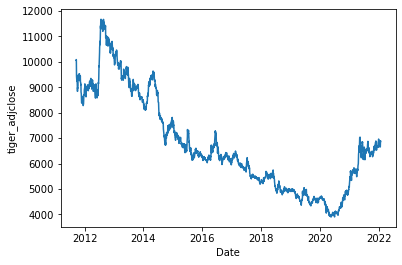

In [56]:
# tiger 주가는 하락 후 상승 중
sns.lineplot(x=df_mod1.index,y=df_mod1['tiger_adjclose'])

<AxesSubplot:xlabel='Date', ylabel='kodex_adjclose'>

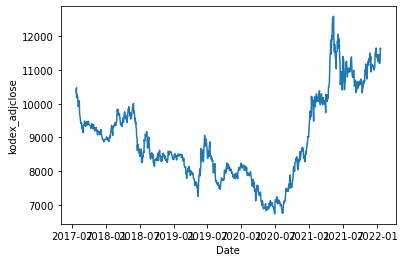

In [57]:
# kodex 주가는 하락 후 상승 중. 다만 이 때 2017년 자료부터 있음을 고려해보면 큰 차이는 없음. 둘 다 같은 지수를 추종하기 때문.
sns.lineplot(x=df_mod2.index,y=df_mod2['kodex_adjclose'])

이상치도 확인해보자.

In [58]:
# lineplot 그리는 함수 정의
def show_plot(df, columns):
    for col in columns:
        plt.figure()
        sns.lineplot(x=df.index,y=df[col])

In [59]:
# 이상치를 확인할 컬럼명 리스트 만들기
df1_cols = [x for x in df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')

df2_cols = [x for x in df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('prev_growth')

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\3878870576.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


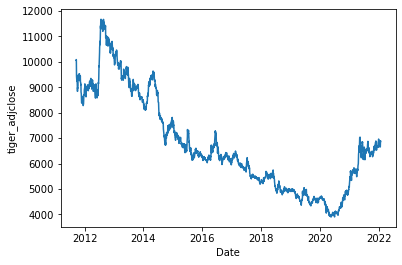

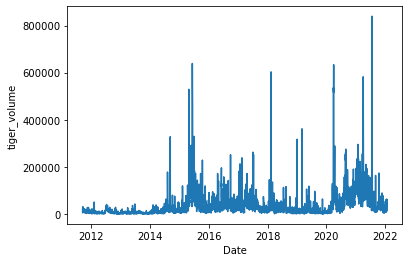

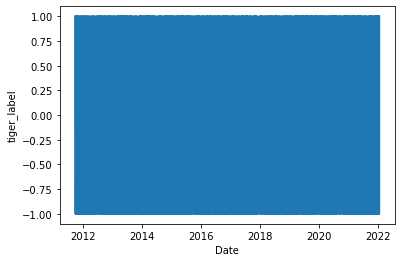

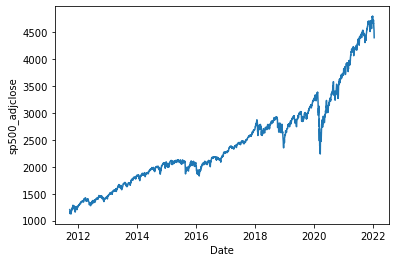

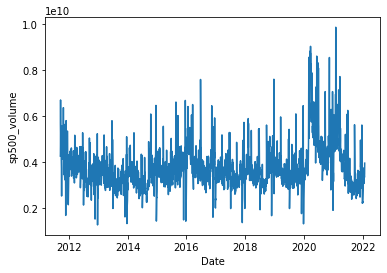

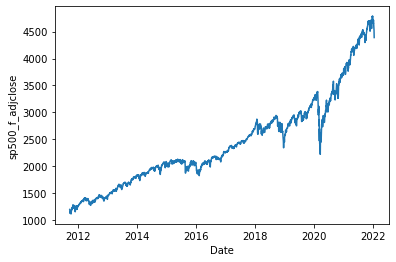

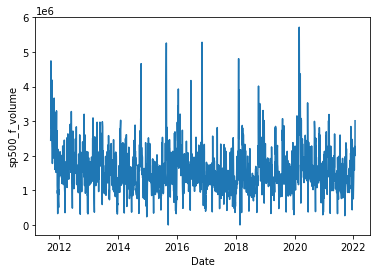

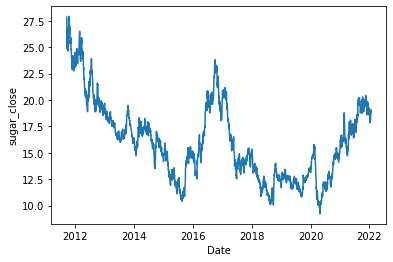

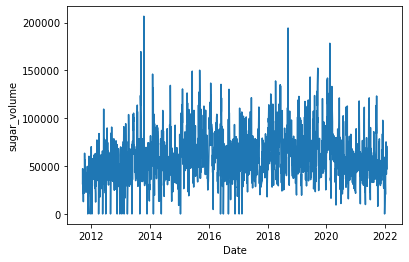

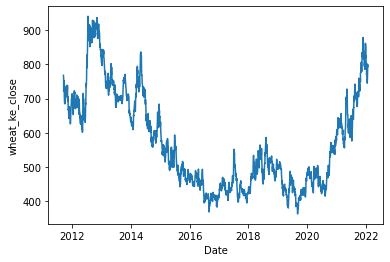

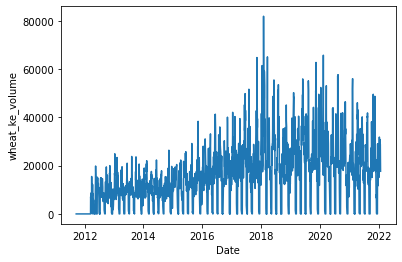

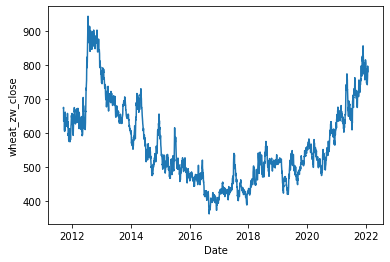

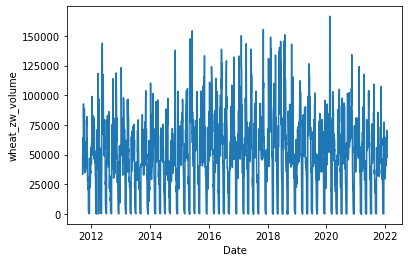

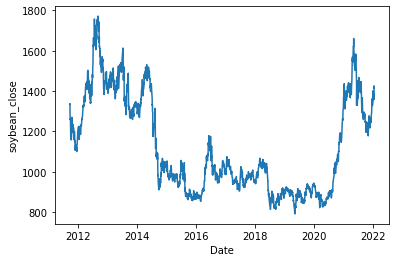

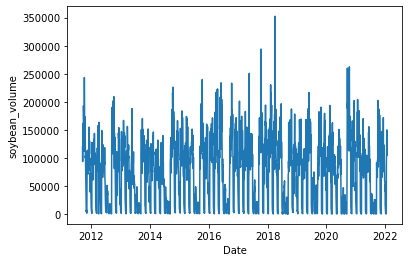

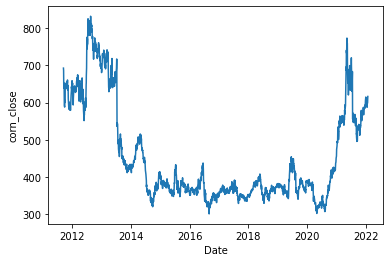

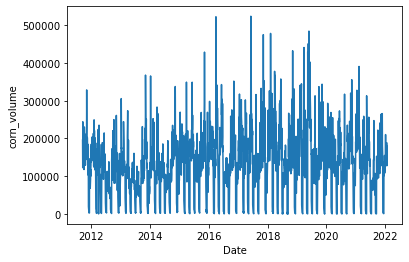

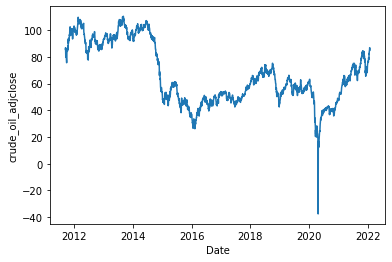

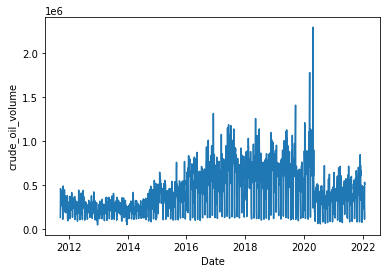

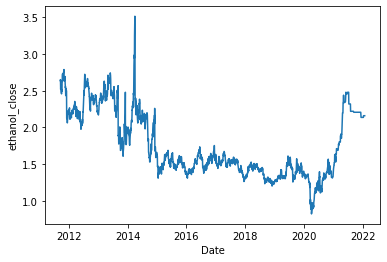

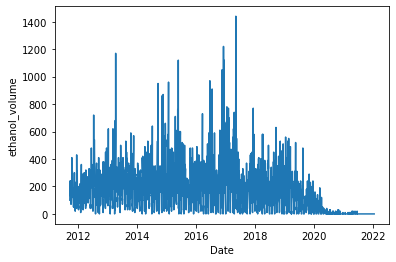

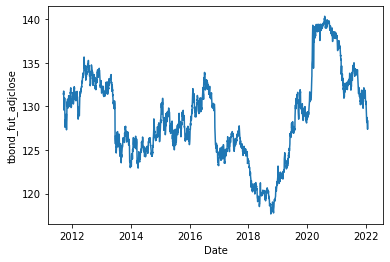

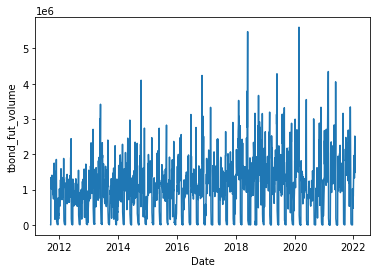

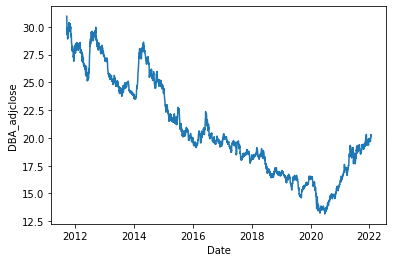

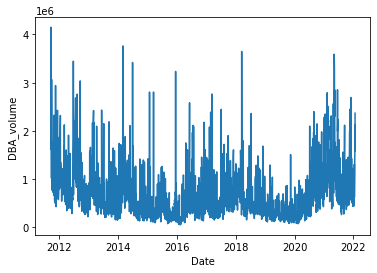

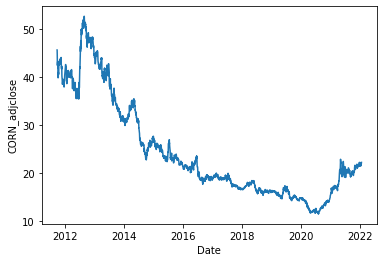

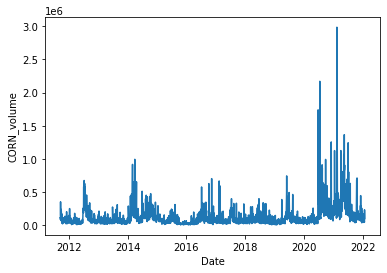

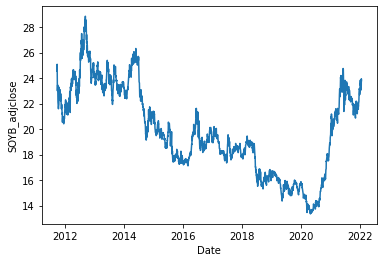

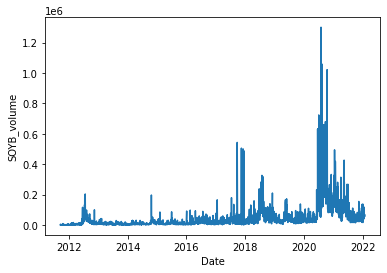

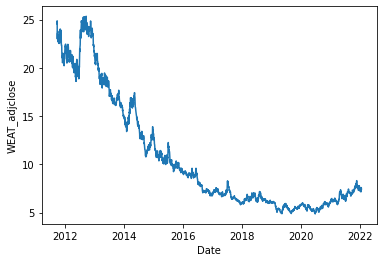

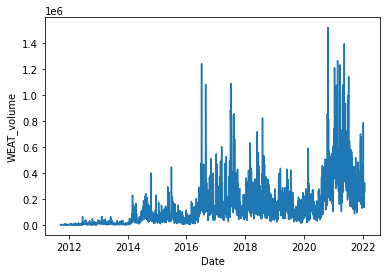

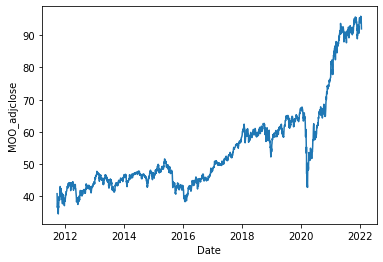

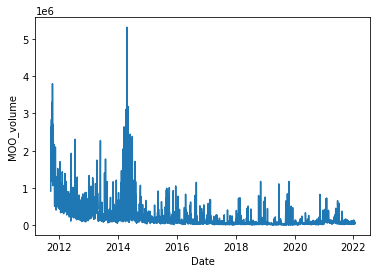

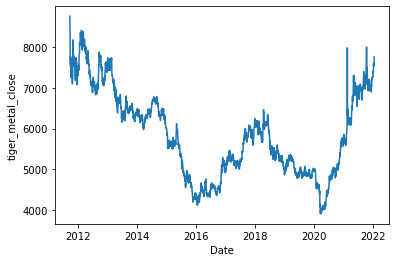

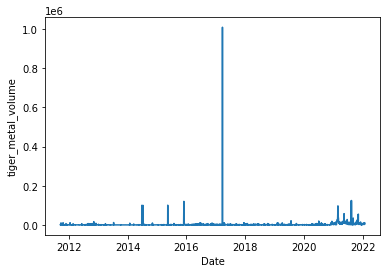

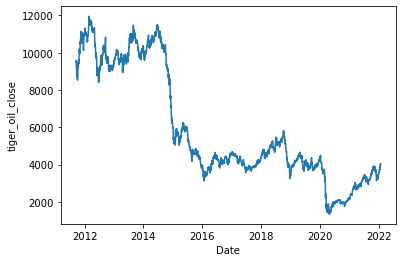

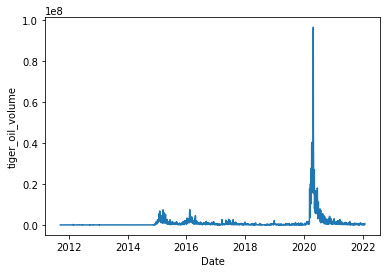

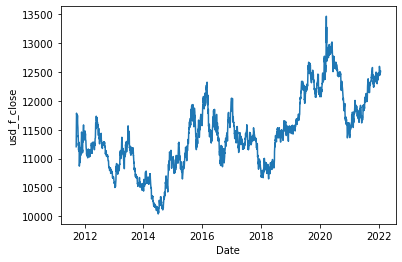

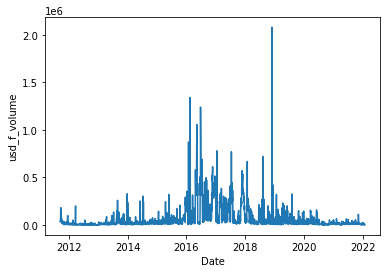

In [60]:
show_plot(df_mod1,df1_cols)

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\3878870576.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


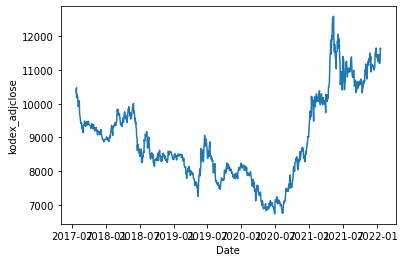

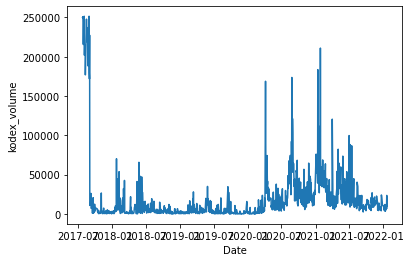

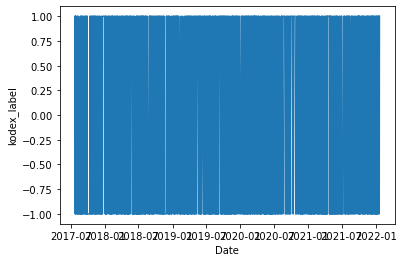

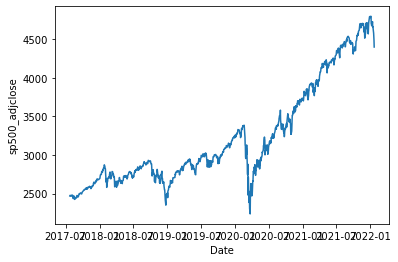

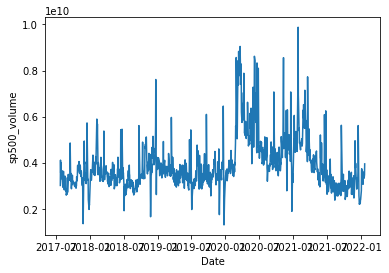

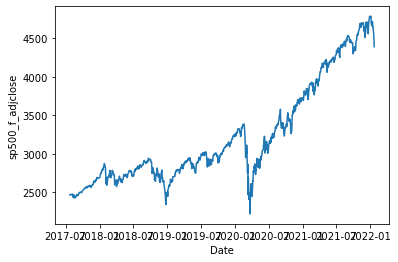

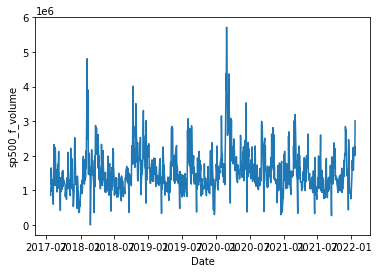

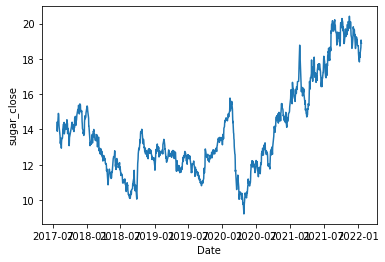

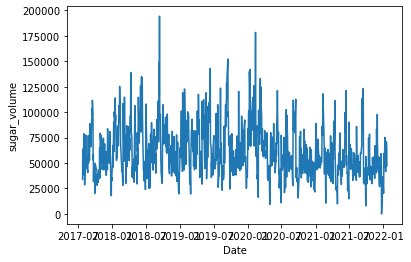

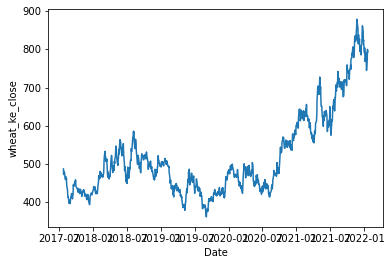

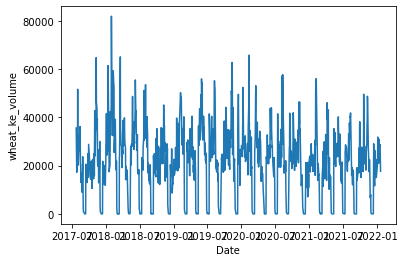

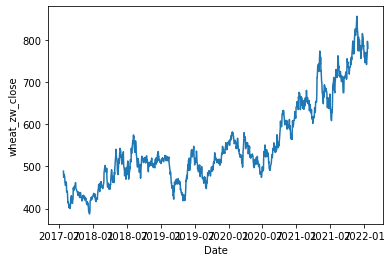

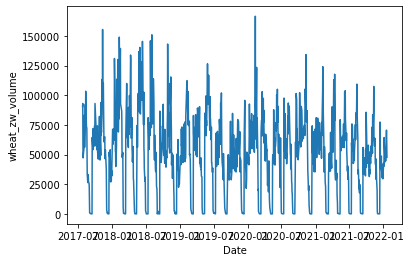

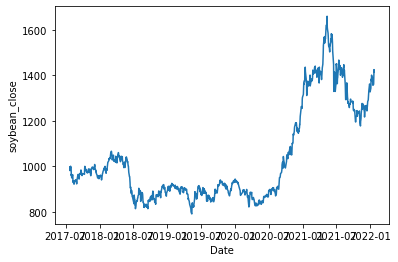

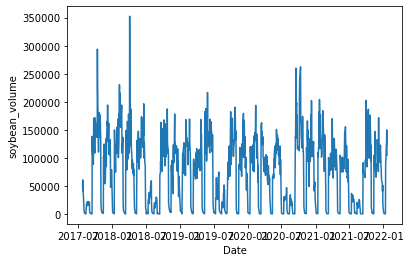

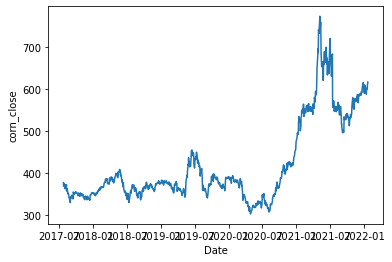

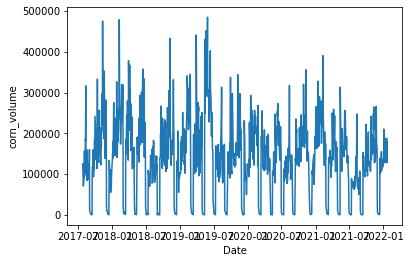

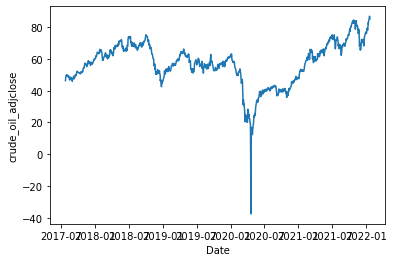

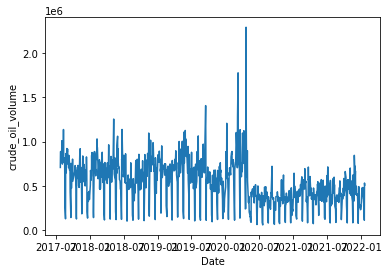

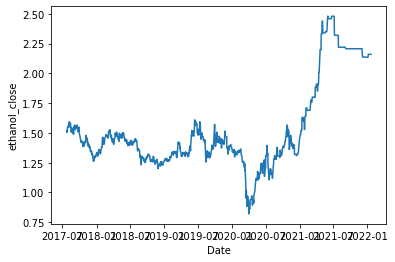

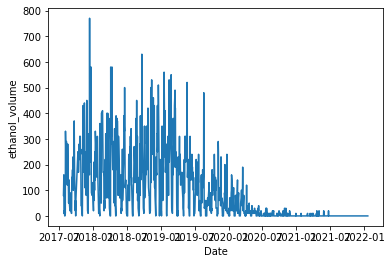

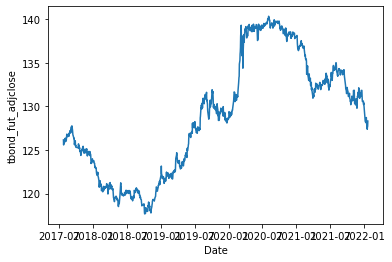

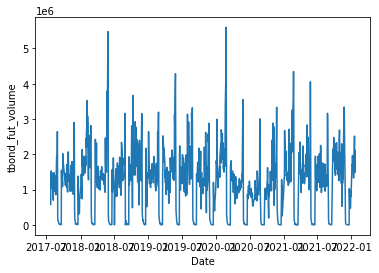

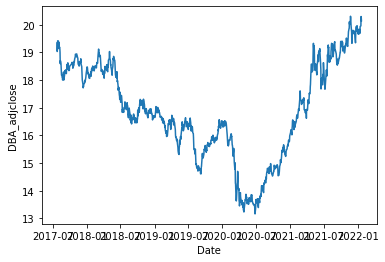

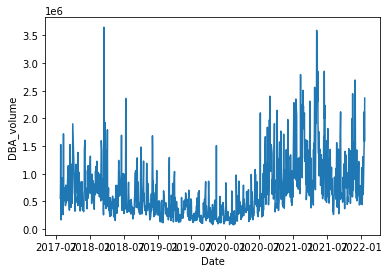

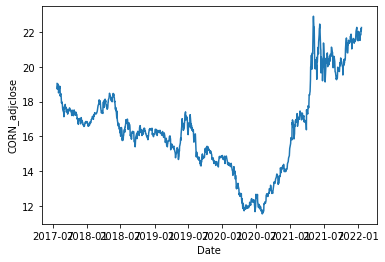

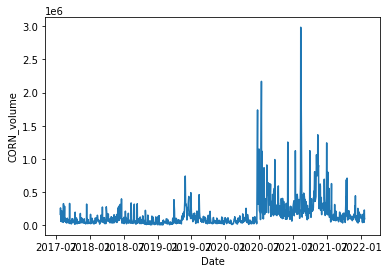

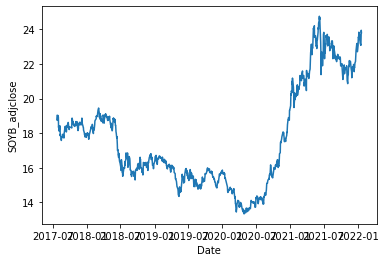

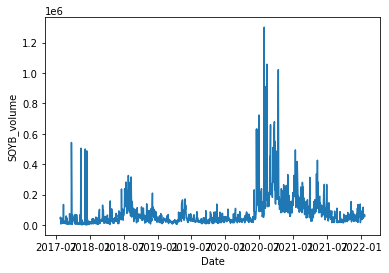

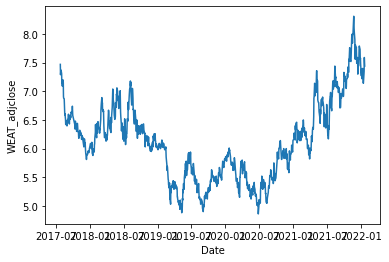

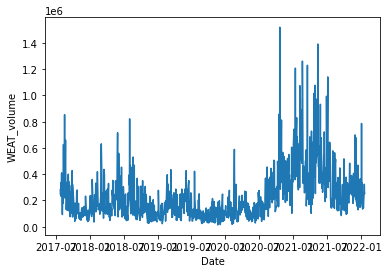

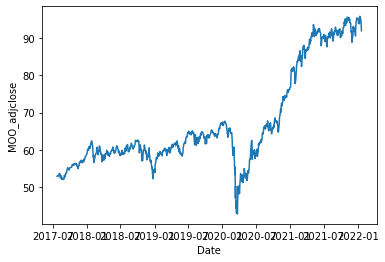

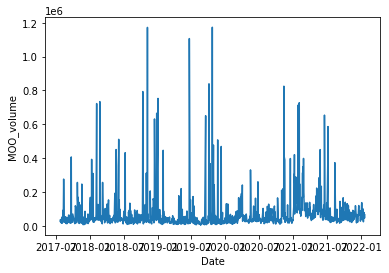

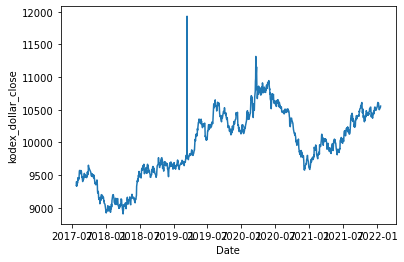

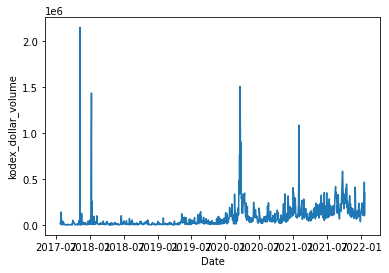

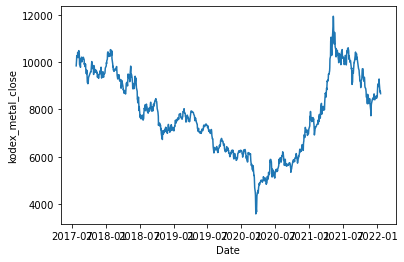

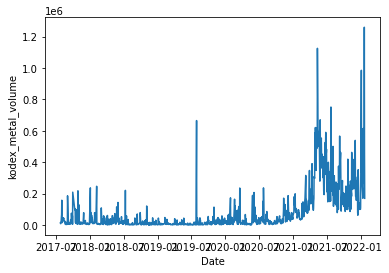

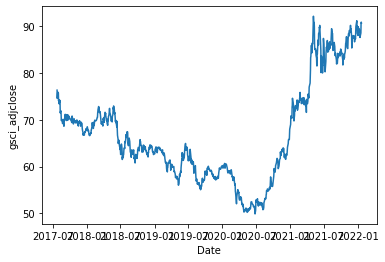

In [61]:
show_plot(df_mod2,df2_cols)

그래프를 보면 알 수 있듯이, 잦은 빈도로 outlier가 등장한다. 이러한 outlier는 모델의 성능을 악화시킬 수 있으므로 추후 전처리 과정에서 제거해야 하는데, 단순히 표준정규화 후 몇 표준편차 떨어져있는가로 제거해버리면 주가의 상하 움직임을 고려하지 못한다.

=> 추후 심한 데이터프레임만 볼린저밴드를 이용하여 winsorize 해준다.

컬럼별 상관관계 구조도 확인해보자.

<AxesSubplot:>

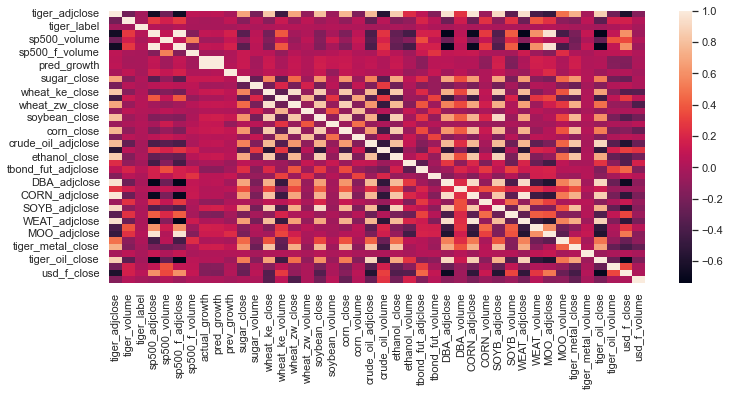

In [68]:
sns.set(rc = {'figure.figsize':(12,5)})
sns.heatmap(df_mod1.astype('float').corr())

<AxesSubplot:>

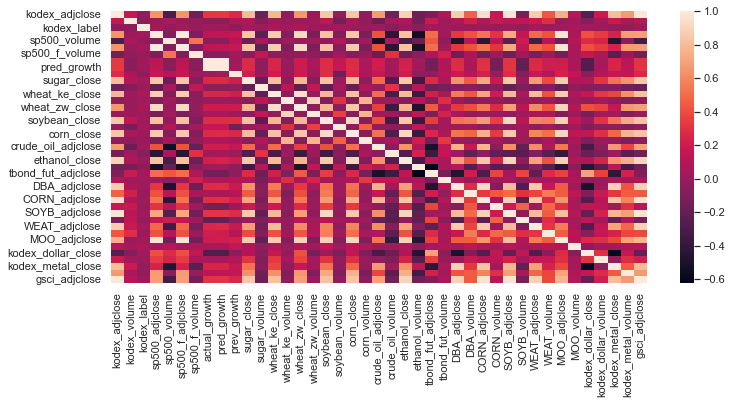

In [67]:
sns.set(rc = {'figure.figsize':(12,5)})
sns.heatmap(df_mod2.astype('float').corr())

상관관계가 보이는 컬럼들이 몇 개 있지만, lightgbm은 다중공선성에 robust하므로 일단 그대로 두고 진행한다.

outlier 제거 및 정규화를 진행하자.

- 우선 유가 선물 가격 자료에 하방으로 severe outlier가 있으므로 이를 winsorize 해준다.

<AxesSubplot:xlabel='Date'>

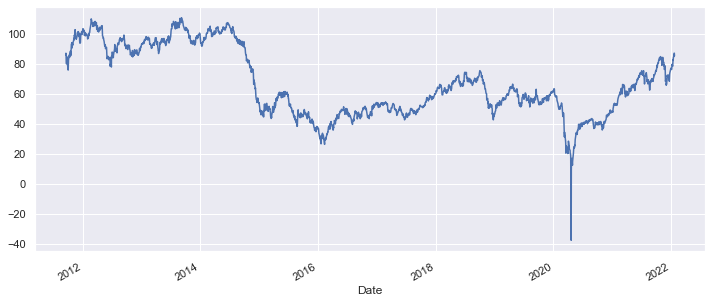

In [69]:
df_mod1['crude_oil_adjclose'].plot(figsize=(12,5))

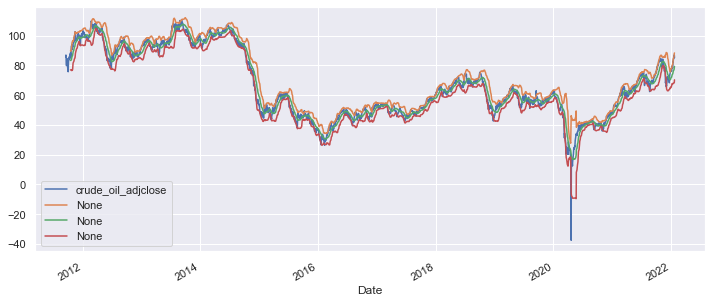

In [66]:
up_oil_1, mid_oil_1, low_oil_1 = BBANDS(df_mod1['crude_oil_adjclose'], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

df_mod1['crude_oil_adjclose'].plot(figsize=(12,5))
up_oil_1.plot(figsize=(12,5))
mid_oil_1.plot(figsize=(12,5))
low_oil_1.plot(figsize=(12,5))
plt.legend()

In [70]:
df_mod1['crude_oil_adjclose']=df_mod1['crude_oil_adjclose'].clip(lower=low_oil_1.min())

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\2353152691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod1['crude_oil_adjclose']=df_mod1['crude_oil_adjclose'].clip(lower=low_oil_1.min())


<AxesSubplot:xlabel='Date'>

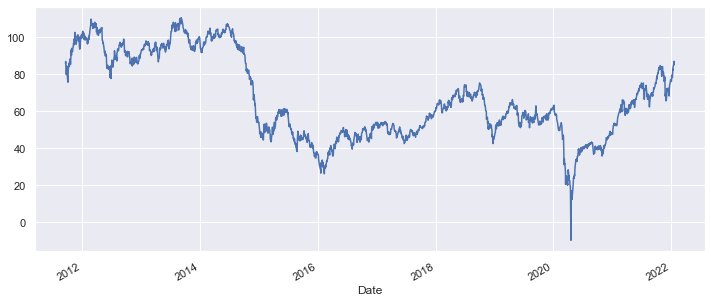

In [71]:
df_mod1['crude_oil_adjclose'].plot()

- df_mod2 데이터프레임에도 동일한 처리를 해준다.

<AxesSubplot:xlabel='Date'>

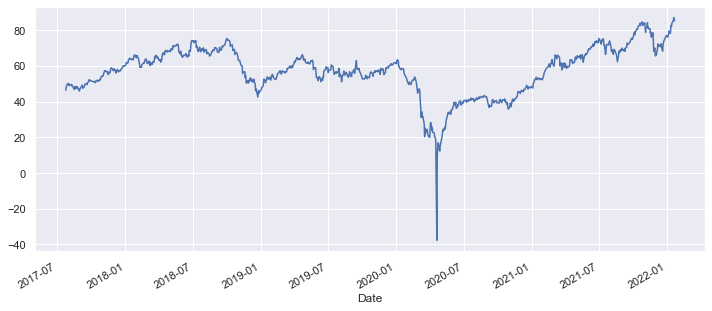

In [72]:
df_mod2['crude_oil_adjclose'].plot()

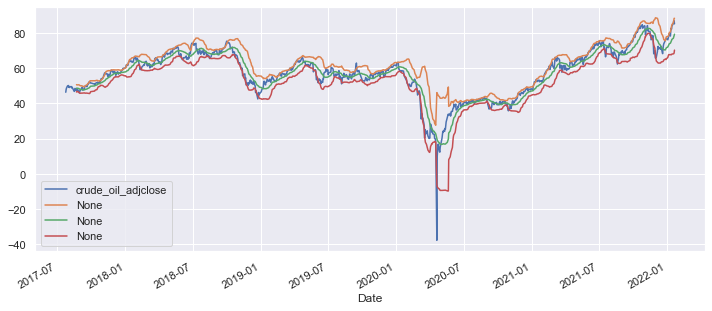

In [73]:
up_oil_2, mid_oil_2, low_oil_2 = BBANDS(df_mod2['crude_oil_adjclose'], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

df_mod2['crude_oil_adjclose'].plot(figsize=(12,5))
up_oil_2.plot(figsize=(12,5))
mid_oil_2.plot(figsize=(12,5))
low_oil_2.plot(figsize=(12,5))
plt.legend()

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\1364333591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod2['crude_oil_adjclose']=df_mod2['crude_oil_adjclose'].clip(lower=low_oil_2.min())


<AxesSubplot:xlabel='Date'>

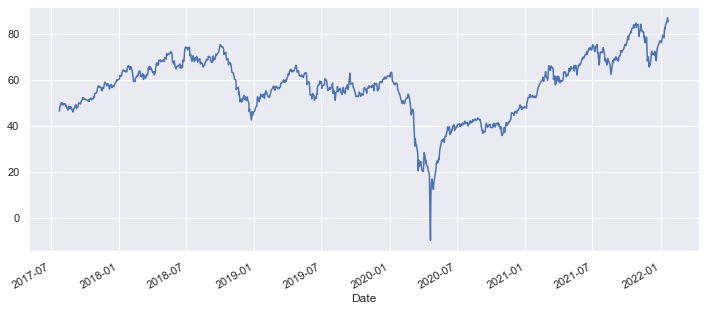

In [74]:
df_mod2['crude_oil_adjclose']=df_mod2['crude_oil_adjclose'].clip(lower=low_oil_2.min())
df_mod2['crude_oil_adjclose'].plot()

- 다음으로, 유가 거래량 정보에도 상방으로 severe outlier가 있으므로 이를 winsorize 해준다.

<AxesSubplot:xlabel='Date'>

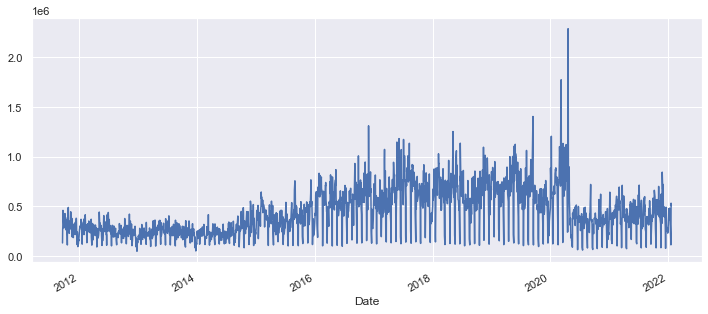

In [75]:
df_mod1['crude_oil_volume'].plot()

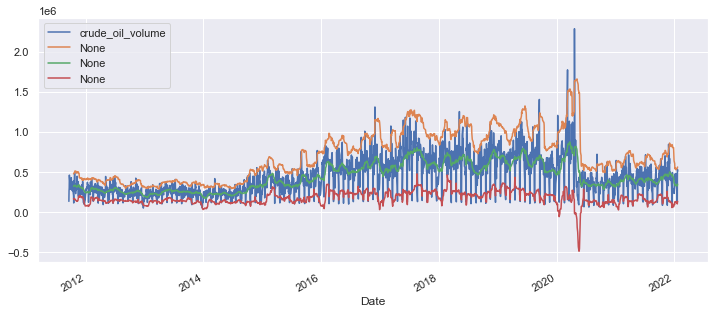

In [76]:
up_oilv_1, mid_oilv_1, low_oilv_1 = BBANDS(df_mod1['crude_oil_volume'], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

df_mod1['crude_oil_volume'].plot(figsize=(12,5))
up_oilv_1.plot(figsize=(12,5))
mid_oilv_1.plot(figsize=(12,5))
low_oilv_1.plot(figsize=(12,5))
plt.legend()

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\3641076116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod1['crude_oil_volume']=df_mod1['crude_oil_volume'].clip(upper=up_oilv_1.max())


<AxesSubplot:xlabel='Date'>

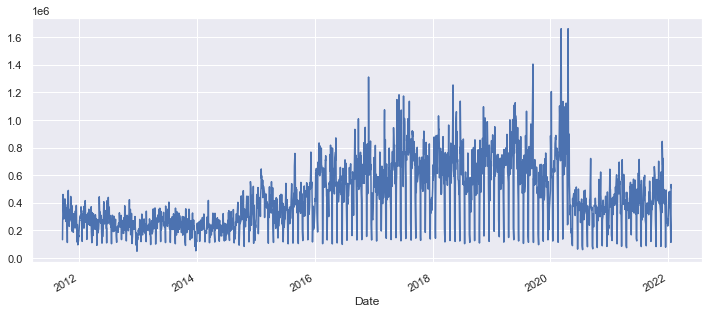

In [77]:
df_mod1['crude_oil_volume']=df_mod1['crude_oil_volume'].clip(upper=up_oilv_1.max())
df_mod1['crude_oil_volume'].plot()

- df_mod2 데이터프레임에도 동일한 처리를 해준다.

<AxesSubplot:xlabel='Date'>

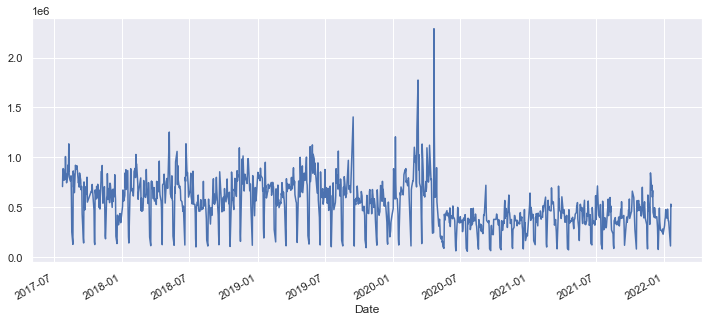

In [78]:
df_mod2['crude_oil_volume'].plot()

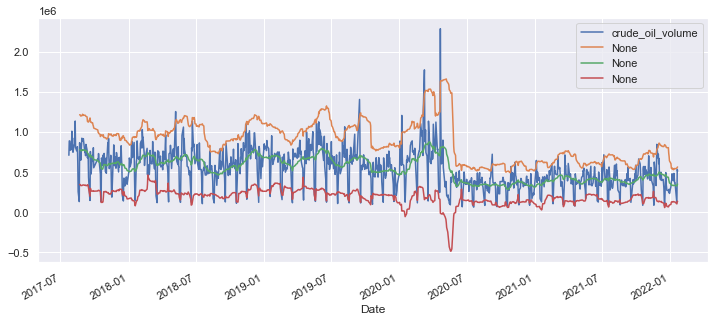

In [79]:
up_oilv_2, mid_oilv_2, low_oilv_2 = BBANDS(df_mod2['crude_oil_volume'], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

df_mod2['crude_oil_volume'].plot(figsize=(12,5))
up_oilv_2.plot(figsize=(12,5))
mid_oilv_2.plot(figsize=(12,5))
low_oilv_2.plot(figsize=(12,5))
plt.legend()

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\2520771702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod2['crude_oil_volume']=df_mod2['crude_oil_volume'].clip(upper=up_oilv_2.max())


<AxesSubplot:xlabel='Date'>

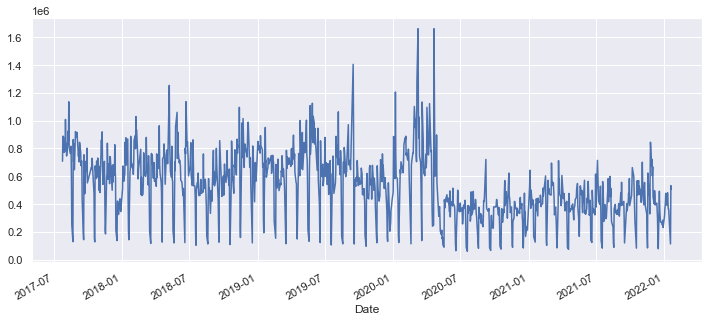

In [80]:
df_mod2['crude_oil_volume']=df_mod2['crude_oil_volume'].clip(upper=up_oilv_2.max())
df_mod2['crude_oil_volume'].plot()

- 마찬가지로, 타이거 금속 선물 거래량에도 극단값이 있으므로 제거해준다.- df_mod2 데이터프레임은 괜찮았지만 df_mod1 데이터프레임의 경우, </br>
*타이거 금속선물ETF 거래량/타이거 원유선물 거래량/KOSEF 달러선물 거래량* </br>
위 세 컬럼이 특히 outlier가 많았다. df_mod1 데이터프레임에 대해, 위 세 컬럼의 값을 winsorize 해준다.

<AxesSubplot:xlabel='Date'>

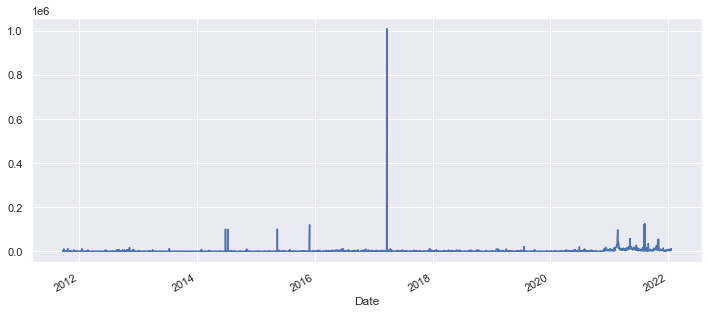

In [81]:
df_mod1['tiger_metal_volume'].plot()

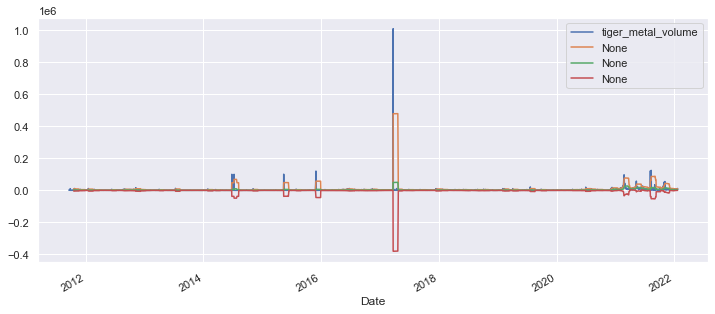

In [88]:
up_m_vol, mid_m_vol, low_m_vol = BBANDS(df_mod1['tiger_metal_volume'], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

df_mod1['tiger_metal_volume'].plot(figsize=(12,5))
up_m_vol.plot(figsize=(12,5))
mid_m_vol.plot(figsize=(12,5))
low_m_vol.plot(figsize=(12,5))
plt.legend()

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\1104798917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod1['tiger_metal_volume']=df_mod1['tiger_metal_volume'].clip(upper=up_m_vol.max())


<AxesSubplot:xlabel='Date'>

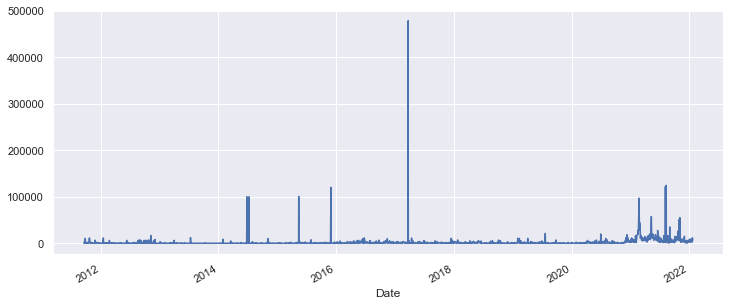

In [89]:
df_mod1['tiger_metal_volume']=df_mod1['tiger_metal_volume'].clip(upper=up_m_vol.max())
df_mod1['tiger_metal_volume'].plot()

<AxesSubplot:xlabel='Date'>

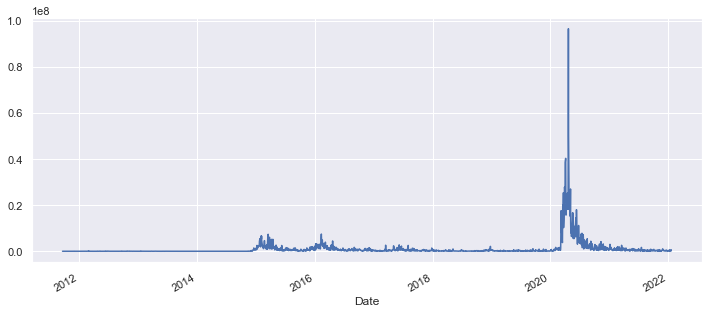

In [90]:
df_mod1['tiger_oil_volume'].plot()

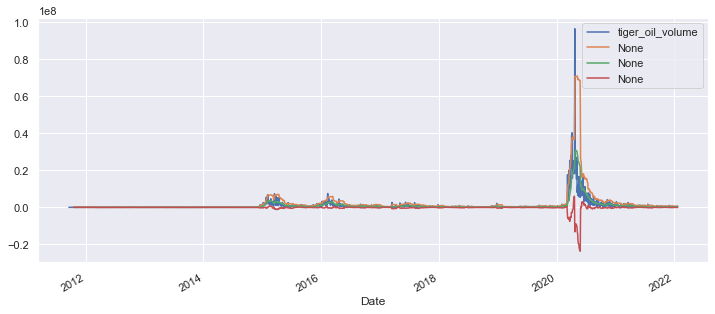

In [91]:
up_o_vol, mid_o_vol, low_o_vol = BBANDS(df_mod1['tiger_oil_volume'], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

df_mod1['tiger_oil_volume'].plot(figsize=(12,5))
up_o_vol.plot(figsize=(12,5))
mid_o_vol.plot(figsize=(12,5))
low_o_vol.plot(figsize=(12,5))
plt.legend()

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\4066844376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod1['tiger_oil_volume']=df_mod1['tiger_oil_volume'].clip(upper=up_o_vol.max())


<AxesSubplot:xlabel='Date'>

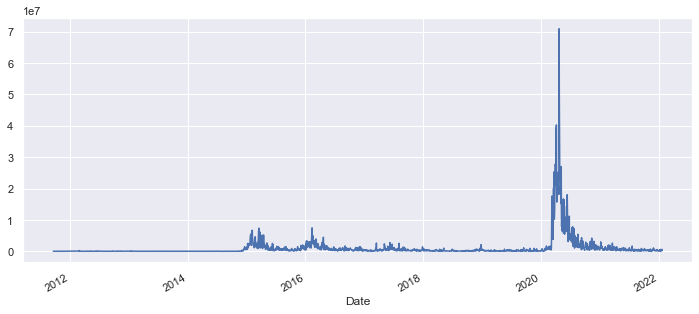

In [92]:
df_mod1['tiger_oil_volume']=df_mod1['tiger_oil_volume'].clip(upper=up_o_vol.max())
df_mod1['tiger_oil_volume'].plot()

<AxesSubplot:xlabel='Date'>

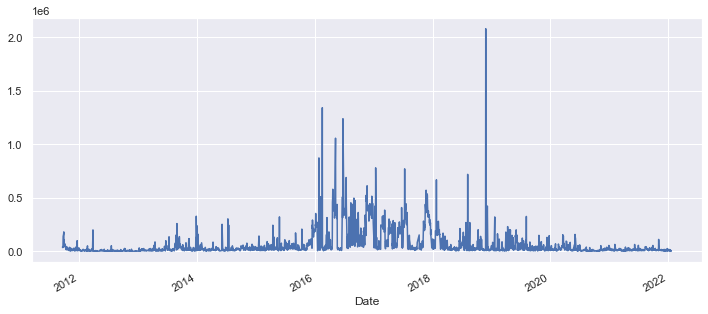

In [93]:
df_mod1['usd_f_volume'].plot()

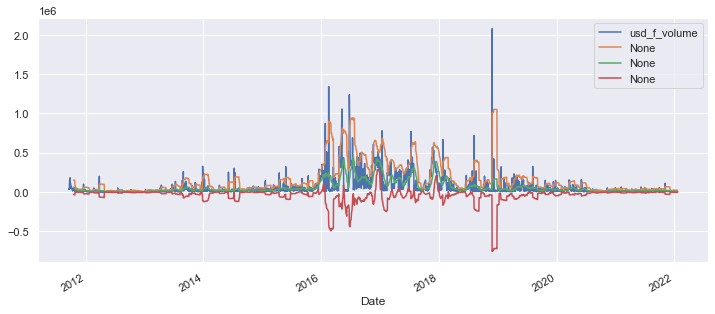

In [94]:
up_f_vol, mid_f_vol, low_f_vol = BBANDS(df_mod1['usd_f_volume'], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

df_mod1['usd_f_volume'].plot(figsize=(12,5))
up_f_vol.plot(figsize=(12,5))
mid_f_vol.plot(figsize=(12,5))
low_f_vol.plot(figsize=(12,5))
plt.legend()

C:\Users\heunjin516\AppData\Local\Temp\ipykernel_9840\1213511437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod1['usd_f_volume']=df_mod1['usd_f_volume'].clip(upper=up_f_vol.max())


<AxesSubplot:xlabel='Date'>

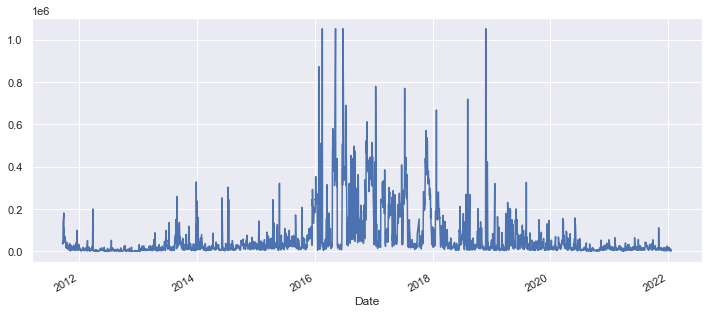

In [95]:
df_mod1['usd_f_volume']=df_mod1['usd_f_volume'].clip(upper=up_f_vol.max())
df_mod1['usd_f_volume'].plot()

In [97]:
# 중간 저장
df_mod1.to_csv(DATA_PATH+'bband_df1.csv')
df_mod2.to_csv(DATA_PATH+'bband_df2.csv')

In [118]:
# 다시 로드해오기
input_df_mod1 = pd.read_csv(DATA_PATH+'bband_df1.csv',index_col=0)
input_df_mod2 = pd.read_csv(DATA_PATH+'bband_df2.csv',index_col=0)

input_df_mod1.head()

tiger_adjclose  tiger_volume  tiger_label  sp500_adjclose  \
Date                                                                    
2011-09-19           10060         23905            1     1204.089966   
2011-09-20           10090          4621           -1     1202.089966   
2011-09-21           10050         11025           -1     1166.760010   
2011-09-22            9825         30412           -1     1129.560059   
2011-09-23            9435         25156           -1     1136.430054   

            sp500_volume  sp500_f_adjclose  sp500_f_volume  actual_growth  \
Date                                                                        
2011-09-19  4.254190e+09           1197.75       2446620.0            1.3   
2011-09-20  4.315610e+09           1196.00       2614553.0            1.3   
2011-09-21  4.728550e+09           1155.75       3254771.0            1.3   
2011-09-22  6.703140e+09           1123.50       4741905.0            1.3   
2011-09-23  5.639930e+09           1129.75       3365634.0            1.3   

            pred_growth  prev_growth  ...  WEAT_adjclose  WEAT_volume  \
Date                                  ...                               
2011-09-19          1.2          1.0  ...      24.570000        100.0   
2011-09-20          1.2          1.0  ...      24.870001       1000.0   
2011-09-21          1.2          1.0  ...      24.230000        300.0   
2011-09-22          1.2          1.0  ...      23.000000       1000.0   
2011-09-23          1.2          1.0  ...      23.559999        300.0   

            MOO_adjclose  MOO_volume  tiger_metal_close  tiger_metal_volume  \
Date                                                                          
2011-09-19     40.831242    912500.0             8755.0               629.0   
2011-09-20     40.279140   1184500.0             8485.0              1053.0   
2011-09-21     38.738174   1341600.0             8445.0               632.0   
2011-09-22     36.562710   2631200.0             8400.0               792.0   
2011-09-23     36.719284   1703400.0             7860.0              4467.0   

            tiger_oil_close  tiger_oil_volume  usd_f_close  usd_f_volume  
Date                                                                      
2011-09-19           9585.0            5659.0      11205.0       35909.0  
2011-09-20           9460.0            6436.0      11333.0       43425.0  
2011-09-21           9520.0            2726.0      11330.0       35780.0  
2011-09-22           9300.0            8987.0      11630.0       53347.0  
2011-09-23           8785.0           23406.0      11785.0      138997.0  

[5 rows x 42 columns]

In [119]:
input_df_mod2.head()

kodex_adjclose  kodex_volume  kodex_label  sp500_adjclose  \
Date                                                                    
2017-07-24           10330        249973            1     2469.909912   
2017-07-25           10470        249826           -1     2477.129883   
2017-07-26           10175        250878            1     2477.830078   
2017-07-27           10250        230167            1     2475.419922   
2017-07-28           10270        215680           -1     2472.100098   

            sp500_volume  sp500_f_adjclose  sp500_f_volume  actual_growth  \
Date                                                                        
2017-07-24  3.010240e+09           2468.50        857750.0            2.6   
2017-07-25  4.108060e+09           2474.00       1074033.0            2.6   
2017-07-26  3.557020e+09           2473.25        972444.0            2.6   
2017-07-27  3.995520e+09           2472.00       1647577.0            2.6   
2017-07-28  3.294770e+09           2470.25       1156784.0            2.6   

            pred_growth  prev_growth  ...  SOYB_volume  WEAT_adjclose  \
Date                                  ...                               
2017-07-24          2.6          1.2  ...      43800.0           7.47   
2017-07-25          2.6          1.2  ...      51700.0           7.29   
2017-07-26          2.6          1.2  ...      23600.0           7.33   
2017-07-27          2.6          1.2  ...       6700.0           7.36   
2017-07-28          2.6          1.2  ...      35100.0           7.37   

            WEAT_volume  MOO_adjclose  MOO_volume  kodex_dollar_close  \
Date                                                                    
2017-07-24     250200.0     52.905434     26300.0              9340.0   
2017-07-25     286600.0     52.961510     36400.0              9350.0   
2017-07-26     269400.0     52.961510     18500.0              9400.0   
2017-07-27     333800.0     52.886742     27600.0              9330.0   
2017-07-28     231400.0     53.036274     31600.0              9395.0   

            kodex_dollar_volume  kodex_metal_close  kodex_metal_volume  \
Date                                                                     
2017-07-24              23457.0             9846.0             12631.0   
2017-07-25               8061.0             9954.0             10877.0   
2017-07-26              24160.0            10088.0              7780.0   
2017-07-27              16537.0            10270.0             16202.0   
2017-07-28             140945.0            10219.0             16137.0   

            gsci_adjclose  
Date                       
2017-07-24          76.34  
2017-07-25          74.58  
2017-07-26          75.34  
2017-07-27          75.77  
2017-07-28          75.93  

[5 rows x 41 columns]

- 추가적으로 컬럼들을 전처리 해준다.

In [120]:
'''
real_gdp 자료 가공해주기
'''

def real_gdp_processing(df):
    temp=df
    temp['growth_pred_error'] = df['actual_growth'] - df['pred_growth']
    temp['growth_prev_diff'] = df['actual_growth'] - df['prev_growth']
    return temp

input_df_mod1 = real_gdp_processing(input_df_mod1)
input_df_mod2 = real_gdp_processing(input_df_mod2)

In [121]:
'''
wheat 선물 자료 평균처리하기 (티커가 두 개였기 때문)
'''

input_df_mod1['wheat_close']=(input_df_mod1['wheat_ke_close']+input_df_mod1['wheat_zw_close'])/2
input_df_mod1['wheat_volume']=(input_df_mod1['wheat_ke_volume']+input_df_mod1['wheat_ke_volume'])/2
input_df_mod2['wheat_close']=(input_df_mod2['wheat_ke_close']+input_df_mod2['wheat_zw_close'])/2
input_df_mod2['wheat_volume']=(input_df_mod2['wheat_ke_volume']+input_df_mod2['wheat_ke_volume'])/2

input_df_mod1.drop(['wheat_ke_close','wheat_ke_volume','wheat_zw_close','wheat_zw_volume'],axis=1,inplace=True)
input_df_mod2.drop(['wheat_ke_close','wheat_ke_volume','wheat_zw_close','wheat_zw_volume'],axis=1,inplace=True)

In [122]:

'''
이제 위 자료에서 몇몇 유의미할 것으로 예상되는 컬럼에 대해 과거 20일 이동평균을 
계산해서 추가해주자.
'''
rolling_col_tiger = ['tiger_adjclose', 'sp500_adjclose','sp500_f_adjclose',
'sugar_close','wheat_close','soybean_close', 'corn_close', 
'crude_oil_adjclose','ethanol_close','tbond_fut_adjclose',
'DBA_adjclose','CORN_adjclose','SOYB_adjclose','WEAT_adjclose','MOO_adjclose',
'usd_f_close','tiger_metal_close','tiger_oil_close']

rolling_col_kodex = ['kodex_adjclose', 'sp500_adjclose','sp500_f_adjclose',
'sugar_close','wheat_close','soybean_close', 'corn_close', 
'crude_oil_adjclose','ethanol_close','tbond_fut_adjclose',
'DBA_adjclose','CORN_adjclose','SOYB_adjclose','WEAT_adjclose','MOO_adjclose',
'kodex_dollar_close','kodex_metal_close','gsci_adjclose']

In [123]:
def rolling_mean(df,cols):
    for col in cols:
        col_name = col+"_mean"
        df[col_name]=df[col].rolling(window=20,min_periods=1).mean()
    return df

input_df_mod1 = rolling_mean(input_df_mod1, rolling_col_tiger)
input_df_mod2 = rolling_mean(input_df_mod2, rolling_col_kodex)

- 이제 lag 값을 추가한다.

In [124]:
cols=[]
lags=3
for lag in range(1,1+lags):
    col=f'lag_{lag}'
    input_df_mod1[col]=input_df_mod1['tiger_adjclose'].shift(lag)
    cols.append(col)
input_df_mod1.dropna(inplace=True)

In [125]:
cols=[]
lags=3
for lag in range(1,1+lags):
    col=f'lag_{lag}'
    input_df_mod2[col]=input_df_mod2['kodex_adjclose'].shift(lag)
    cols.append(col)
input_df_mod2.dropna(inplace=True)

In [126]:
# 중간 저장
input_df_mod1.to_csv(DATA_PATH+'lag_df1.csv')
input_df_mod2.to_csv(DATA_PATH+'lag_df2.csv')

In [50]:
# 다시 로드하기

input_df_mod1 = pd.read_csv(DATA_PATH+'lag_df1.csv',index_col=0)
input_df_mod2 = pd.read_csv(DATA_PATH+'lag_df2.csv',index_col=0)

### 정규화

- 표준정규화를 해도 괜찮은지 데이터의 분포를 찍어본다.

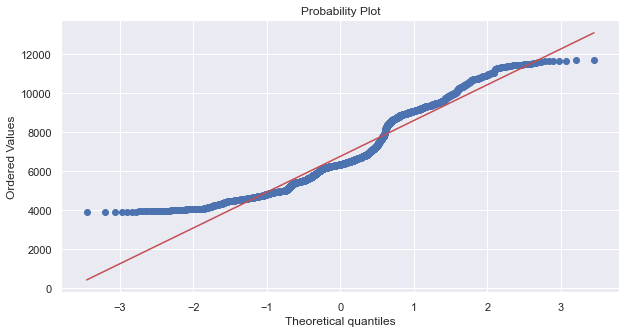

In [108]:
plt.figure(figsize=(10,5))
stats.probplot(input_df_mod1['tiger_adjclose'],dist=stats.norm,plot=plt)
plt.show()

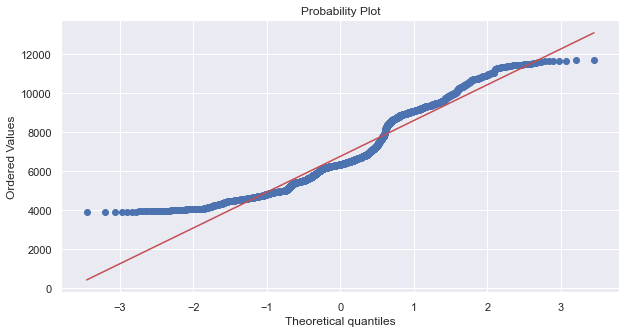

In [109]:
plt.figure(figsize=(10,5))
stats.probplot(input_df_mod1['tiger_adjclose'],dist=stats.norm,plot=plt)
plt.show()

- 두 자료 모두 꼬리부분이 불안정하나 outlier들을 제외하면 정규분포 가정에 크게 위배되지는 않는다.
- TIGER 자료(2468 rows)에 비해 KODEX 자료(1071 rows)는 길이가 더 짧기 때문에 Standard 정규화를 사용하면 Outlier에 더 큰 영향을 받을 것으로 판단된다.
- TIGER 자료는 Standard 정규화를, KODEX 자료는 Robust 정규화를 통해 정규화한다.


In [51]:
'''
정규화도 진행해보자.
'''

# Scaling 할 컬럼명 저장
df1_cols = [x for x in input_df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')
df1_cols.remove('growth_pred_error')
df1_cols.remove('growth_prev_diff')
df1_cols.remove('tiger_label')

df2_cols = [x for x in input_df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('growth_pred_error')
df2_cols.remove('growth_prev_diff')
df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

def standard_scaling_tiger(df,cols):
    scaler = preprocessing.StandardScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','tiger_label']])

def robust_scaling_kodex(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','kodex_label']])

input_df_mod1 = standard_scaling_tiger(input_df_mod1,df1_cols)
input_df_mod2 = robust_scaling_kodex(input_df_mod2,df2_cols)


# Modelling

- Train/Validation/Test dataset으로 데이터를 분할한다.

In [52]:
X_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'].drop(['tiger_label'],axis=1)
y_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'][['tiger_label']]
X_train_mod1, X_valid_mod1, y_train_mod1, y_valid_mod1 = train_test_split(X_temp_mod1, y_temp_mod1, test_size=0.1, random_state=42)
X_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'][['tiger_label']]

X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

In [53]:
# 오류 방지를 위해 y값들을 ravel() 함수로 형태를 조정해주자.
y_train_mod1 = y_train_mod1.values.ravel()
y_valid_mod1 = y_valid_mod1.values.ravel()
y_test_mod1 = y_test_mod1.values.ravel()

y_train_mod2 = y_train_mod2.values.ravel()
y_valid_mod2 = y_valid_mod2.values.ravel()
y_test_mod2 = y_test_mod2.values.ravel()

1.   TIGER ETF 데이터</br>
해당 자료는 2011-09-22 ~ 2022-01-21까지의 자료</br>
2011-09-22 ~ 2020-07-01 까지의 자료는 9:1 비율로 학습용/검증용 데이터로 random split</br>
2020-07-02 ~ 2022-01-21 까지의 자료는 테스트용 데이터로 사용</br>

2.   KODEX ETF 데이터</br>
해당 자료는 2017-07-27 ~ 2022-01-21까지의 자료</br>
2017-07-27 ~ 2020-12-31 까지의 자료는 9:1 비율로 학습용/검증용 데이터로 random split</br>
2021-01-01 ~ 2022-01-21 까지의 자료는 테스트용 데이터로 사용</br>


### 1. Basic Model

#### (No HPO, Early Stopping : 25)

c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Model F1 Score :  0.5707865168539326


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

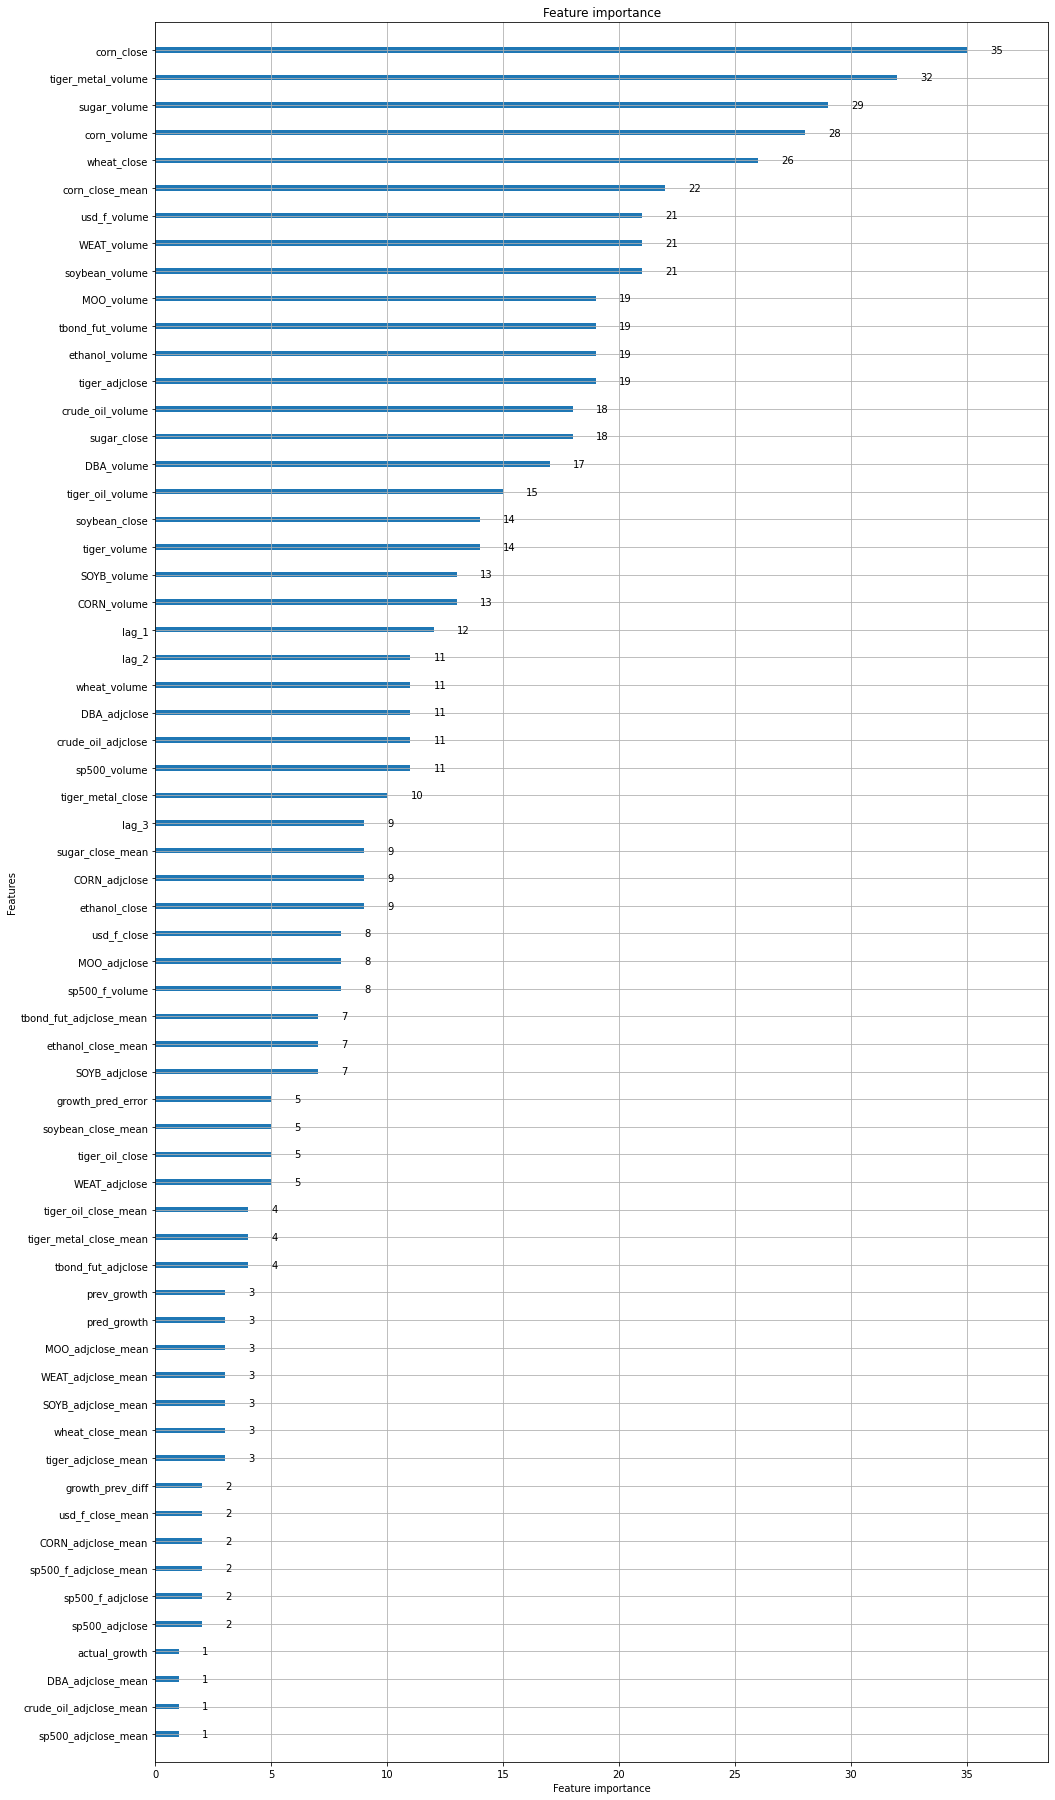

In [54]:
lgb_model1 = LGBMClassifier()

lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32),ignore_zero=False)

c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Model F1 Score :  0.6525198938992042


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

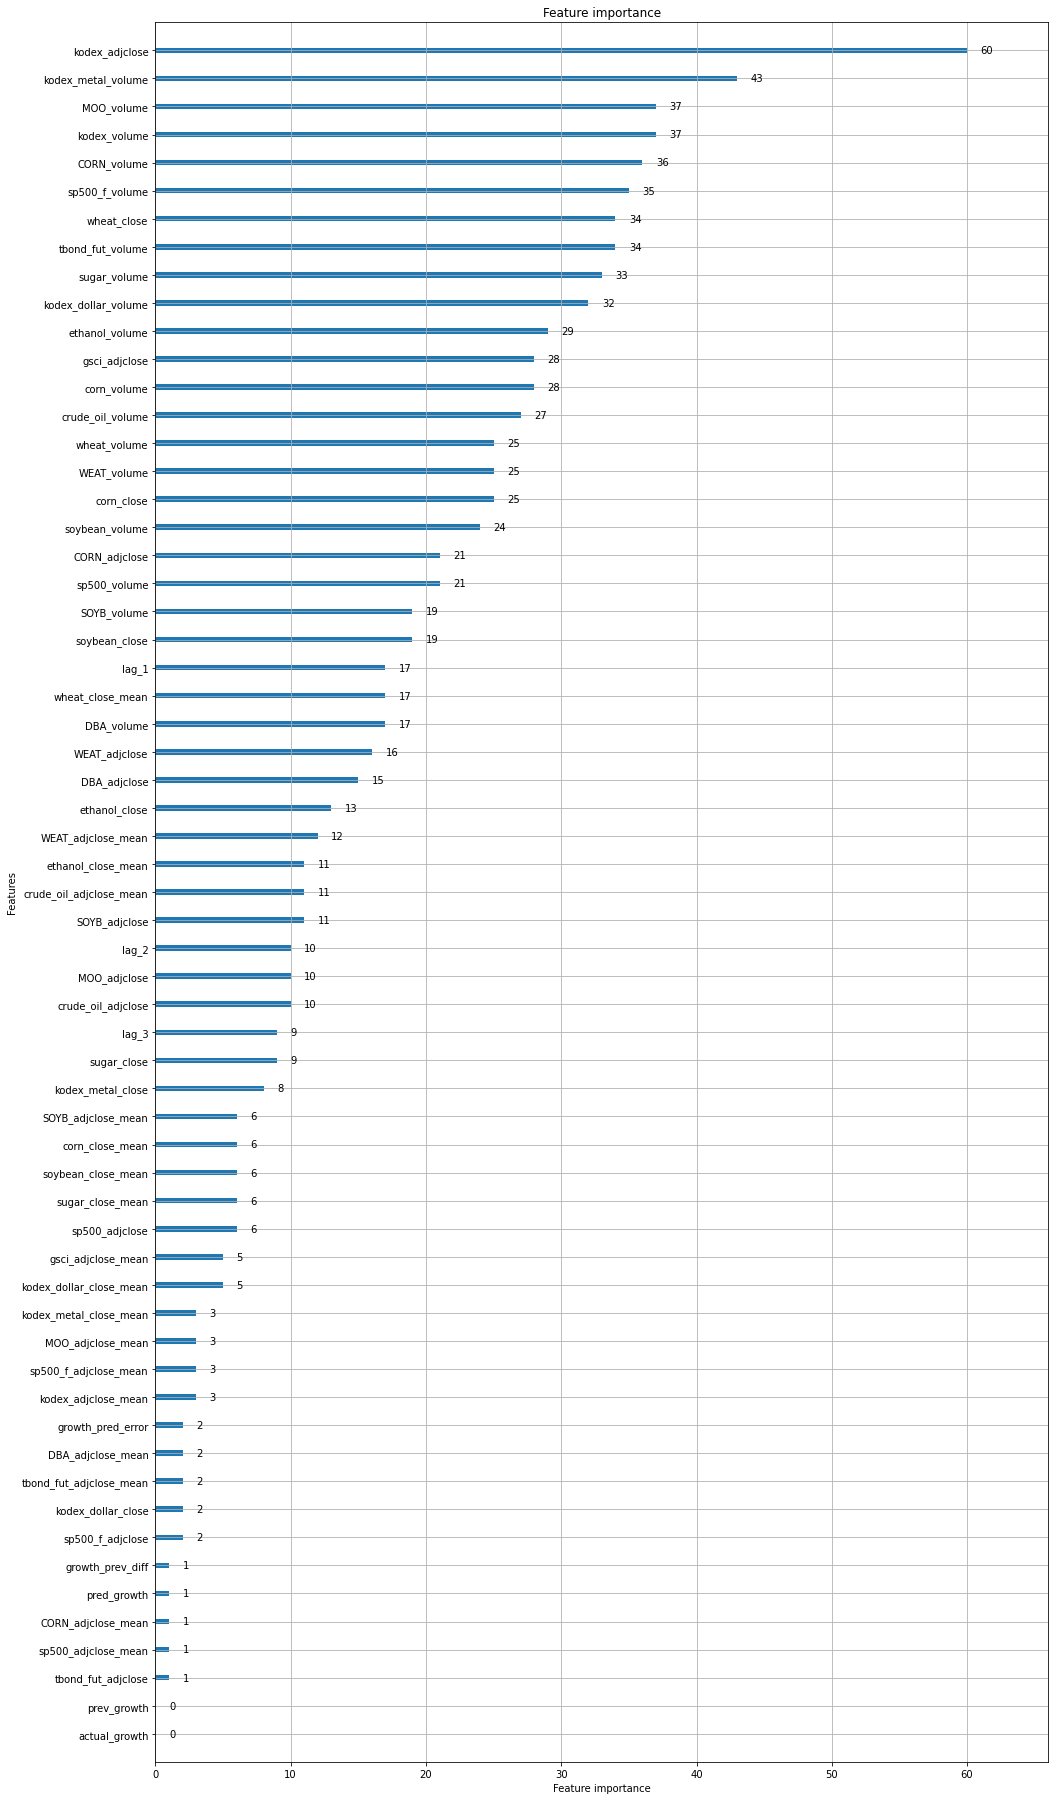

In [55]:
lgb_model2 = LGBMClassifier()

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

### 2. GridSearchCV Model

#### (GridSearchCV 이용, Early Stopping : 25)

In [57]:
params_mod = {
    'max_depth': (1, 20), 
    'num_leaves': (10,40), 
    'min_child_samples': (10, 170), 
    'min_child_weight':(0.0001, 20),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_lambda':(0, 20),
    'reg_alpha': (0, 50) 
}
tuner_mod1 = GridSearchCV(lgb_model1,params_mod,n_jobs=multiprocessing.cpu_count(),verbose=True)
tuner_mod1.fit(X_train_mod1,np.array(y_train_mod1).ravel())
print(tuner_mod1.best_params_)

tuner_mod2 = GridSearchCV(lgb_model2,params_mod,n_jobs=multiprocessing.cpu_count(),verbose=True)
tuner_mod2.fit(X_train_mod2,np.array(y_train_mod2).ravel())
print(tuner_mod2.best_params_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'colsample_bytree': 0.5, 'max_depth': 20, 'min_child_samples': 10, 'min_child_weight': 20, 'num_leaves': 40, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'colsample_bytree': 1.0, 'max_depth': 20, 'min_child_samples': 10, 'min_child_weight': 20, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Model F1 Score :  0.6124197002141327


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

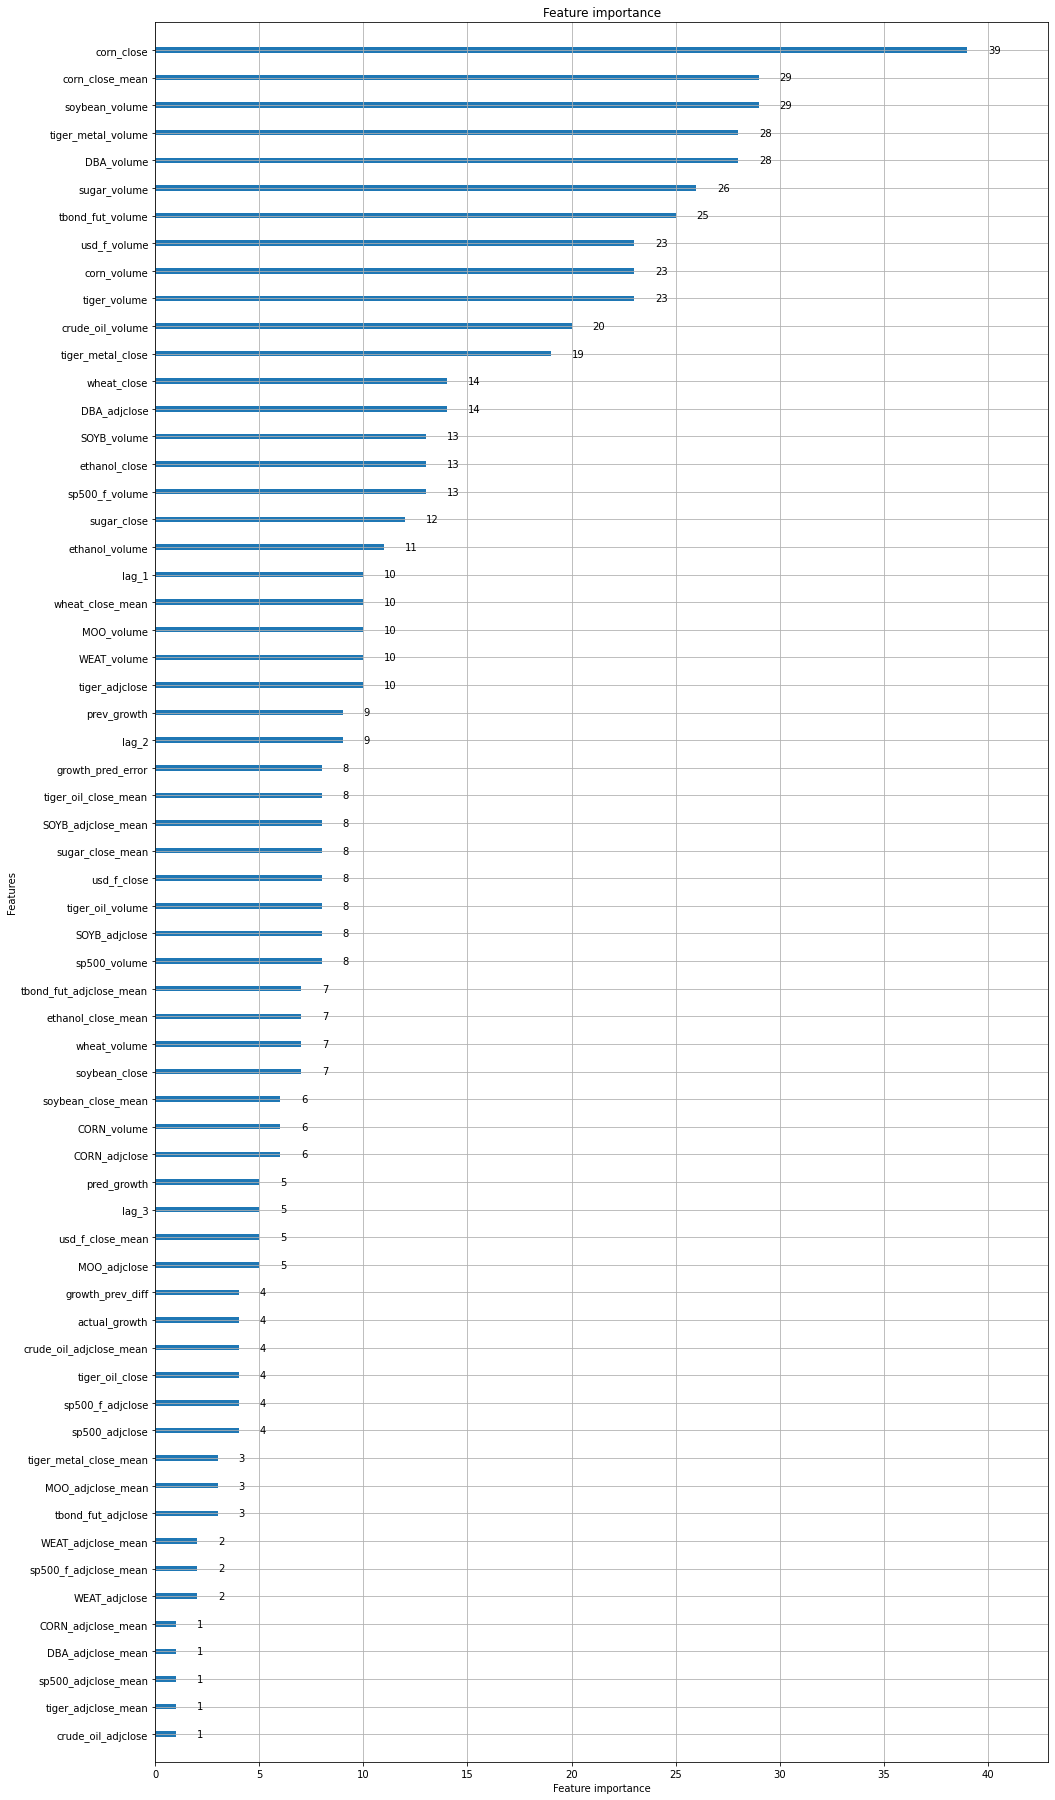

In [58]:
lgb_model1 = LGBMClassifier(**tuner_mod1.best_params_)

lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 50)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32),ignore_zero=False)

Model F1 Score :  0.6525198938992042


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

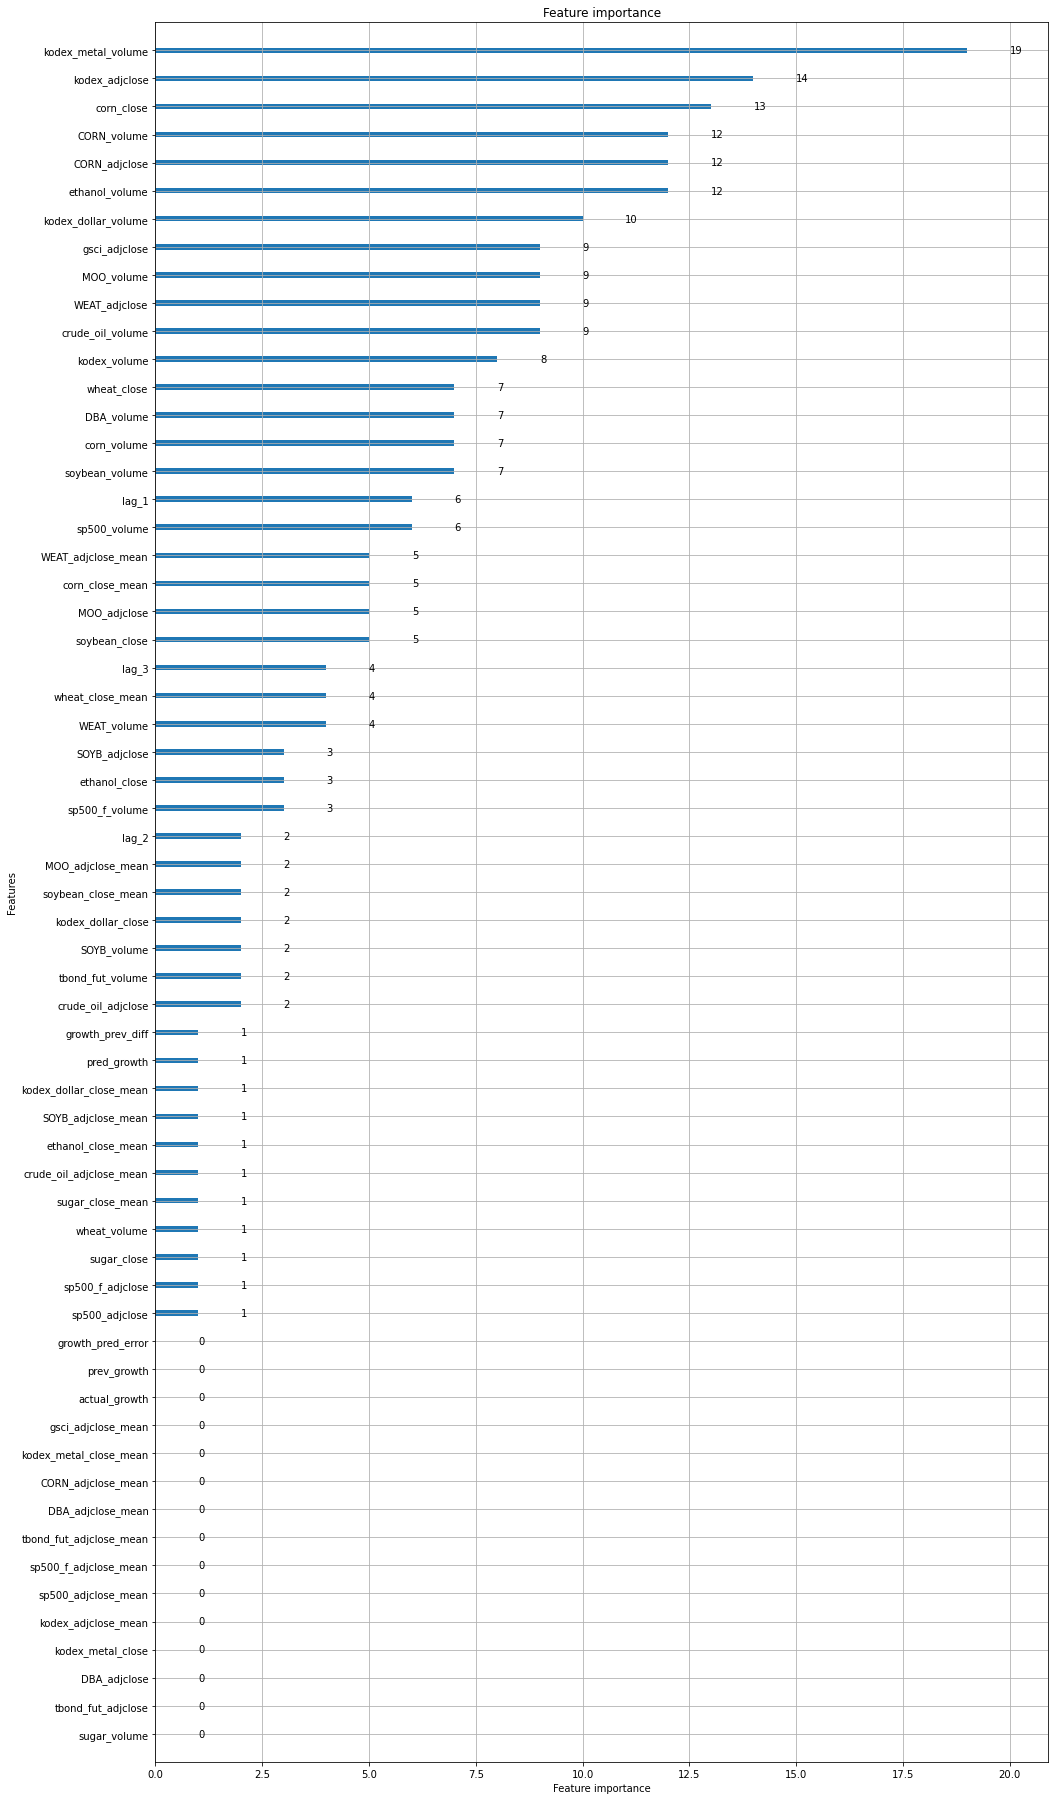

In [59]:
lgb_model2 = LGBMClassifier(**tuner_mod2.best_params_)

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

### 3. GridSearchCV Model - drop model
`피쳐 임포턴스 하위 5개(GridSearchCV 기준) 혹은 FI 0인 컬럼 제거`

#### (GridSearchCV 이용, Early Stopping : 25)

In [60]:
input_df_mod1 = pd.read_csv(DATA_PATH+'lag_df1.csv',index_col=0)
input_df_mod2 = pd.read_csv(DATA_PATH+'lag_df2.csv',index_col=0)

# Scaling 할 컬럼명 저장
df1_cols = [x for x in input_df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')
df1_cols.remove('growth_pred_error')
df1_cols.remove('growth_prev_diff')
df1_cols.remove('tiger_label')

df2_cols = [x for x in input_df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('growth_pred_error')
df2_cols.remove('growth_prev_diff')
df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

def standard_scaling_tiger(df,cols):
    scaler = preprocessing.StandardScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','tiger_label']])

def robust_scaling_kodex(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','kodex_label']])

input_df_mod1 = standard_scaling_tiger(input_df_mod1,df1_cols)
input_df_mod2 = robust_scaling_kodex(input_df_mod2,df2_cols)


- Feature Importance 하위 5개 or FI 0인 컬럼을 제거해주자.

In [61]:
input_df_mod1.drop(['CORN_adjclose_mean','DBA_adjclose_mean','sp500_adjclose_mean','tiger_adjclose_mean','crude_oil_adjclose'],axis=1,inplace=True)
input_df_mod2.drop(['growth_pred_error', 'prev_growth', 'actual_growth', 'gsci_adjclose_mean', 'kodex_metal_close_mean', 'CORN_adjclose_mean', 'DBA_adjclose_mean', 'tbond_fut_adjclose_mean', 'sp500_f_adjclose_mean', 'sp500_adjclose_mean', 'kodex_adjclose_mean', 'kodex_metal_close', 'DBA_adjclose', 'tbond_fut_adjclose', 'sugar_volume'],axis=1,inplace=True)

In [62]:
X_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'].drop(['tiger_label'],axis=1)
y_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'][['tiger_label']]
X_train_mod1, X_valid_mod1, y_train_mod1, y_valid_mod1 = train_test_split(X_temp_mod1, y_temp_mod1, test_size=0.1, random_state=42)
X_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'][['tiger_label']]

X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

In [63]:
# 오류 방지를 위해 y값들을 ravel() 함수로 형태를 조정해주자.
y_train_mod1 = y_train_mod1.values.ravel()
y_valid_mod1 = y_valid_mod1.values.ravel()
y_test_mod1 = y_test_mod1.values.ravel()

y_train_mod2 = y_train_mod2.values.ravel()
y_valid_mod2 = y_valid_mod2.values.ravel()
y_test_mod2 = y_test_mod2.values.ravel()

c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Model F1 Score :  0.6716981132075471


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

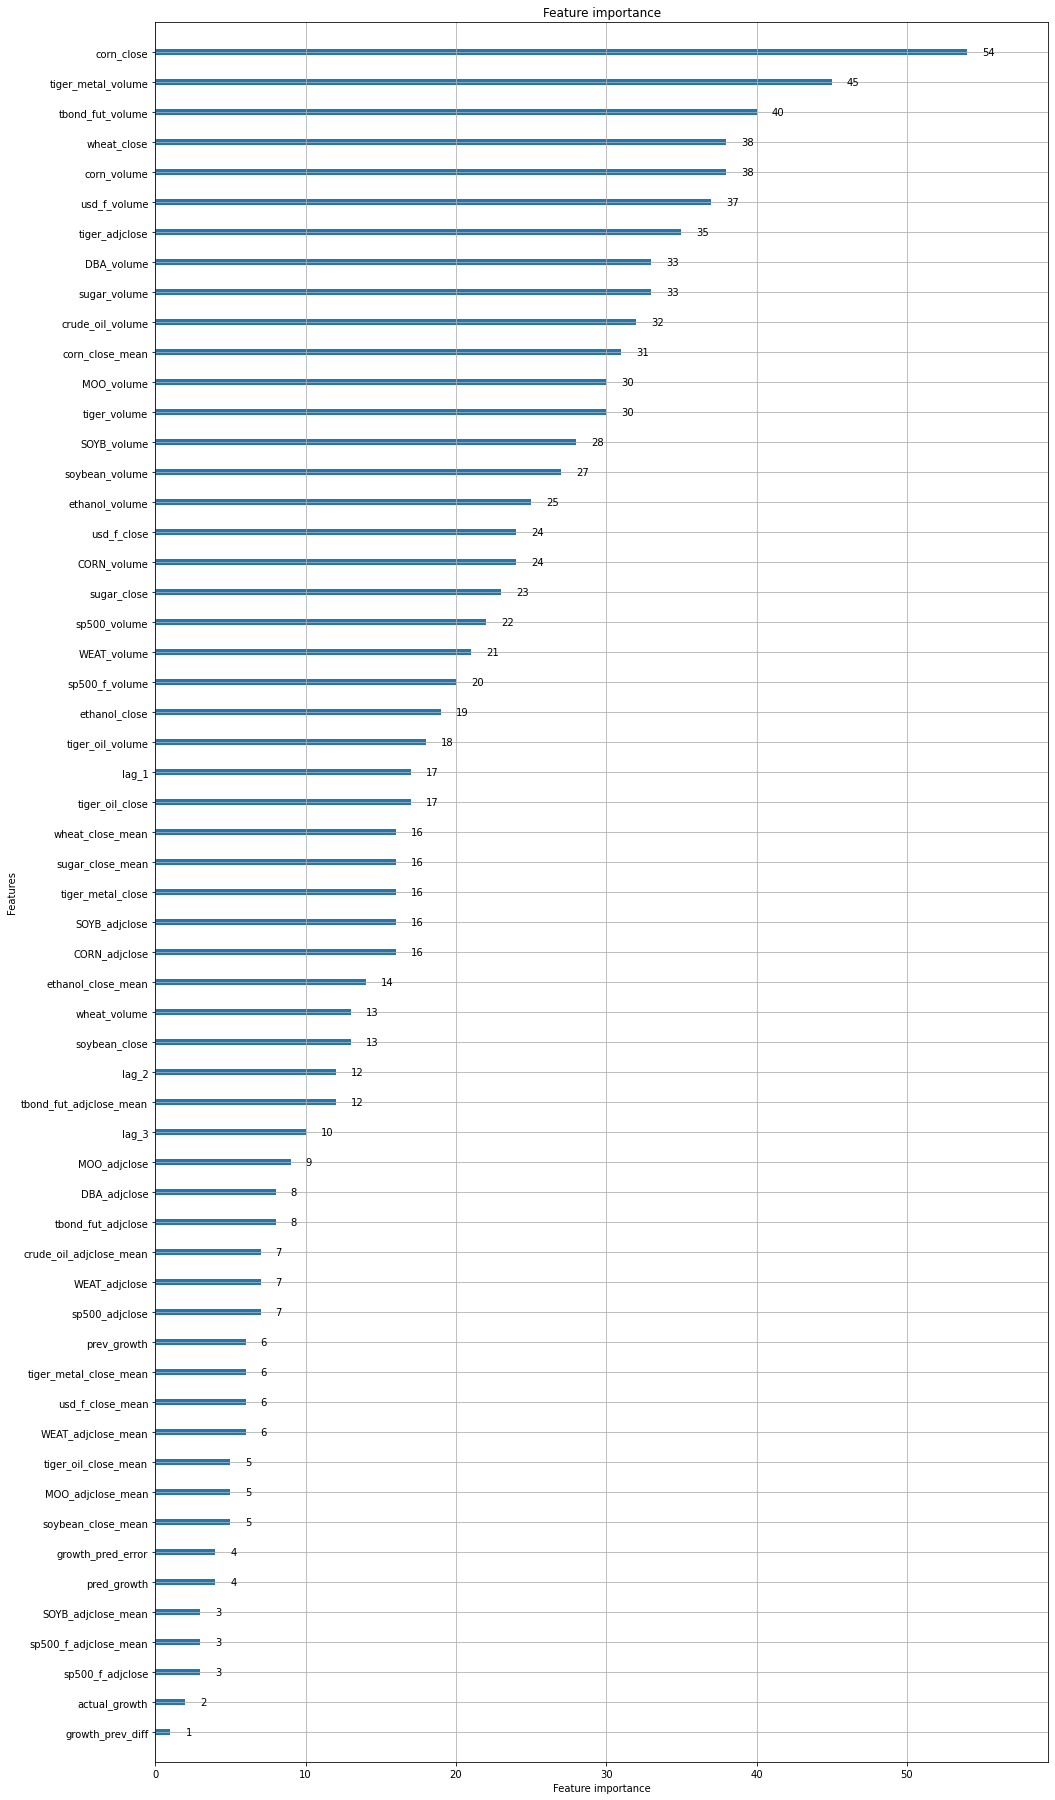

In [64]:
lgb_model1 = LGBMClassifier()

lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32),ignore_zero=False)

Model F1 Score :  0.6525198938992042


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

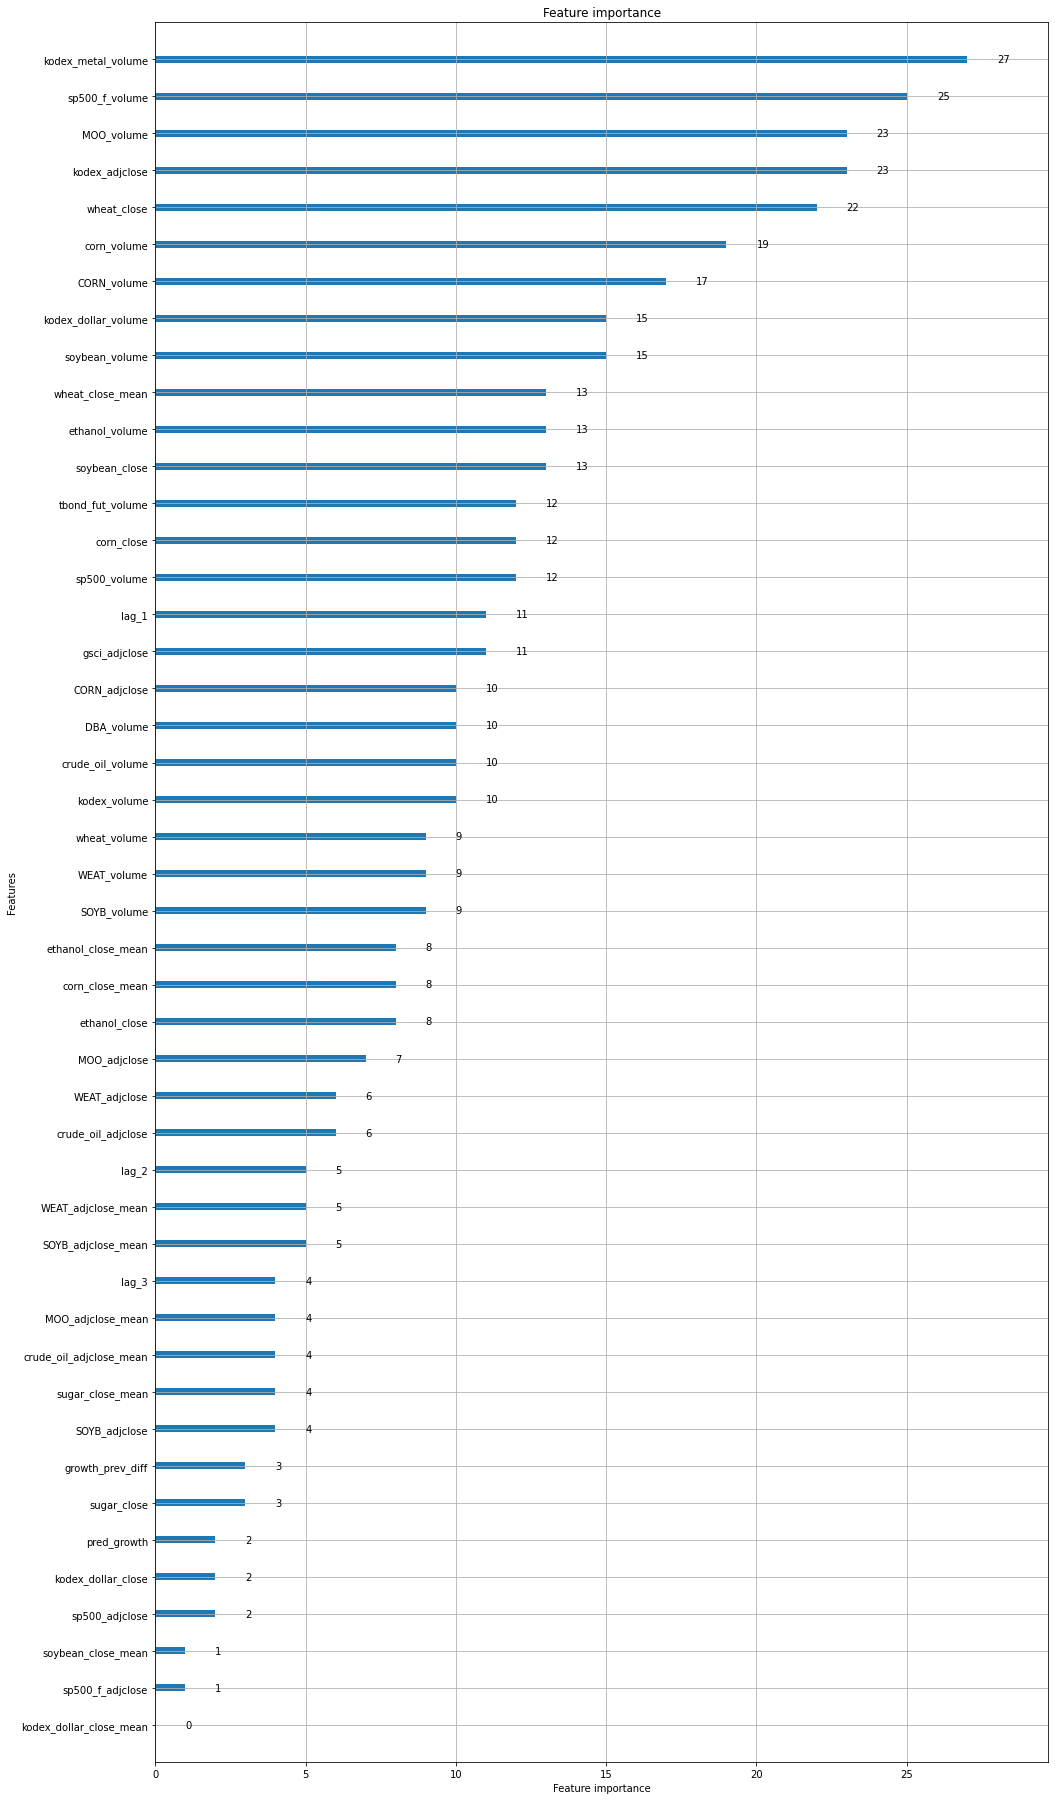

In [65]:
lgb_model2 = LGBMClassifier()

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds=25)
preds_mod2 = lgb_model2.predict(X_test_mod2,axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

### 4. Bayesian Opt Model

#### (BayesianOptimization 이용, Early Stopping : 25)

In [113]:
input_df_mod1 = pd.read_csv(DATA_PATH+'lag_df1.csv',index_col=0)
input_df_mod2 = pd.read_csv(DATA_PATH+'lag_df2.csv',index_col=0)

# Scaling 할 컬럼명 저장
df1_cols = [x for x in input_df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')
df1_cols.remove('growth_pred_error')
df1_cols.remove('growth_prev_diff')
df1_cols.remove('tiger_label')

df2_cols = [x for x in input_df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('growth_pred_error')
df2_cols.remove('growth_prev_diff')
df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

def standard_scaling_tiger(df,cols):
    scaler = preprocessing.StandardScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','tiger_label']])

def robust_scaling_kodex(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','kodex_label']])

input_df_mod1 = standard_scaling_tiger(input_df_mod1,df1_cols)
input_df_mod2 = robust_scaling_kodex(input_df_mod2,df2_cols)

input_df_mod1.drop(['sp500_adjclose', 'actual_growth', 'DBA_adjclose_mean', 'crude_oil_adjclose_mean', 'sp500_adjclose_mean'],axis=1,inplace=True)
input_df_mod2.drop(['CORN_adjclose_mean', 'sp500_adjclose_mean', 'tbond_fut_adjclose', 'prev_growth', 'actual_growth'],axis=1,inplace=True)

# 앞으로 사용할 데이터프레임 저장!
input_df_mod1.to_csv(DATA_PATH+'input_df_mod1.csv')
input_df_mod2.to_csv(DATA_PATH+'input_df_mod2.csv')

In [114]:
# 다시 데이터프레임 불러오기
input_df_mod1 = pd.read_csv(DATA_PATH+'input_df_mod1.csv',index_col=0)
input_df_mod2 = pd.read_csv(DATA_PATH+'input_df_mod2.csv',index_col=0)

In [115]:
X_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'].drop(['tiger_label'],axis=1)
y_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'][['tiger_label']]
X_train_mod1, X_valid_mod1, y_train_mod1, y_valid_mod1 = train_test_split(X_temp_mod1, y_temp_mod1, test_size=0.1, random_state=42)
X_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'][['tiger_label']]

X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

# 오류 방지를 위해 y값들을 ravel() 함수로 형태를 조정해주자.
y_train_mod1 = y_train_mod1.values.ravel()
y_valid_mod1 = y_valid_mod1.values.ravel()
y_test_mod1 = y_test_mod1.values.ravel()

y_train_mod2 = y_train_mod2.values.ravel()
y_valid_mod2 = y_valid_mod2.values.ravel()
y_test_mod2 = y_test_mod2.values.ravel()

In [116]:
bayesian_params = {
    "n_estimators":(400,1000),
    "learning_rate":(0.005,0.04),
    'max_depth': (10, 70), 
    'num_leaves': (10, 500), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 550),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 7) 
}

In [117]:
def lgb_f1_eval_mod1(n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)),
        "learning_rate":max(min(learning_rate, 1), 0),
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model1 = LGBMClassifier(**params)
    lgb_model1.fit(X_train_mod1, y_train_mod1, 
                eval_set=[(X_valid_mod1, y_valid_mod1)],
                eval_metric= 'f1', verbose=100,
                early_stopping_rounds= 25)
    test_pred = lgb_model1.predict(X_test_mod1)
    f1_mod1 = f1_score(y_test_mod1, test_pred)
    
    return f1_mod1

In [118]:
def lgb_f1_eval_mod2(n_estimators,learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)),
        "learning_rate":max(min(learning_rate, 1), 0),
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model2 = LGBMClassifier(**params)
    lgb_model2.fit(X_train_mod2, y_train_mod2, 
                eval_set=[(X_valid_mod2, y_valid_mod2)],
                eval_metric= 'f1', verbose=100,
                early_stopping_rounds= 25)
    test_pred = lgb_model2.predict(X_test_mod2)
    f1_mod2 = f1_score(y_test_mod2, test_pred)
    
    return f1_mod2

In [119]:
def change_values(n_estimators,learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)),
        "learning_rate":max(min(learning_rate, 1), 0),
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    return params

In [120]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO_mod1 = BayesianOptimization(lgb_f1_eval_mod1,bayesian_params, random_state=42)
lgbBO_mod2 = BayesianOptimization(lgb_f1_eval_mod2,bayesian_params, random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO_mod1.maximize(init_points=5, n_iter=25)
lgbBO_mod2.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.678401
|  1        |  0.6767   |  0.6873   |  0.03828  |  405.3    |  45.92    |  39.64    |  8.644    |  434.9    |  434.4    |  4.212    |  7.081    |  0.5103   |
|  2        |  0.0      |  0.985    |  0.03414  |  124.7    |  20.91    |  44.85    |  15.91    |  714.9    |  221.7    |  2.046    |  6.119    |  0.5697   |
|  3        |  0.5714   |  0.6461   |  0.01782  |  256.3    |  57.11    |  47.94    |  26.2     |  755.4    |  32.76    |  4.257    |  1.706    |  0.5325   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.678574
|  4        |  0.6343   |  0.9744   |  0.0388   |  446.5    |  28.28    |  28.56    |  34.53    |  664.1    |  69.8     |  3.471    |  0.3449   |  0.9547   |
[100]	valid_0's binary_logloss: 0.682401
|  5        |  0.6242   |  0.6294   |  0.02819  |  178.3    |  41.2     |  113.9    |  10.06    |  981.8    |  389.8    |  6.577    |  8.948    |  0.7989   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.679237
|  6        |  0.6318   |  0.6359   |  0.03257  |  404.5    |  27.48    |  91.49    |  32.78    |  715.3    |  233.5    |  0.7098   |  4.35     |  0.9961   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.681003
|  7        |  0.6311   |  0.5097   |  0.03127  |  407.0    |  38.18    |  83.38    |  40.33    |  494.1    |  372.8    |  0.1979   |  9.081    |  0.9761   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.681615
[200]	valid_0's binary_logloss: 0.675602
[300]	valid_0's binary_logloss: 0.671379
|  8        |  0.6293   |  1.0      |  0.005    |  550.0    |  70.0     |  10.0     |  1.0      |  589.1    |  261.8    |  7.0      |  0.001    |  0.5      |
[100]	valid_0's binary_logloss: 0.68243
[200]	valid_0's binary_logloss: 0.67874
|  9        |  0.5629   |  0.751    |  0.03537  |  210.8    |  37.36    |  170.4    |  1.916    |  865.2    |  205.0    |  4.571    |  5.919    |  0.7251   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.688714
[200]	valid_0's binary_logloss: 0.685281
[300]	valid_0's binary_logloss: 0.682382
[400]	valid_0's binary_logloss: 0.680191
|  10       |  0.5025   |  0.8664   |  0.01108  |  411.6    |  33.71    |  74.75    |  41.63    |  494.0    |  395.2    |  4.052    |  7.319    |  0.9002   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  11       |  0.0      |  0.8816   |  0.006448 |  378.8    |  52.72    |  27.88    |  26.82    |  409.2    |  405.8    |  6.947    |  8.164    |  0.5976   |
[100]	valid_0's binary_logloss: 0.679768
|  12       |  0.6067   |  0.842    |  0.0202   |  411.9    |  28.47    |  97.8     |  11.48    |  708.8    |  231.0    |  1.728    |  2.87     |  0.94     |
[100]	valid_0's binary_logloss: 0.686441


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's binary_logloss: 0.680923
[300]	valid_0's binary_logloss: 0.678059
|  13       |  0.6132   |  0.5345   |  0.009463 |  183.1    |  50.69    |  112.8    |  12.29    |  987.2    |  366.3    |  0.1553   |  2.524    |  0.5581   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.681384
[200]	valid_0's binary_logloss: 0.675604
|  14       |  0.6528   |  0.81     |  0.01434  |  449.0    |  50.11    |  43.66    |  6.11     |  431.8    |  431.6    |  4.391    |  8.453    |  0.6433   |
|  15       |  0.5794   |  0.607    |  0.01076  |  253.0    |  52.4     |  47.21    |  22.53    |  766.2    |  30.84    |  5.322    |  1.816    |  0.8397   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.68198
[200]	valid_0's binary_logloss: 0.675469
|  16       |  0.6849   |  0.5369   |  0.01557  |  404.4    |  57.83    |  50.49    |  16.58    |  424.5    |  489.7    |  1.161    |  5.208    |  0.9619   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


|  17       |  0.6627   |  0.5      |  0.04     |  420.4    |  32.8     |  39.1     |  1.0      |  459.6    |  468.3    |  0.01     |  5.667    |  0.5      |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.687661
[200]	valid_0's binary_logloss: 0.682329
[300]	valid_0's binary_logloss: 0.679522
[400]	valid_0's binary_logloss: 0.677694
|  18       |  0.6808   |  0.6407   |  0.008016 |  417.8    |  13.75    |  69.43    |  15.01    |  424.3    |  462.5    |  2.638    |  7.668    |  0.8757   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  19       |  0.0      |  0.5519   |  0.005966 |  255.1    |  21.53    |  112.6    |  29.23    |  983.3    |  83.54    |  6.6      |  3.295    |  0.5937   |
[100]	valid_0's binary_logloss: 0.685902
[200]	valid_0's binary_logloss: 0.680159
[300]	valid_0's binary_logloss: 0.67817
|  20       |  0.5752   |  0.797    |  0.01053  |  375.1    |  27.62    |  134.5    |  36.69    |  510.2    |  327.9    |  1.624    |  3.957    |  0.6157   |
|  21       |  0.5642   |  0.5863   |  0.008753 |  207.4    |  23.23    |  165.9    |  6.104    |  872.5    |  214.4    |  0.5063   |  4.49     |  0.5324   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.677634
|  22       |  0.6691   |  0.5      |  0.04     |  444.4    |  62.59    |  85.58    |  23.84    |  514.3    |  316.6    |  0.01     |  10.0     |  1.0      |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.681886
[200]	valid_0's binary_logloss: 0.673234
|  23       |  0.5459   |  0.5      |  0.04     |  392.5    |  47.84    |  54.77    |  50.0     |  549.0    |  316.5    |  0.01     |  10.0     |  1.0      |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.680817
|  24       |  0.6496   |  0.5      |  0.04     |  439.3    |  68.16    |  129.8    |  1.0      |  475.9    |  358.3    |  0.01     |  10.0     |  1.0      |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.682024
|  25       |  0.5966   |  0.8488   |  0.03751  |  389.5    |  61.11    |  136.9    |  5.412    |  453.0    |  489.1    |  2.48     |  0.203    |  0.8828   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


|  26       |  0.7031   |  0.8134   |  0.03484  |  390.4    |  67.54    |  64.3     |  16.29    |  965.3    |  301.6    |  4.416    |  3.316    |  0.6185   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.683868
[200]	valid_0's binary_logloss: 0.677572
[300]	valid_0's binary_logloss: 0.673842
|  27       |  0.4762   |  0.9427   |  0.02092  |  389.0    |  52.6     |  94.69    |  40.04    |  910.3    |  306.0    |  2.405    |  5.208    |  0.7338   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.681166
|  28       |  0.6495   |  0.7067   |  0.03939  |  431.4    |  57.28    |  38.23    |  24.69    |  973.1    |  265.2    |  6.318    |  7.233    |  0.8264   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  29       |  0.09865  |  0.992    |  0.005674 |  355.2    |  48.78    |  31.7     |  47.27    |  990.8    |  271.6    |  0.6344   |  5.651    |  0.9667   |
[100]	valid_0's binary_logloss: 0.680733
|  30       |  0.6732   |  0.6843   |  0.02107  |  178.4    |  62.61    |  110.5    |  11.95    |  990.7    |  359.0    |  1.548    |  3.932    |  0.8032   |
|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.674759
|  1        |  0.6316   |  0.6873   |  0.03828  |  405.3    |  45.92    |  39.64    |  8.644    |  434.9    |  434.4    |  4.212    |  7.081    |  0.5103   |
[100]	valid_0's binary_logloss: 0.666948
[200]	valid_0's binary_logloss: 0.649687
|  2        |  0.6376   |  0.985    |  0.03414  |  124.7    |  20.91    |  44.85    |  15.91    |  714.9    |  221.7    |  2.046    |  6.119    |  0.5697   |
[100]	valid_0's binary_logloss: 0.675072


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[200]	valid_0's binary_logloss: 0.662727
[300]	valid_0's binary_logloss: 0.657659
[400]	valid_0's binary_logloss: 0.65723
|  3        |  0.6543   |  0.6461   |  0.01782  |  256.3    |  57.11    |  47.94    |  26.2     |  755.4    |  32.76    |  4.257    |  1.706    |  0.5325   |
[100]	valid_0's binary_logloss: 0.668242
[200]	valid_0's binary_logloss: 0.664428
|  4        |  0.6489   |  0.9744   |  0.0388   |  446.5    |  28.28    |  28.56    |  34.53    |  664.1    |  69.8     |  3.471    |  0.3449   |  0.9547   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.67868
[200]	valid_0's binary_logloss: 0.672298
[300]	valid_0's binary_logloss: 0.668932
|  5        |  0.6525   |  0.6294   |  0.02819  |  178.3    |  41.2     |  113.9    |  10.06    |  981.8    |  389.8    |  6.577    |  8.948    |  0.7989   |
[100]	valid_0's binary_logloss: 0.686146
[200]	valid_0's binary_logloss: 0.680166
[300]	valid_0's binary_logloss: 0.675066
[400]	valid_0's binary_logloss: 0.67098
[500]	valid_0's binary_logloss: 0.668705
[600]	valid_0's binary_logloss: 0.666281
[700]	valid_0's binary_logloss: 0.663251
|  6        |  0.6525   |  0.5255   |  0.006748 |  308.0    |  20.67    |  56.02    |  10.03    |  749.0    |  37.22    |  6.581    |  1.232    |  0.9758   |
[100]	valid_0's binary_logloss: 0.680996


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's binary_logloss: 0.677583
[300]	valid_0's binary_logloss: 0.673235
|  7        |  0.656    |  0.611    |  0.01949  |  283.2    |  68.73    |  127.7    |  31.9     |  998.2    |  27.65    |  6.1      |  7.91     |  0.5236   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.679417
[200]	valid_0's binary_logloss: 0.67473
[300]	valid_0's binary_logloss: 0.671602
[400]	valid_0's binary_logloss: 0.668832
|  8        |  0.6525   |  0.5      |  0.04     |  522.8    |  70.0     |  200.0    |  50.0     |  1e+03    |  165.4    |  0.01     |  10.0     |  0.5      |
[100]	valid_0's binary_logloss: 0.677666
[200]	valid_0's binary_logloss: 0.672772
[300]	valid_0's binary_logloss: 0.670044
[400]	valid_0's binary_logloss: 0.664589
|  9        |  0.6525   |  0.751    |  0.03537  |  210.8    |  37.36    |  170.4    |  1.916    |  865.2    |  205.0    |  4.571    |  5.919    |  0.7251   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.68569
[200]	valid_0's binary_logloss: 0.682707
[300]	valid_0's binary_logloss: 0.68078
[400]	valid_0's binary_logloss: 0.679791
[500]	valid_0's binary_logloss: 0.678293
|  10       |  0.6507   |  0.8021   |  0.01097  |  27.1     |  48.65    |  155.7    |  24.6     |  996.4    |  11.91    |  6.755    |  4.085    |  0.657    |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.673475
[200]	valid_0's binary_logloss: 0.66541
|  11       |  0.6489   |  0.9574   |  0.03266  |  531.8    |  41.91    |  120.0    |  35.86    |  999.5    |  483.2    |  5.053    |  6.649    |  0.6186   |
[100]	valid_0's binary_logloss: 0.685144
[200]	valid_0's binary_logloss: 0.682623
[300]	valid_0's binary_logloss: 0.679243
[400]	valid_0's binary_logloss: 0.677351
[500]	valid_0's binary_logloss: 0.675233
[600]	valid_0's binary_logloss: 0.673363
[700]	valid_0's binary_logloss: 0.672316
|  12       |  0.6525   |  0.6106   |  0.008596 |  104.1    |  27.53    |  115.7    |  33.39    |  764.9    |  36.8     |  6.058    |  1.218    |  0.823    |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.682978
[200]	valid_0's binary_logloss: 0.678721
[300]	valid_0's binary_logloss: 0.675113
[400]	valid_0's binary_logloss: 0.673199
|  13       |  0.6525   |  0.7429   |  0.01982  |  325.3    |  65.79    |  194.2    |  34.3     |  845.3    |  11.94    |  2.835    |  5.957    |  0.9936   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.668395
[200]	valid_0's binary_logloss: 0.663646
|  14       |  0.6525   |  1.0      |  0.04     |  489.7    |  70.0     |  10.0     |  14.52    |  978.2    |  10.0     |  7.0      |  0.001    |  0.5      |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.678192
[200]	valid_0's binary_logloss: 0.666845
[300]	valid_0's binary_logloss: 0.660109
[400]	valid_0's binary_logloss: 0.655307
|  15       |  0.6434   |  0.6282   |  0.01409  |  300.1    |  59.57    |  37.38    |  22.44    |  994.2    |  203.5    |  4.978    |  2.55     |  0.7633   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  16       |  0.6525   |  0.9134   |  0.03665  |  235.9    |  19.96    |  11.62    |  2.279    |  919.5    |  12.9     |  0.07473  |  4.342    |  0.7279   |
[100]	valid_0's binary_logloss: 0.675089
[200]	valid_0's binary_logloss: 0.668746
[300]	valid_0's binary_logloss: 0.663856
|  17       |  0.6543   |  0.5494   |  0.01853  |  483.1    |  61.94    |  18.5     |  26.54    |  992.3    |  22.81    |  5.179    |  0.6743   |  0.5024   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.681932
[200]	valid_0's binary_logloss: 0.680146
[300]	valid_0's binary_logloss: 0.677739
[400]	valid_0's binary_logloss: 0.67615
|  18       |  0.6525   |  0.7229   |  0.03187  |  504.3    |  53.48    |  159.1    |  49.75    |  994.6    |  10.97    |  4.817    |  1.303    |  0.8243   |
[100]	valid_0's binary_logloss: 0.686098
[200]	valid_0's binary_logloss: 0.68271
[300]	valid_0's binary_logloss: 0.680564
[400]	valid_0's binary_logloss: 0.678216
[500]	valid_0's binary_logloss: 0.675636
[600]	valid_0's binary_logloss: 0.673651
[700]	valid_0's binary_logloss: 0.672078
[800]	valid_0's binary_logloss: 0.670303
[900]	valid_0's binary_logloss: 0.668559
|  19       |  0.6525   |  0.5519   |  0.005966 |  255.1    |  21.53    |  112.6    |  29.23    |  983.3    |  83.54    |  6.6      |  3.295    |  0.5937   |
[100]	valid_0's binary_logloss: 0.680456
[200]	valid_0's binary_logloss: 0.676413


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[300]	valid_0's binary_logloss: 0.672725
[400]	valid_0's binary_logloss: 0.670836
[500]	valid_0's binary_logloss: 0.669245
|  20       |  0.6525   |  0.8898   |  0.01598  |  24.82    |  25.75    |  155.6    |  10.18    |  984.9    |  497.8    |  5.081    |  9.17     |  0.9777   |
[100]	valid_0's binary_logloss: 0.685014
[200]	valid_0's binary_logloss: 0.680917
[300]	valid_0's binary_logloss: 0.677487
[400]	valid_0's binary_logloss: 0.674328
[500]	valid_0's binary_logloss: 0.671716
[600]	valid_0's binary_logloss: 0.670331
[700]	valid_0's binary_logloss: 0.668701
|  21       |  0.6525   |  0.5863   |  0.008753 |  207.4    |  23.23    |  165.9    |  6.104    |  872.5    |  214.4    |  0.5063   |  4.49     |  0.5324   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.684798
[200]	valid_0's binary_logloss: 0.681346
[300]	valid_0's binary_logloss: 0.678364
[400]	valid_0's binary_logloss: 0.676619
|  22       |  0.645    |  0.8242   |  0.03681  |  11.71    |  54.39    |  194.1    |  23.88    |  991.6    |  308.4    |  5.093    |  0.3556   |  0.5037   |
[100]	valid_0's binary_logloss: 0.67857
[200]	valid_0's binary_logloss: 0.671909
[300]	valid_0's binary_logloss: 0.668175
[400]	valid_0's binary_logloss: 0.665988
|  23       |  0.6525   |  0.5929   |  0.02791  |  266.5    |  15.93    |  167.8    |  16.26    |  877.2    |  498.1    |  4.194    |  3.34     |  0.7844   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.686736
[200]	valid_0's binary_logloss: 0.684458
[300]	valid_0's binary_logloss: 0.683515
[400]	valid_0's binary_logloss: 0.682389
[500]	valid_0's binary_logloss: 0.681611
[600]	valid_0's binary_logloss: 0.680894
[700]	valid_0's binary_logloss: 0.680164
[800]	valid_0's binary_logloss: 0.679386
|  24       |  0.6525   |  0.5      |  0.005    |  167.0    |  10.0     |  200.0    |  1.0      |  866.9    |  10.0     |  0.01     |  10.0     |  0.5      |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.684666
[200]	valid_0's binary_logloss: 0.683496
[300]	valid_0's binary_logloss: 0.682027
|  25       |  0.6525   |  0.9098   |  0.02245  |  27.14    |  53.74    |  198.7    |  16.81    |  424.3    |  13.37    |  5.719    |  0.4984   |  0.7468   |
[100]	valid_0's binary_logloss: 0.671669
[200]	valid_0's binary_logloss: 0.663341
|  26       |  0.6525   |  0.8134   |  0.03484  |  390.4    |  67.54    |  64.3     |  16.29    |  965.3    |  301.6    |  4.416    |  3.316    |  0.6185   |
[100]	valid_0's binary_logloss: 0.683153
[200]	valid_0's binary_logloss: 0.680342
[300]	valid_0's binary_logloss: 0.67747
[400]	valid_0's binary_logloss: 0.675716
[500]	valid_0's binary_logloss: 0.672746


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's binary_logloss: 0.67147
|  27       |  0.6525   |  0.5567   |  0.01576  |  445.1    |  39.01    |  198.7    |  19.42    |  830.6    |  283.8    |  0.1517   |  4.792    |  0.5243   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.67263
[200]	valid_0's binary_logloss: 0.65941
[300]	valid_0's binary_logloss: 0.655058
|  28       |  0.6434   |  0.954    |  0.01644  |  540.2    |  50.71    |  25.66    |  23.21    |  904.4    |  227.5    |  0.3374   |  9.24     |  0.77     |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.679036
[200]	valid_0's binary_logloss: 0.674126
[300]	valid_0's binary_logloss: 0.671772
[400]	valid_0's binary_logloss: 0.667163
|  29       |  0.6525   |  0.6136   |  0.03634  |  353.8    |  32.93    |  189.2    |  28.77    |  938.2    |  368.4    |  2.459    |  1.236    |  0.9111   |
[100]	valid_0's binary_logloss: 0.668246
[200]	valid_0's binary_logloss: 0.65691
[300]	valid_0's binary_logloss: 0.650698
|  30       |  0.6489   |  0.7408   |  0.0269   |  268.3    |  52.75    |  46.17    |  19.06    |  759.1    |  31.51    |  4.606    |  8.388    |  0.5298   |


In [121]:
# BayesianOptimization객체의 res는 iteration 수행 시마다 모든 함수 반환결과와 그때의 파라미터 결과값을 가지고 있음. 
# print(lgbBO_mod1.res)
# print(lgbBO_mod2.res)

In [127]:
# dictionary에 있는 target값을 모두 추출
target_list_mod1 = []
for result in lgbBO_mod1.res:
    target = result['target']
    target_list_mod1.append(target)
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict_mod1 = lgbBO_mod1.res[np.argmax(np.array(target_list_mod1))]

target_list_mod2 = []
for result in lgbBO_mod2.res:
    target = result['target']
    target_list_mod2.append(target)
max_dict_mod2 = lgbBO_mod2.res[np.argmax(np.array(target_list_mod2))]

In [128]:
params1 = change_values(**max_dict_mod1['params'])
params2 = change_values(**max_dict_mod2['params'])

c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Model F1 Score :  0.7030965391621129


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

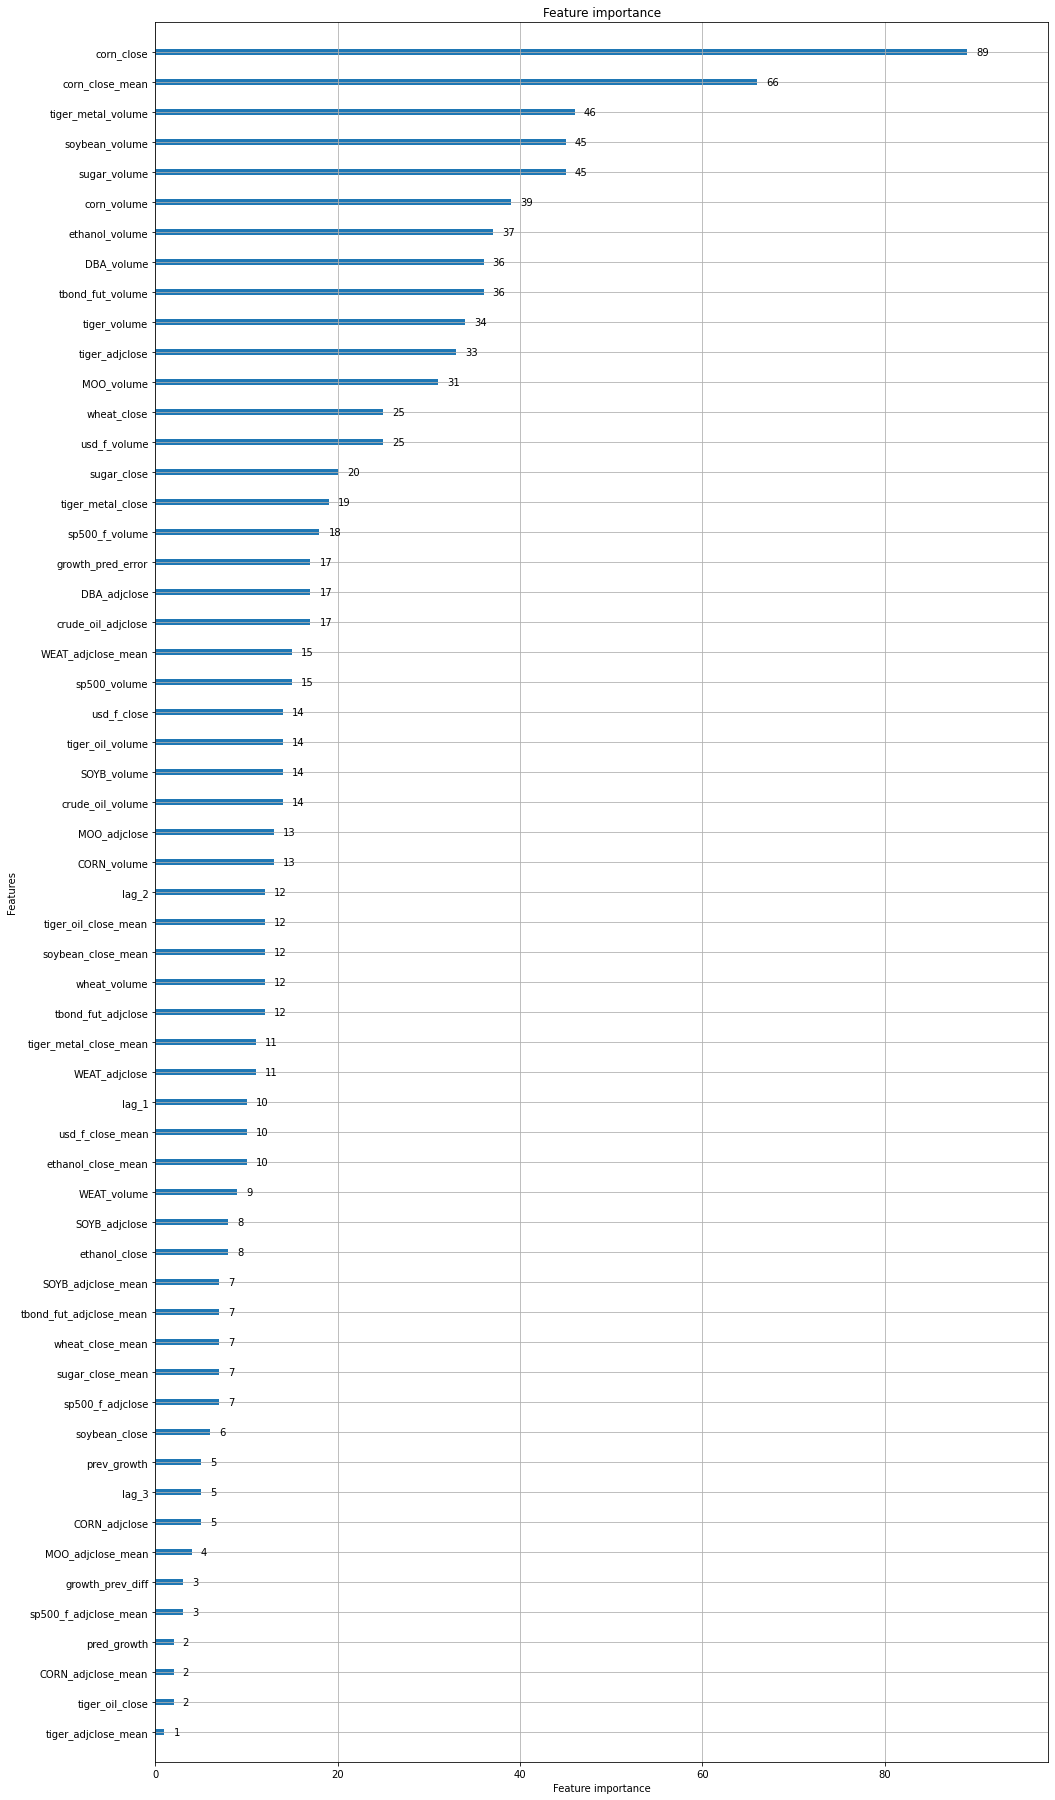

In [124]:
lgb_model1 = LGBMClassifier(**params1)
lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32),ignore_zero=False)

c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.680996
[200]	valid_0's binary_logloss: 0.677583
[300]	valid_0's binary_logloss: 0.673235
Model F1 Score :  0.6559999999999999


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

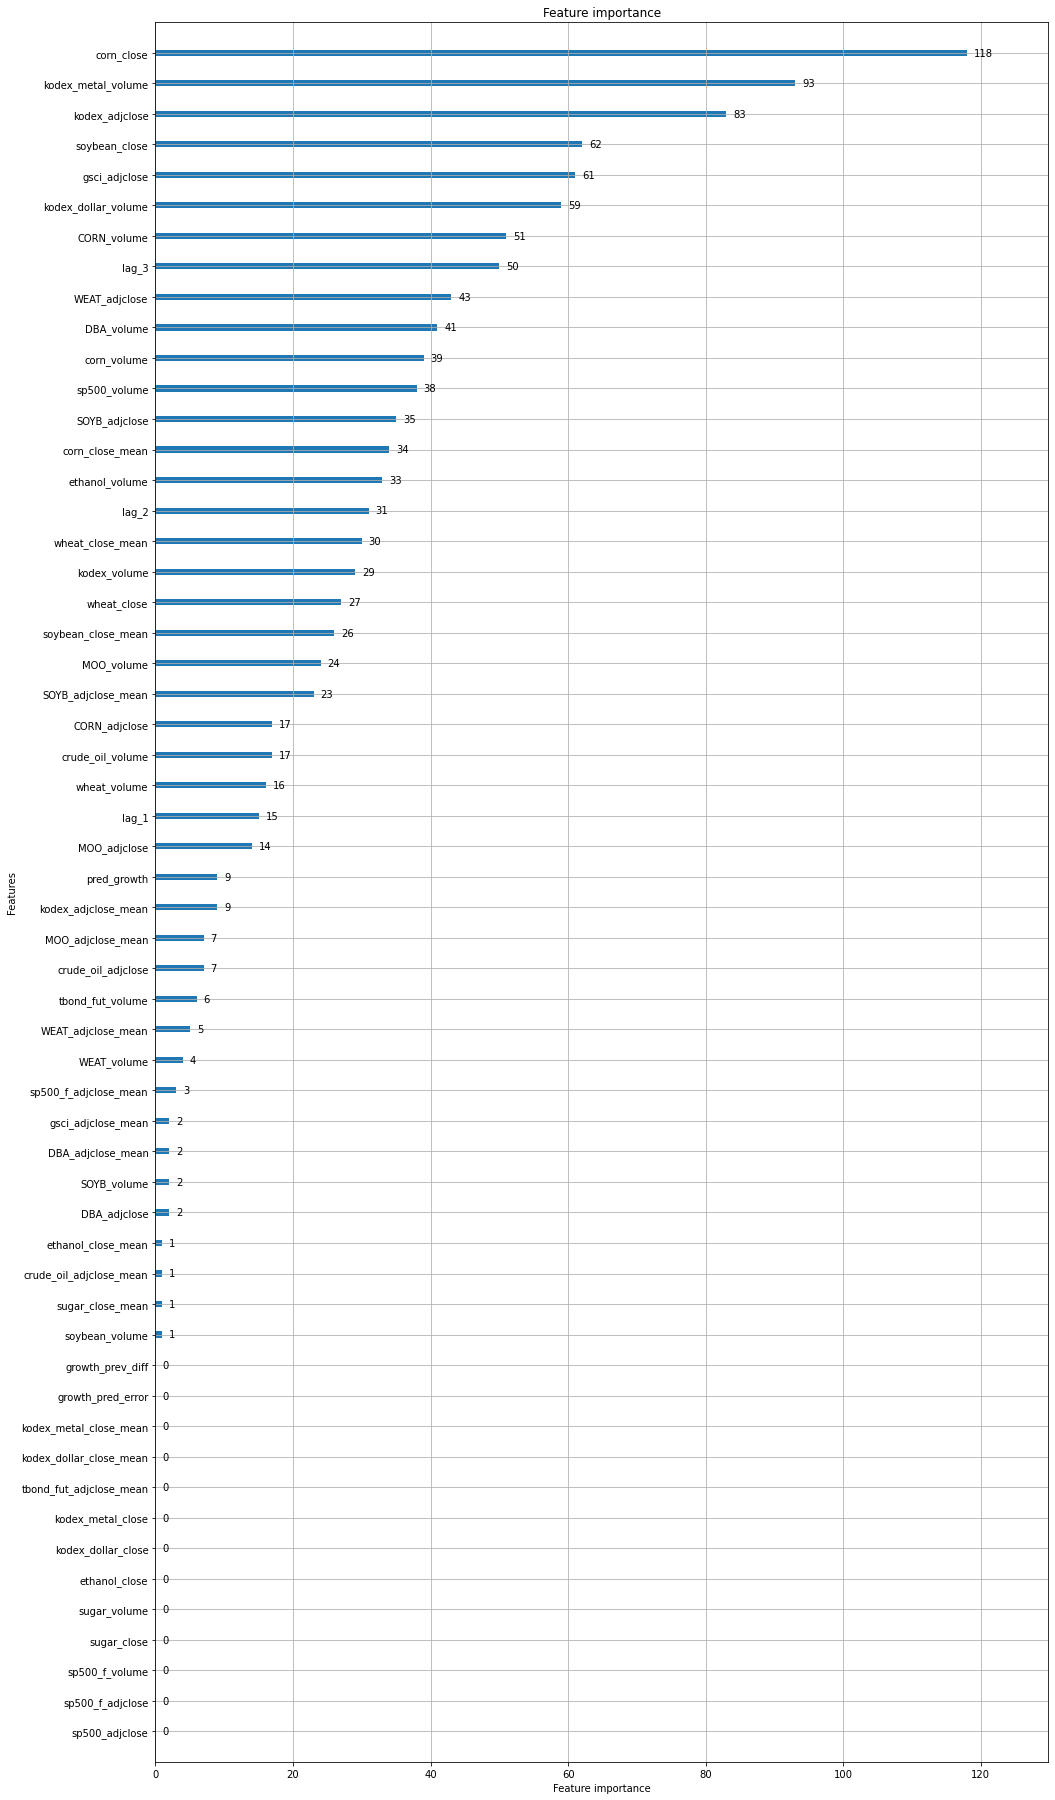

In [129]:
lgb_model2 = LGBMClassifier(**params2)
lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds=25)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

In [130]:
# TIGER 모델 하이퍼파라미터
params1

{'n_estimators': 965,
 'learning_rate': 0.03484457463701934,
 'max_depth': 68,
 'num_leaves': 302,
 'min_child_samples': 64,
 'min_child_weight': 16,
 'subsample': 0.6185010372279066,
 'colsample_bytree': 0.8134416929988239,
 'max_bin': 390,
 'reg_lambda': 3.3163605236516442,
 'reg_alpha': 4.4163126806323945}

In [131]:
# KODEX 모델 하이퍼파라미터
params2

{'n_estimators': 998,
 'learning_rate': 0.01949228897021219,
 'max_depth': 69,
 'num_leaves': 28,
 'min_child_samples': 128,
 'min_child_weight': 32,
 'subsample': 0.5235881817392987,
 'colsample_bytree': 0.6110083691636112,
 'max_bin': 283,
 'reg_lambda': 7.909751339766623,
 'reg_alpha': 6.100154485989939}

# 백테스팅

- 우선 예측값을 거래일별로 정리하고, 종가 정보를 다시 병합하자.

In [132]:
result1 = pd.DataFrame(preds_mod1,index=X_test_mod1.index, columns=['pred'])
result2 = pd.DataFrame(preds_mod2,index=X_test_mod2.index, columns=['pred'])
df_tiger=web_naver.NaverDailyReader(symbols='137610', start='20200702',adjust_price=True).read()
df_kodex=web_naver.NaverDailyReader(symbols='271060', start='20210104',adjust_price=True).read()
# 실수 타입으로 변환
df_tiger=df_tiger.astype(float)
df_kodex=df_kodex.astype(float)
# index를 datetime 타입으로 변환
df_tiger.index,result1.index = pd.to_datetime(df_tiger.index),pd.to_datetime(result1.index)
df_kodex.index,result2.index=pd.to_datetime(df_kodex.index),pd.to_datetime(result2.index)

In [133]:
df_tiger=result1.join(df_tiger)
df_tiger.dropna(inplace=True)
df_tiger

pred    Open    High     Low   Close   Volume
Date                                                     
2020-07-02     1  4080.0  4120.0  4080.0  4110.0  41901.0
2020-07-06     1  4080.0  4120.0  4080.0  4080.0  51873.0
2020-07-07     1  4100.0  4110.0  4070.0  4085.0  18914.0
2020-07-08     1  4080.0  4090.0  4070.0  4085.0  13456.0
2020-07-09     1  4105.0  4125.0  4100.0  4120.0  35266.0
...          ...     ...     ...     ...     ...      ...
2022-01-14     1  6805.0  6805.0  6635.0  6650.0  11895.0
2022-01-18     1  6685.0  6700.0  6660.0  6665.0  10762.0
2022-01-19     1  6690.0  6795.0  6690.0  6790.0  20236.0
2022-01-20     1  6890.0  6900.0  6875.0  6900.0  63080.0
2022-01-21     1  6910.0  6950.0  6845.0  6870.0  18473.0

[375 rows x 6 columns]

In [134]:
df_kodex=result2.join(df_kodex)
df_kodex.dropna(inplace=True)
df_kodex

pred     Open     High      Low    Close   Volume
Date                                                         
2021-01-04     1   9350.0   9650.0   9335.0   9625.0  76109.0
2021-01-05     1   9560.0   9565.0   9465.0   9545.0  51776.0
2021-01-06     1   9570.0   9790.0   9570.0   9785.0  67261.0
2021-01-07     1   9780.0   9780.0   9655.0   9715.0  72898.0
2021-01-08     1   9715.0   9715.0   9590.0   9710.0  63291.0
...          ...      ...      ...      ...      ...      ...
2022-01-14     1  11295.0  11300.0  11160.0  11200.0   4723.0
2022-01-18     1  11340.0  11360.0  11180.0  11200.0  10743.0
2022-01-19     1  11320.0  11450.0  11250.0  11430.0   9340.0
2022-01-20     1  11680.0  11680.0  11550.0  11650.0  23562.0
2022-01-21     1  11685.0  11690.0  11605.0  11610.0   7366.0

[254 rows x 6 columns]

In [135]:
df_tiger.to_csv(DATA_PATH+"result1.csv")
df_kodex.to_csv(DATA_PATH+"result2.csv")

====== 수익률 계산 ====== </br>
- 가격 등락 여부를 예측한 결과 가격 상승이 예상된 경우 매수, 가격 하락이 예상된 경우 매도 (최대 포지션: 1주, 공매도 x 가정)
- 슬리피지, 수수료 등을 고려하여 매 거래 시 거래비용 0.015%가 발생한다고 단순화 (삼성증권 ETF 거래수수료 참고)

1. pct_change() 함수로 일일 수익률을 구하고, 이를 누적곱하여 단순 보유 수익률인 `return` 컬럼을 계산
2. pct_change() 결과 중 예측값이 1인 수익률만 누적곱하여 전략에 따른 수익률인 `strategy` 컬럼을 계산
3. 전체 기간에 대한 누적 수익률 값과, 기간에 따른 누적수익률 그래프를 그려 비교

In [136]:
# 다시 데이터 불러오기
df_tiger = pd.read_csv(DATA_PATH+"result1.csv")
df_kodex = pd.read_csv(DATA_PATH+"result2.csv")

In [137]:
# 예측값을 1 -> 1, -1 -> 0 으로 다시 인코딩
df_tiger['pred']=(df_tiger['pred'] == 1).astype(int)

In [138]:
# 타이거 ETF에 대한 단순보유 수익률과 전략 수익률을 계산
df_tiger['pct_change']=df_tiger['Close'].pct_change()
df_tiger.dropna(inplace=True)
df_tiger['return']=(1+df_tiger['pct_change']).cumprod()-1
df_tiger['strategy_pct_change']=df_tiger['pct_change']*df_tiger['pred'].shift(1)*(1-0.00015)
df_tiger['strategy']=(1+df_tiger['strategy_pct_change']).cumprod()-1

df_tiger

Date  pred    Open    High     Low   Close   Volume  pct_change  \
1    2020-07-06     1  4080.0  4120.0  4080.0  4080.0  51873.0   -0.007299   
2    2020-07-07     1  4100.0  4110.0  4070.0  4085.0  18914.0    0.001225   
3    2020-07-08     1  4080.0  4090.0  4070.0  4085.0  13456.0    0.000000   
4    2020-07-09     1  4105.0  4125.0  4100.0  4120.0  35266.0    0.008568   
5    2020-07-10     1  4120.0  4145.0  4105.0  4135.0  63705.0    0.003641   
..          ...   ...     ...     ...     ...     ...      ...         ...   
370  2022-01-14     1  6805.0  6805.0  6635.0  6650.0  11895.0   -0.014085   
371  2022-01-18     1  6685.0  6700.0  6660.0  6665.0  10762.0    0.002256   
372  2022-01-19     1  6690.0  6795.0  6690.0  6790.0  20236.0    0.018755   
373  2022-01-20     1  6890.0  6900.0  6875.0  6900.0  63080.0    0.016200   
374  2022-01-21     1  6910.0  6950.0  6845.0  6870.0  18473.0   -0.004348   

       return  strategy_pct_change  strategy  
1   -0.007299                  NaN       NaN  
2   -0.006083             0.001225  0.001225  
3   -0.006083             0.000000  0.001225  
4    0.002433             0.008567  0.009802  
5    0.006083             0.003640  0.013478  
..        ...                  ...       ...  
370  0.618005            -0.014082  0.607719  
371  0.621655             0.002255  0.611345  
372  0.652068             0.018752  0.641560  
373  0.678832             0.016198  0.668150  
374  0.671533            -0.004347  0.660898  

[374 rows x 11 columns]

In [139]:
# 코덱스 ETF에 대한 단순보유 수익률과 전략 수익률을 계산
df_kodex['pct_change']=df_kodex['Close'].pct_change()
df_kodex.dropna(inplace=True)
df_kodex['return']=(1+df_kodex['pct_change']).cumprod()-1
df_kodex['strategy_pct_change']=df_kodex['pct_change']*df_kodex['pred'].shift(1)*(1-0.00015)
df_kodex['strategy']=(1+df_kodex['strategy_pct_change']).cumprod()-1

df_kodex

Date  pred     Open     High      Low    Close   Volume  \
1    2021-01-05     1   9560.0   9565.0   9465.0   9545.0  51776.0   
2    2021-01-06     1   9570.0   9790.0   9570.0   9785.0  67261.0   
3    2021-01-07     1   9780.0   9780.0   9655.0   9715.0  72898.0   
4    2021-01-08     1   9715.0   9715.0   9590.0   9710.0  63291.0   
5    2021-01-11     1   9765.0   9770.0   9635.0   9635.0  52888.0   
..          ...   ...      ...      ...      ...      ...      ...   
249  2022-01-14     1  11295.0  11300.0  11160.0  11200.0   4723.0   
250  2022-01-18     1  11340.0  11360.0  11180.0  11200.0  10743.0   
251  2022-01-19     1  11320.0  11450.0  11250.0  11430.0   9340.0   
252  2022-01-20     1  11680.0  11680.0  11550.0  11650.0  23562.0   
253  2022-01-21     1  11685.0  11690.0  11605.0  11610.0   7366.0   

     pct_change    return  strategy_pct_change  strategy  
1     -0.008312 -0.008312                  NaN       NaN  
2      0.025144  0.016623             0.025140  0.025140  
3     -0.007154  0.009351            -0.007153  0.017808  
4     -0.000515  0.008831            -0.000515  0.017284  
5     -0.007724  0.001039            -0.007723  0.009428  
..          ...       ...                  ...       ...  
249   -0.011474  0.163636            -0.011472  0.300072  
250    0.000000  0.163636             0.000000  0.300072  
251    0.020536  0.187532             0.020533  0.326766  
252    0.019248  0.210390             0.019245  0.352299  
253   -0.003433  0.206234            -0.003433  0.347657  

[253 rows x 11 columns]

In [140]:
# 인덱스를 다시 날짜로 수정
df_tiger.index = df_tiger['Date']
df_kodex.index = df_kodex['Date']

#### 누적수익률 계산 및 그래프 도식화

1. 전체 기간 누적수익률

In [141]:
print('TIGER ETF 수익률:'+'\n {}'.format(df_tiger[['return','strategy']].iloc[-1]))
print('kodex etf 수익률:'+'\n {}'.format(df_kodex[['return','strategy']].iloc[-1]))

TIGER ETF 수익률:
 return      0.671533
strategy    0.660898
Name: 2022-01-21, dtype: float64
kodex etf 수익률:
 return      0.206234
strategy    0.347657
Name: 2022-01-21, dtype: float64


2. 기간별 누적수익률 그래프

<AxesSubplot:xlabel='Date'>

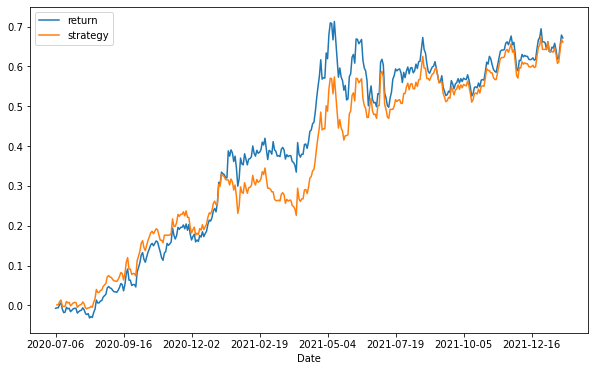

In [142]:
df_tiger[['return','strategy']].plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

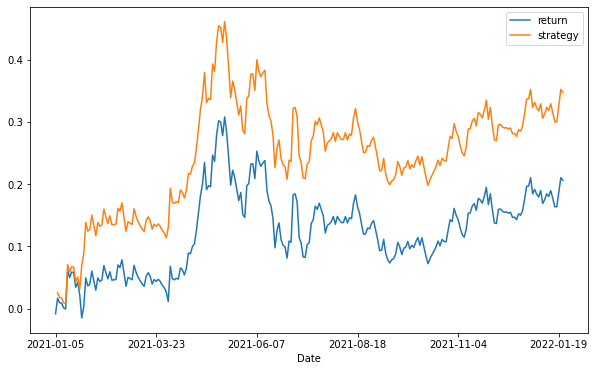

In [143]:
df_kodex[['return','strategy']].plot(figsize=(10,6))

# 추가 고려사항

### 1. (KODEX model) FI가 0인 컬럼 추가 drop

In [144]:
# 다시 데이터프레임 불러오기
input_df_mod2 = pd.read_csv(DATA_PATH+'input_df_mod2.csv',index_col=0)

# FI가 0인 컬럼 드랍
input_df_mod2.drop(['growth_prev_diff', 'growth_pred_error', 'kodex_metal_close_mean', 'kodex_dollar_close_mean', 'tbond_fut_adjclose_mean', 'kodex_metal_close', 'kodex_dollar_close', 'ethanol_close', 'sugar_volume', 'sugar_close', 'sp500_f_volume', 'sp500_f_adjclose', 'sp500_adjclose'],axis=1,inplace=True)

# Train-test split
X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

y_train_mod2 = y_train_mod2.values.ravel()
y_valid_mod2 = y_valid_mod2.values.ravel()
y_test_mod2 = y_test_mod2.values.ravel()

In [145]:
bayesian_params = {
    "n_estimators":(400,1000),
    "learning_rate":(0.005,0.04),
    'max_depth': (10, 70), 
    'num_leaves': (10, 500), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 550),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 7) 
}

In [146]:
def lgb_f1_eval_mod2(n_estimators,learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)),
        "learning_rate":max(min(learning_rate, 1), 0),
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model2 = LGBMClassifier(**params)
    lgb_model2.fit(X_train_mod2, y_train_mod2, 
                eval_set=[(X_valid_mod2, y_valid_mod2)],
                eval_metric= 'f1', verbose=100,
                early_stopping_rounds= 25)
    test_pred = lgb_model2.predict(X_test_mod2)
    f1_mod2 = f1_score(y_test_mod2, test_pred)
    
    return f1_mod2

In [147]:
def change_values(n_estimators,learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)),
        "learning_rate":max(min(learning_rate, 1), 0),
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    return params

In [148]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO_mod2 = BayesianOptimization(lgb_f1_eval_mod2,bayesian_params, random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO_mod2.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
[100]	valid_0's binary_logloss: 0.671427
[200]	valid_0's binary_logloss: 0.662981
|  1        |  0.6452   |  0.6873   |  0.03828  |  405.3    |  45.92    |  39.64    |  8.644    |  434.9    |  434.4    |  4.212    |  7.081    |  0.5103   |
[100]	valid_0's binary_logloss: 0.670714


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[200]	valid_0's binary_logloss: 0.653582
|  2        |  0.6284   |  0.985    |  0.03414  |  124.7    |  20.91    |  44.85    |  15.91    |  714.9    |  221.7    |  2.046    |  6.119    |  0.5697   |
[100]	valid_0's binary_logloss: 0.675973
[200]	valid_0's binary_logloss: 0.662688
[300]	valid_0's binary_logloss: 0.659408
|  3        |  0.6542   |  0.6461   |  0.01782  |  256.3    |  57.11    |  47.94    |  26.2     |  755.4    |  32.76    |  4.257    |  1.706    |  0.5325   |
[100]	valid_0's binary_logloss: 0.668469


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[200]	valid_0's binary_logloss: 0.664329
|  4        |  0.6489   |  0.9744   |  0.0388   |  446.5    |  28.28    |  28.56    |  34.53    |  664.1    |  69.8     |  3.471    |  0.3449   |  0.9547   |
[100]	valid_0's binary_logloss: 0.680087
[200]	valid_0's binary_logloss: 0.670922
[300]	valid_0's binary_logloss: 0.667403
[400]	valid_0's binary_logloss: 0.665116
|  5        |  0.6543   |  0.6294   |  0.02819  |  178.3    |  41.2     |  113.9    |  10.06    |  981.8    |  389.8    |  6.577    |  8.948    |  0.7989   |
[100]	valid_0's binary_logloss: 0.677011


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[200]	valid_0's binary_logloss: 0.672879
[300]	valid_0's binary_logloss: 0.669035
|  6        |  0.6371   |  0.6359   |  0.03257  |  404.5    |  27.48    |  91.49    |  32.78    |  715.3    |  233.5    |  0.7098   |  4.35     |  0.9961   |
[100]	valid_0's binary_logloss: 0.680374
[200]	valid_0's binary_logloss: 0.675782
|  7        |  0.6525   |  0.8579   |  0.01139  |  78.23    |  26.48    |  121.1    |  2.63     |  891.8    |  173.2    |  1.371    |  8.267    |  0.9727   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.679187
[200]	valid_0's binary_logloss: 0.67619
[300]	valid_0's binary_logloss: 0.671464
|  8        |  0.6525   |  0.9194   |  0.03873  |  528.0    |  26.65    |  147.2    |  49.27    |  789.5    |  176.0    |  3.181    |  8.032    |  0.7042   |
[100]	valid_0's binary_logloss: 0.679323
[200]	valid_0's binary_logloss: 0.673486
[300]	valid_0's binary_logloss: 0.670204
[400]	valid_0's binary_logloss: 0.66508
|  9        |  0.6525   |  0.751    |  0.03537  |  210.8    |  37.36    |  170.4    |  1.916    |  865.2    |  205.0    |  4.571    |  5.919    |  0.7251   |
[100]	valid_0's binary_logloss: 0.686918
[200]	valid_0's binary_logloss: 0.685031
[300]	valid_0's binary_logloss: 0.682991
[400]	valid_0's binary_logloss: 0.680815
[500]	valid_0's binary_logloss: 0.678616
[600]	valid_0's binary_logloss: 0.676902
[700]	valid_0's binary_logloss: 0.674922


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's binary_logloss: 0.673077
|  10       |  0.6525   |  0.6239   |  0.006374 |  530.1    |  36.61    |  151.4    |  28.98    |  800.6    |  168.9    |  5.538    |  8.042    |  0.6142   |
[100]	valid_0's binary_logloss: 0.681366
[200]	valid_0's binary_logloss: 0.673313


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	valid_0's binary_logloss: 0.668148
[400]	valid_0's binary_logloss: 0.663762
[500]	valid_0's binary_logloss: 0.66111
[600]	valid_0's binary_logloss: 0.658658
[700]	valid_0's binary_logloss: 0.656318
|  11       |  0.6525   |  0.6507   |  0.01875  |  126.4    |  32.59    |  152.1    |  26.0     |  957.8    |  281.5    |  1.421    |  5.624    |  0.7631   |
[100]	valid_0's binary_logloss: 0.681084


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's binary_logloss: 0.675957
|  12       |  0.6525   |  0.5507   |  0.02899  |  441.0    |  22.98    |  15.43    |  46.9     |  667.9    |  52.13    |  1.93     |  9.414    |  0.9987   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.667737
|  13       |  0.6543   |  0.7529   |  0.02547  |  380.0    |  27.09    |  13.21    |  26.1     |  840.4    |  21.51    |  1.944    |  4.326    |  0.9391   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.663702
[200]	valid_0's binary_logloss: 0.650836
|  14       |  0.6415   |  0.7985   |  0.02776  |  212.1    |  58.29    |  93.49    |  9.244    |  947.7    |  56.7     |  4.234    |  2.255    |  0.5036   |
[100]	valid_0's binary_logloss: 0.680533
[200]	valid_0's binary_logloss: 0.673377
[300]	valid_0's binary_logloss: 0.666785
[400]	valid_0's binary_logloss: 0.662228
[500]	valid_0's binary_logloss: 0.658478
[600]	valid_0's binary_logloss: 0.656003
|  15       |  0.6543   |  0.607    |  0.01076  |  253.0    |  52.4     |  47.21    |  22.53    |  766.2    |  30.84    |  5.322    |  1.816    |  0.8397   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.680976
[200]	valid_0's binary_logloss: 0.675765
|  16       |  0.6525   |  0.6055   |  0.02862  |  514.8    |  33.37    |  47.9     |  43.61    |  791.0    |  15.21    |  4.999    |  4.39     |  0.543    |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.687199
[200]	valid_0's binary_logloss: 0.685308
[300]	valid_0's binary_logloss: 0.684039
[400]	valid_0's binary_logloss: 0.683106
[500]	valid_0's binary_logloss: 0.682061
[600]	valid_0's binary_logloss: 0.681357
[700]	valid_0's binary_logloss: 0.680643
[800]	valid_0's binary_logloss: 0.679931
[900]	valid_0's binary_logloss: 0.678499
|  17       |  0.6525   |  0.7132   |  0.0066   |  285.8    |  29.65    |  194.6    |  18.78    |  986.5    |  311.2    |  6.288    |  2.646    |  0.73     |
[100]	valid_0's binary_logloss: 0.679844
[200]	valid_0's binary_logloss: 0.675464
[300]	valid_0's binary_logloss: 0.67355
|  18       |  0.6525   |  0.5284   |  0.03976  |  274.8    |  56.22    |  183.2    |  21.18    |  962.4    |  487.6    |  6.615    |  0.7655   |  0.8121   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.686339
[200]	valid_0's binary_logloss: 0.683061
[300]	valid_0's binary_logloss: 0.680385
[400]	valid_0's binary_logloss: 0.677907
[500]	valid_0's binary_logloss: 0.675488
[600]	valid_0's binary_logloss: 0.673619
[700]	valid_0's binary_logloss: 0.672099
[800]	valid_0's binary_logloss: 0.670601
[900]	valid_0's binary_logloss: 0.669005
|  19       |  0.6525   |  0.5519   |  0.005966 |  255.1    |  21.53    |  112.6    |  29.23    |  983.3    |  83.54    |  6.6      |  3.295    |  0.5937   |
[100]	valid_0's binary_logloss: 0.68392


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's binary_logloss: 0.6801
[300]	valid_0's binary_logloss: 0.672693
[400]	valid_0's binary_logloss: 0.666421
[500]	valid_0's binary_logloss: 0.661549
[600]	valid_0's binary_logloss: 0.65812
[700]	valid_0's binary_logloss: 0.654623
[800]	valid_0's binary_logloss: 0.651861
[900]	valid_0's binary_logloss: 0.649987
|  20       |  0.6578   |  0.9057   |  0.006192 |  348.0    |  12.03    |  106.5    |  17.16    |  980.3    |  181.9    |  2.104    |  4.907    |  0.5325   |
[100]	valid_0's binary_logloss: 0.681363
[200]	valid_0's binary_logloss: 0.675429
|  21       |  0.6525   |  0.9504   |  0.02863  |  420.7    |  17.05    |  189.5    |  29.44    |  983.3    |  109.8    |  2.485    |  8.517    |  0.8677   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.669049
[200]	valid_0's binary_logloss: 0.663391
[300]	valid_0's binary_logloss: 0.660946
|  22       |  0.6525   |  0.8318   |  0.03953  |  405.1    |  33.32    |  56.24    |  37.08    |  969.6    |  119.2    |  3.18     |  9.26     |  0.5658   |
[100]	valid_0's binary_logloss: 0.67005


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's binary_logloss: 0.665405
|  23       |  0.6525   |  0.9058   |  0.03777  |  287.2    |  10.39    |  43.82    |  41.84    |  984.4    |  225.1    |  0.5622   |  1.216    |  0.7639   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.683151
[200]	valid_0's binary_logloss: 0.678925
[300]	valid_0's binary_logloss: 0.675514
[400]	valid_0's binary_logloss: 0.673238
|  24       |  0.6525   |  0.8278   |  0.03027  |  300.2    |  49.72    |  189.1    |  8.717    |  979.0    |  186.7    |  6.149    |  9.699    |  0.8581   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.67569
|  25       |  0.6543   |  0.6554   |  0.03793  |  430.3    |  29.32    |  116.9    |  33.79    |  977.8    |  267.2    |  3.401    |  7.915    |  0.8639   |
[100]	valid_0's binary_logloss: 0.672164
|  26       |  0.6525   |  0.8134   |  0.03484  |  390.4    |  67.54    |  64.3     |  16.29    |  965.3    |  301.6    |  4.416    |  3.316    |  0.6185   |
[100]	valid_0's binary_logloss: 0.683773


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's binary_logloss: 0.679794
[300]	valid_0's binary_logloss: 0.676635
[400]	valid_0's binary_logloss: 0.674086
[500]	valid_0's binary_logloss: 0.671204
|  27       |  0.6525   |  0.5544   |  0.02038  |  83.57    |  13.32    |  192.9    |  24.08    |  985.9    |  466.1    |  0.227    |  8.478    |  0.5447   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.668318
[200]	valid_0's binary_logloss: 0.658001
|  28       |  0.6543   |  0.7255   |  0.03156  |  107.1    |  34.1     |  14.45    |  30.2     |  959.4    |  491.3    |  1.245    |  4.007    |  0.7997   |
[100]	valid_0's binary_logloss: 0.661315
|  29       |  0.6434   |  0.5963   |  0.03647  |  275.6    |  63.14    |  25.09    |  21.59    |  974.0    |  476.0    |  0.6011   |  6.926    |  0.6663   |
[100]	valid_0's binary_logloss: 0.671636
[200]	valid_0's binary_logloss: 0.656559
[300]	valid_0's binary_logloss: 0.647951
|  30       |  0.6507   |  0.7408   |  0.0269   |  268.3    |  52.75    |  46.17    |  19.06    |  759.1    |  31.51    |  4.606    |  8.388    |  0.5298   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.68392
[200]	valid_0's binary_logloss: 0.6801
[300]	valid_0's binary_logloss: 0.672693
[400]	valid_0's binary_logloss: 0.666421
[500]	valid_0's binary_logloss: 0.661549
[600]	valid_0's binary_logloss: 0.65812
[700]	valid_0's binary_logloss: 0.654623
[800]	valid_0's binary_logloss: 0.651861
[900]	valid_0's binary_logloss: 0.649987
Model F1 Score :  0.6577540106951871


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

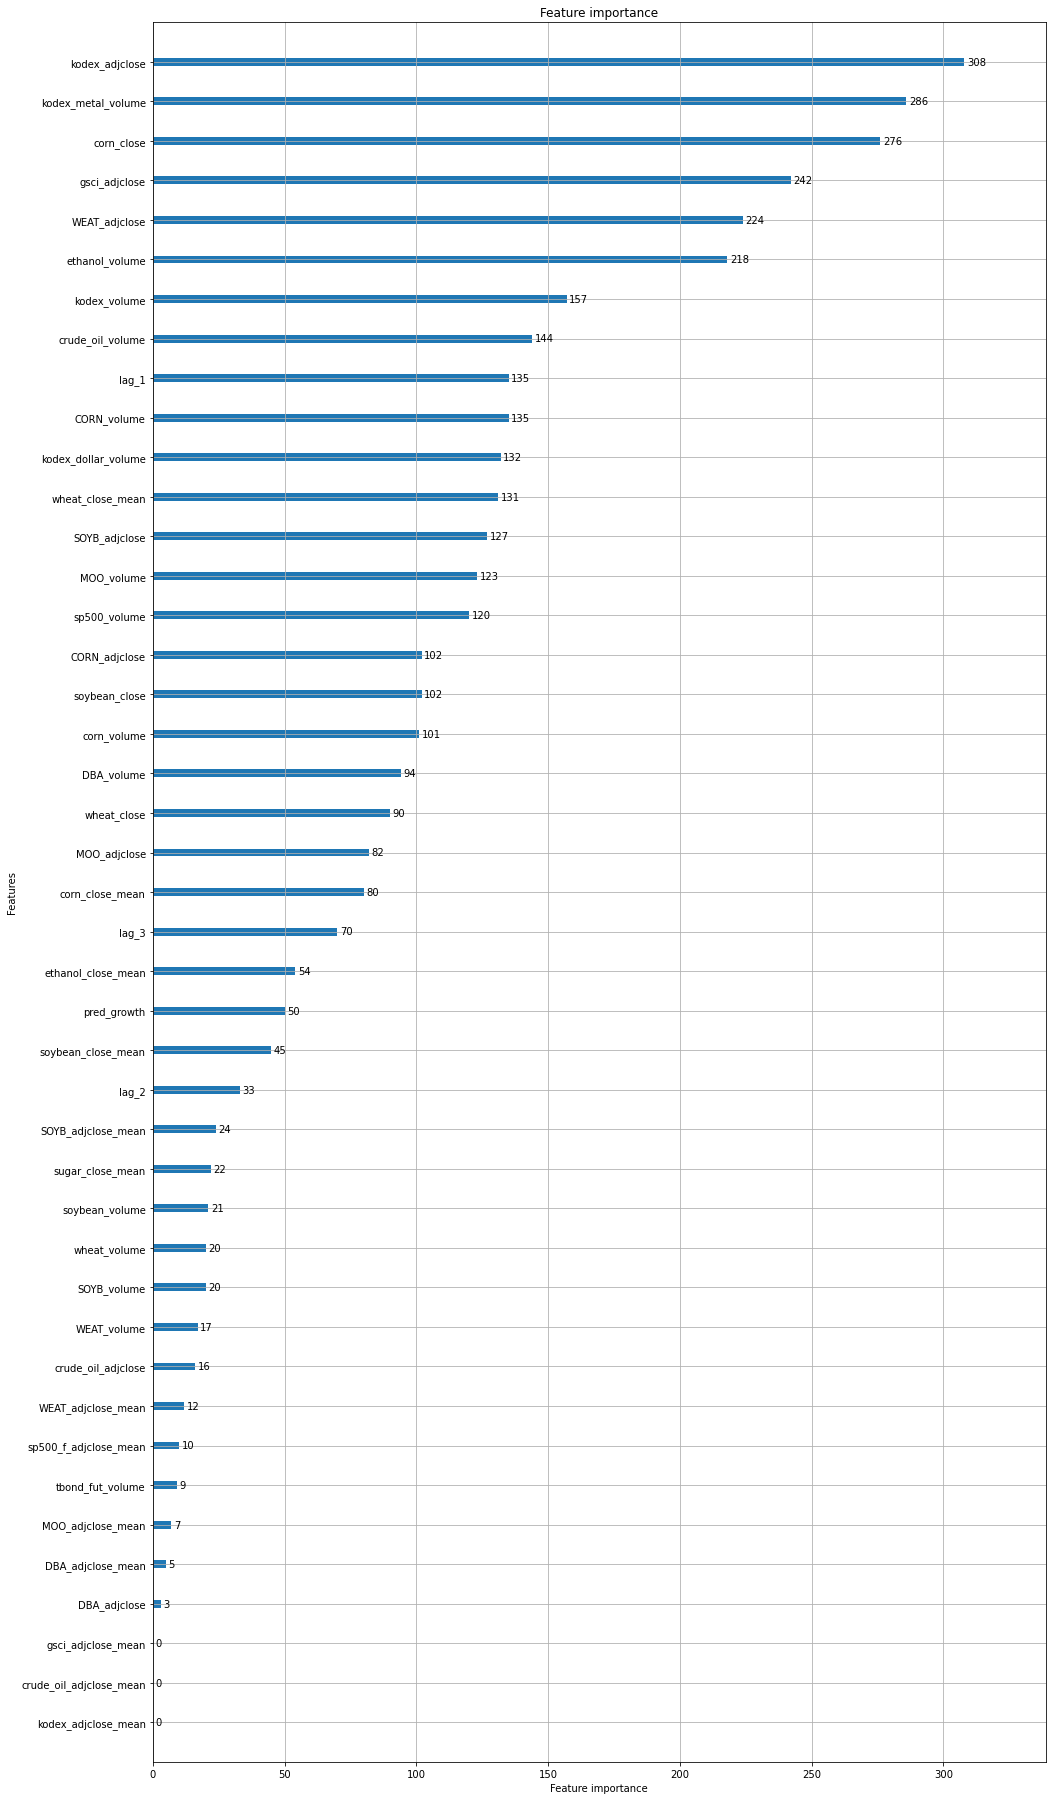

In [151]:
target_list_mod2 = []
for result in lgbBO_mod2.res:
    target = result['target']
    target_list_mod2.append(target)
max_dict_mod2 = lgbBO_mod2.res[np.argmax(np.array(target_list_mod2))]

params2 = change_values(**max_dict_mod2['params'])

lgb_model2 = LGBMClassifier(**params2)
lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds=25)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

### 2. (KODEX model) Bitcoin 컬럼 추가

In [169]:
input_df_mod2 = pd.read_csv(DATA_PATH+'lag_df2.csv',index_col=0)

btc=pd.read_csv(DATA_PATH+'btc.csv',index_col=0)
btc=btc[['btc_close','btc_volume']]
btc=btc.astype(float)
btc.index=pd.to_datetime(btc.index)
input_df_mod2.index=pd.to_datetime(input_df_mod2.index)
input_df_mod2= input_df_mod2.join(btc)

df2_cols = [x for x in input_df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('growth_pred_error')
df2_cols.remove('growth_prev_diff')
df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

def robust_scaling_kodex(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','kodex_label']])

input_df_mod2 = robust_scaling_kodex(input_df_mod2,df2_cols)

input_df_mod2.drop(['CORN_adjclose_mean', 'sp500_adjclose_mean', 'tbond_fut_adjclose', 'prev_growth', 'actual_growth'],axis=1,inplace=True)
input_df_mod2.drop(['growth_prev_diff', 'growth_pred_error', 'kodex_metal_close_mean', 'kodex_dollar_close_mean', 'tbond_fut_adjclose_mean', 'kodex_metal_close', 'kodex_dollar_close', 'ethanol_close', 'sugar_volume', 'sugar_close', 'sp500_f_volume', 'sp500_f_adjclose', 'sp500_adjclose'],axis=1,inplace=True)

In [170]:
# Train-test split
X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

y_train_mod2 = y_train_mod2.values.ravel()
y_valid_mod2 = y_valid_mod2.values.ravel()
y_test_mod2 = y_test_mod2.values.ravel()

In [201]:
bayesian_params = {
    "n_estimators":(400,1000),
    "learning_rate":(0.02,0.04),
    'max_depth': (10, 70), 
    'num_leaves': (10, 500), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 550),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 7) 
}

In [202]:
def lgb_f1_eval_mod2(n_estimators,learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)),
        "learning_rate":max(min(learning_rate, 1), 0),
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model2 = LGBMClassifier(**params)
    lgb_model2.fit(X_train_mod2, y_train_mod2, 
                eval_set=[(X_valid_mod2, y_valid_mod2)],
                eval_metric= 'f1', verbose=100,
                early_stopping_rounds= 25)
    test_pred = lgb_model2.predict(X_test_mod2)
    f1_mod2 = f1_score(y_test_mod2, test_pred)
    
    return f1_mod2

In [203]:
def change_values(n_estimators,learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)),
        "learning_rate":max(min(learning_rate, 1), 0),
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    return params

In [204]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO_mod2 = BayesianOptimization(lgb_f1_eval_mod2, bayesian_params, random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO_mod2.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
[100]	valid_0's binary_logloss: 0.668618
|  1        |  0.6328   |  0.6873   |  0.03901  |  405.3    |  45.92    |  39.64    |  8.644    |  434.9    |  434.4    |  4.212    |  7.081    |  0.5103   |
[100]	valid_0's binary_logloss: 0.664236


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  2        |  0.6448   |  0.985    |  0.03665  |  124.7    |  20.91    |  44.85    |  15.91    |  714.9    |  221.7    |  2.046    |  6.119    |  0.5697   |
[100]	valid_0's binary_logloss: 0.675292
[200]	valid_0's binary_logloss: 0.661184


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


|  3        |  0.6486   |  0.6461   |  0.02733  |  256.3    |  57.11    |  47.94    |  26.2     |  755.4    |  32.76    |  4.257    |  1.706    |  0.5325   |
|  4        |  0.6525   |  0.9744   |  0.03931  |  446.5    |  28.28    |  28.56    |  34.53    |  664.1    |  69.8     |  3.471    |  0.3449   |  0.9547   |
[100]	valid_0's binary_logloss: 0.682224
[200]	valid_0's binary_logloss: 0.673077
[300]	valid_0's binary_logloss: 0.669567
|  5        |  0.6431   |  0.6294   |  0.03325  |  178.3    |  41.2     |  113.9    |  10.06    |  981.8    |  389.8    |  6.577    |  8.948    |  0.7989   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  6        |  0.6525   |  0.8524   |  0.02884  |  544.5    |  30.23    |  28.91    |  36.94    |  854.2    |  38.89    |  5.738    |  7.76     |  0.9648   |
|  7        |  0.6525   |  0.7295   |  0.0253   |  548.0    |  50.9     |  195.2    |  32.17    |  726.4    |  37.3     |  4.501    |  5.096    |  0.9269   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  8        |  0.6453   |  1.0      |  0.02408  |  550.0    |  10.0     |  90.88    |  50.0     |  436.4    |  10.0     |  0.01     |  0.1101   |  0.9182   |
|  9        |  0.6525   |  0.751    |  0.03736  |  210.8    |  37.36    |  170.4    |  1.916    |  865.2    |  205.0    |  4.571    |  5.919    |  0.7251   |
[100]	valid_0's binary_logloss: 0.683601
[200]	valid_0's binary_logloss: 0.67632
[300]	valid_0's binary_logloss: 0.667169
[400]	valid_0's binary_logloss: 0.663787
[500]	valid_0's binary_logloss: 0.659797
|  10       |  0.6525   |  0.8537   |  0.02046  |  445.6    |  14.05    |  12.49    |  29.75    |  649.8    |  58.72    |  4.391    |  8.712    |  0.5523   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  11       |  0.6525   |  0.7454   |  0.03226  |  394.6    |  51.81    |  194.3    |  9.301    |  982.7    |  44.14    |  5.789    |  3.051    |  0.9711   |
|  12       |  0.6525   |  0.7689   |  0.0255   |  546.8    |  45.27    |  28.6     |  38.4     |  858.1    |  45.73    |  0.9133   |  4.359    |  0.9977   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.681896
[200]	valid_0's binary_logloss: 0.677826
[300]	valid_0's binary_logloss: 0.67205
[400]	valid_0's binary_logloss: 0.666765
[500]	valid_0's binary_logloss: 0.662494
[600]	valid_0's binary_logloss: 0.659538
[700]	valid_0's binary_logloss: 0.657586
|  13       |  0.6504   |  0.9511   |  0.03312  |  37.64    |  17.24    |  194.8    |  2.663    |  949.1    |  54.88    |  5.188    |  5.302    |  0.5899   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  14       |  0.6525   |  0.8222   |  0.02929  |  534.0    |  36.58    |  199.9    |  8.288    |  965.1    |  272.2    |  4.324    |  1.497    |  0.8875   |
|  15       |  0.6453   |  0.5779   |  0.02788  |  377.8    |  11.58    |  185.2    |  30.12    |  837.6    |  152.9    |  2.208    |  5.822    |  0.7204   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.662522
|  16       |  0.6443   |  0.6653   |  0.02671  |  538.9    |  21.57    |  27.35    |  5.23     |  997.4    |  213.4    |  1.695    |  9.308    |  0.9816   |
|  17       |  0.6525   |  0.6348   |  0.03344  |  537.4    |  38.64    |  192.4    |  45.74    |  946.8    |  23.11    |  3.056    |  3.021    |  0.5092   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  18       |  0.6525   |  0.5845   |  0.0274   |  216.2    |  67.9     |  198.5    |  16.55    |  989.1    |  50.71    |  3.734    |  6.22     |  0.5199   |
[100]	valid_0's binary_logloss: 0.685732
[200]	valid_0's binary_logloss: 0.677137
|  19       |  0.6507   |  0.5519   |  0.02055  |  255.1    |  21.53    |  112.6    |  29.23    |  983.3    |  83.54    |  6.6      |  3.295    |  0.5937   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  20       |  0.6525   |  0.9317   |  0.02067  |  547.3    |  59.65    |  189.3    |  27.77    |  987.6    |  479.9    |  6.072    |  6.01     |  0.7797   |
|  21       |  0.6525   |  0.5863   |  0.02214  |  207.4    |  23.23    |  165.9    |  6.104    |  872.5    |  214.4    |  0.5063   |  4.49     |  0.5324   |
[100]	valid_0's binary_logloss: 0.684139


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  22       |  0.6525   |  0.9666   |  0.03214  |  26.09    |  40.81    |  166.2    |  9.679    |  425.9    |  24.26    |  0.2324   |  7.297    |  0.6036   |
|  23       |  0.6525   |  0.7297   |  0.03891  |  13.12    |  47.38    |  186.0    |  12.43    |  427.8    |  224.8    |  0.8007   |  5.439    |  0.9246   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.688053
|  24       |  0.6525   |  0.5284   |  0.02728  |  12.22    |  34.31    |  192.9    |  15.23    |  665.8    |  13.21    |  5.852    |  4.449    |  0.7211   |
[100]	valid_0's binary_logloss: 0.684091
[200]	valid_0's binary_logloss: 0.681305
[300]	valid_0's binary_logloss: 0.680333
|  25       |  0.6489   |  0.5073   |  0.0321   |  191.4    |  51.7     |  189.6    |  39.2     |  527.0    |  13.0     |  2.848    |  0.7034   |  0.8983   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

[100]	valid_0's binary_logloss: 0.65774
[200]	valid_0's binary_logloss: 0.649942
|  26       |  0.6189   |  0.8134   |  0.03705  |  390.4    |  67.54    |  64.3     |  16.29    |  965.3    |  301.6    |  4.416    |  3.316    |  0.6185   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


|  27       |  0.6525   |  0.8134   |  0.02923  |  21.82    |  24.5     |  14.46    |  47.24    |  415.8    |  98.46    |  5.576    |  1.151    |  0.5197   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.680371
[200]	valid_0's binary_logloss: 0.675424
|  28       |  0.6434   |  0.5989   |  0.02561  |  10.19    |  66.1     |  182.4    |  12.86    |  493.3    |  486.0    |  0.8107   |  5.992    |  0.5139   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _

|  29       |  0.6282   |  0.9952   |  0.02011  |  71.52    |  62.59    |  198.3    |  13.74    |  883.7    |  232.6    |  0.5912   |  1.963    |  0.7546   |
[100]	valid_0's binary_logloss: 0.680346
[200]	valid_0's binary_logloss: 0.670041
[300]	valid_0's binary_logloss: 0.665378
[400]	valid_0's binary_logloss: 0.660492
|  30       |  0.6722   |  0.9039   |  0.0373   |  461.6    |  39.59    |  144.1    |  25.36    |  626.0    |  310.6    |  1.124    |  2.691    |  0.9277   |


c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\heunjin516\Anaconda3\envs\ml4t\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.680346
[200]	valid_0's binary_logloss: 0.670041
[300]	valid_0's binary_logloss: 0.665378
[400]	valid_0's binary_logloss: 0.660492
Model F1 Score :  0.6721763085399449


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

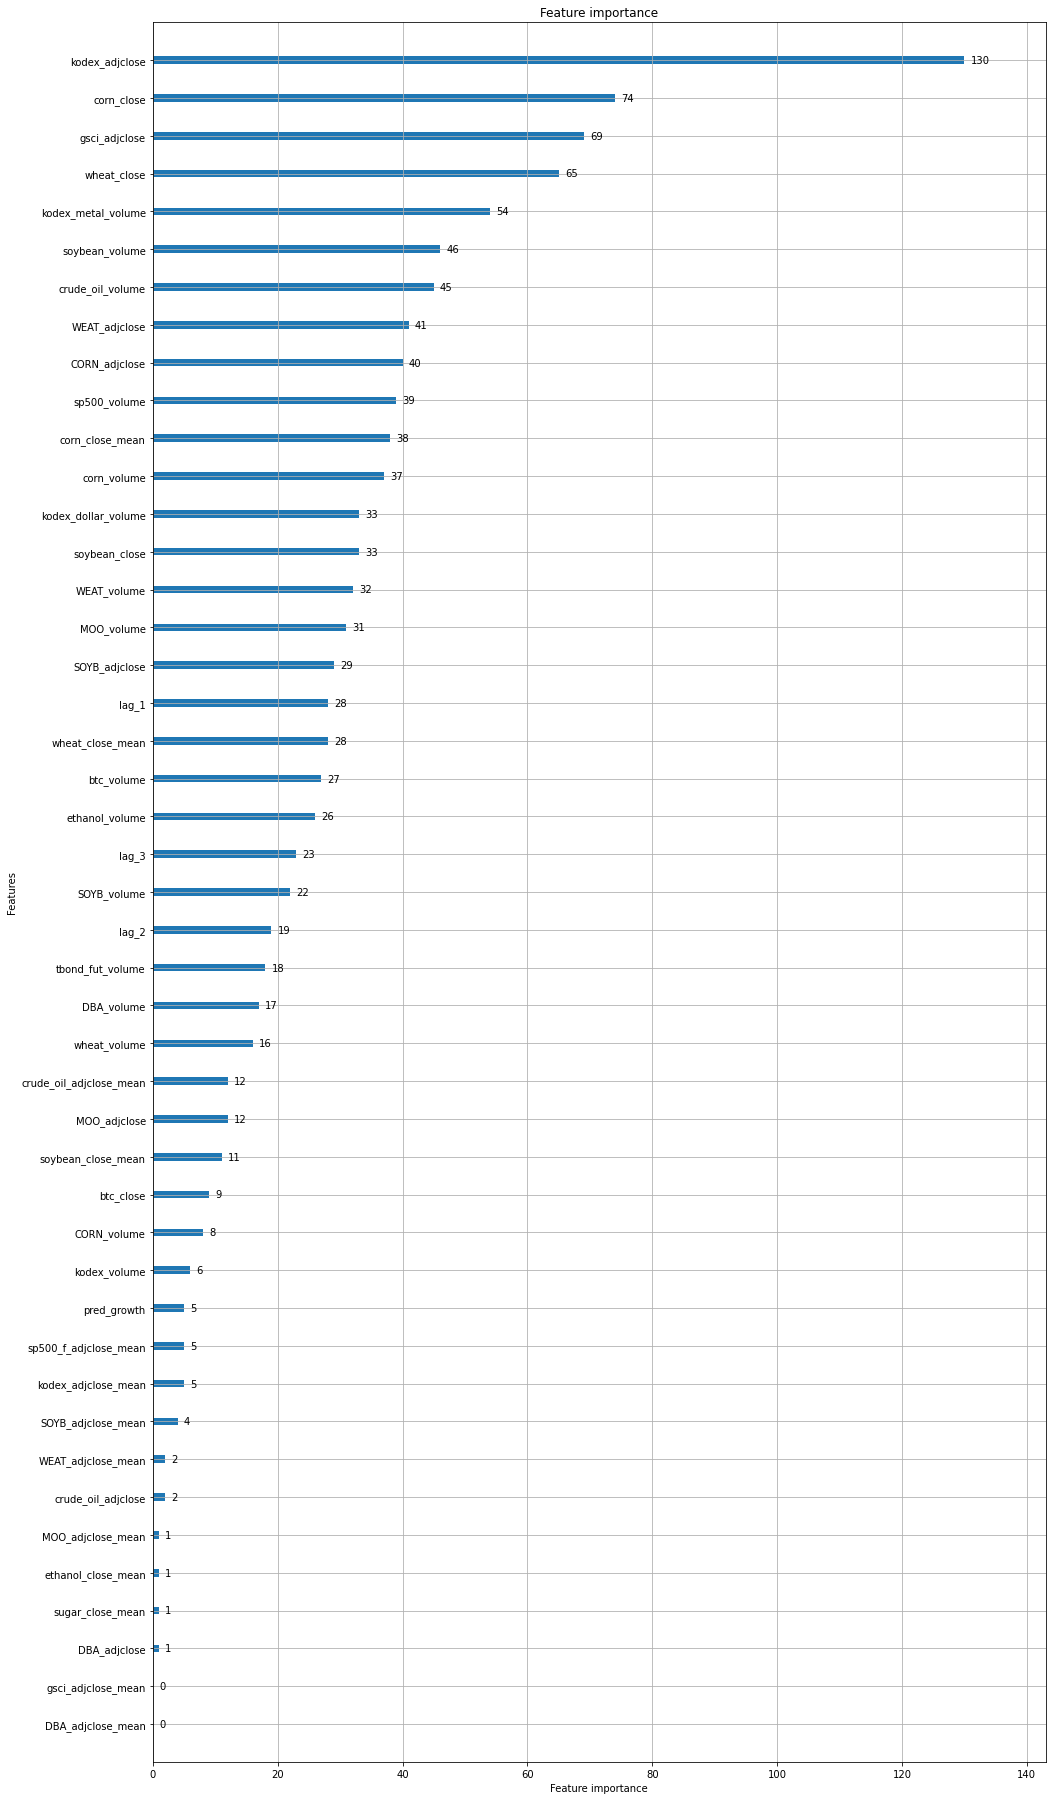

In [205]:
target_list_mod2 = []
for result in lgbBO_mod2.res:
    target = result['target']
    target_list_mod2.append(target)
max_dict_mod2 = lgbBO_mod2.res[np.argmax(np.array(target_list_mod2))]

params2 = change_values(**max_dict_mod2['params'])

lgb_model2 = LGBMClassifier(**params2)
lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds=25)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)